# Treasury Cashflow Forecast 

## 1. Setup & Configuration


## Using the hubbleAI Pipeline

The forecasting logic has been refactored into reusable modules under `src/hubbleAI/`.
You can run the full pipeline with a single function call:

```python
from hubbleAI.pipeline import run_forecast

# Run forecast (will train models and save results)
status = run_forecast(trigger_source='manual')
print(f"Status: {status.status}")
print(f"Output: {status.output_paths}")
```

The cells below continue to show the detailed exploration and analysis.
The core logic (data prep, features, models) now lives in:
- `src/hubbleAI/data_prep/` - Data loading and preparation
- `src/hubbleAI/features/` - Feature engineering
- `src/hubbleAI/models/` - LightGBM training and inference
- `src/hubbleAI/pipeline.py` - End-to-end orchestration


In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime, timedelta, date
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# ML libraries
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Stats
from scipy import stats

# Project modules - add src to path
import sys
sys.path.insert(0, '../src')

# hubbleAI imports
from hubbleAI.pipeline import run_forecast, ForecastRunStatus
from hubbleAI.config import (
    HORIZONS, LIQUIDITY_GROUPS, TIER2_LIST, LP_FORECAST_COLS,
    TRP_EXTRA_FEATURES, MIN_HISTORY_WEEKS
)
from hubbleAI.data_prep import (
    load_actuals, load_liquidity_plan, load_fx_rates,
    prepare_weekly_data
)
from hubbleAI.features import (
    build_all_features, get_base_feature_cols, get_feature_cols_for_horizon
)
from hubbleAI.models import train_lgbm_model, predict_lgbm, eval_metrics, wape

# grid search
from itertools import product
import random

print("Dependencies loaded successfully")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"LightGBM: {lgb.__version__}")


## 2. Load Raw Data (Actuals & LP)


In [ ]:
# Data file paths (using config constants)
from hubbleAI.config import ACTUALS_FILENAME, LP_FILENAME, FX_FILENAME, DATA_RAW_DIR

# For notebook exploration, load from current directory (data files are in notebooks folder)
# In production, the pipeline loads from DATA_RAW_DIR
ACTUALS_FILE_PATH = 'New_Actuals_17C7_2014.csv'
LP_FILE_PATH = 'New_LP_17C7.csv'
FX_RATES = '20251120_eurofxref-hist.csv'

print("\n[1/10] Loading data...")
actuals_df = pd.read_csv(ACTUALS_FILE_PATH)
lp_df = pd.read_csv(LP_FILE_PATH)
fx_df = pd.read_csv(FX_RATES)

print(f"✓ Actuals: Loaded {len(actuals_df):,} rows")
print(f"✓ Actuals: Columns: {len(actuals_df.columns)}")

print(f"✓ LP: Loaded {len(lp_df):,} rows")
print(f"✓ LP: Columns: {len(lp_df.columns)}")

print(f"✓ FX: Loaded {len(fx_df):,} rows")
print(f"✓ FX: Columns: {len(fx_df.columns)}")

# Note: For pipeline usage, copy data files to data/raw/ with standard names:
# - data/raw/New_Actuals_17C7_2014.csv
# - data/raw/New_LP_17C7.csv
# - data/raw/20251120_eurofxref-hist.csv


In [3]:
# Replace 57 with 057 as string 
actuals_df['Entity'] = actuals_df['Entity'].astype(str).replace('57', '057')
actuals_df['Entity'] = actuals_df['Entity'].astype(str).replace('10H2', '14C1')
actuals_df['Entity'] = actuals_df['Entity'].astype(str).replace('10G6', '17C7')


In [4]:
# Replace 57 with 057 as string 
lp_df['Entity'] = lp_df['Entity'].astype(str).replace('57', '057')
lp_df['Entity'] = lp_df['Entity'].astype(str).replace('10H2', '14C1')
lp_df['Entity'] = lp_df['Entity'].astype(str).replace('10G6', '17C7')

## 3. Filter & Prepare Actuals


In [5]:


actuals_filtered = actuals_df[[
    'Entity',
    'Value Date',
    'Amount Functional Currency',
    'Liquidity Group',
    'Counterpart',
    'Status',
    'ISO Country Code'
]].copy()

# Keep only TRR and TRP
actuals_filtered = actuals_filtered[
    actuals_filtered['Liquidity Group'].isin(['TRR', 'TRP'])
].copy()

# Normalise types / clean strings
actuals_filtered['Counterpart'] = actuals_filtered['Counterpart'].astype(str).str.strip()
actuals_filtered['Status'] = actuals_filtered['Status'].astype(str).str.strip()
actuals_filtered['ISO Country Code'] = actuals_filtered['ISO Country Code'].astype(str).str.strip()

print(f" ACTUALS: Original: {len(actuals_df):,} rows → Filtered: {len(actuals_filtered):,} rows")
actuals_filtered.to_csv('actuals_curated.csv', index=False)

lp_filtered = lp_df[[
    "Entity",
    "Entity Name",
    "Liquidity Group/Super Liquidity Group",
    "Year Title",
    "Item's Date",
    "Amount",
    "Currency",
    "Plan Currency",
    "Amount in plan currency",
    "Rate",
    "Comment"
]].copy()

# Keep only TRR and TRP
lp_filtered = lp_filtered[
    lp_filtered['Liquidity Group/Super Liquidity Group'].isin(['TRR', 'TRP'])
].copy()

# 2022/CW21 had issues. So the team reran the LP and captured it as 2022/CW21/2
lp_filtered = lp_filtered[lp_filtered['Year Title'] != '2022/CW21']
lp_filtered['Year Title'] = lp_filtered['Year Title'].str.extract(r'^(\d{4}/CW\d{2})')[0]

print(f" LP: Original: {len(lp_df):,} rows → Filtered: {len(lp_filtered):,} rows")
lp_filtered.to_csv('lp_curated.csv', index=False)


 ACTUALS: Original: 1,680,590 rows → Filtered: 1,523,944 rows
 LP: Original: 98,832 rows → Filtered: 72,990 rows


## 4. FX Rates & Plan Currency Normalisation


In [6]:

fx_df['Date'] = pd.to_datetime(fx_df['Date'])
fx_lookup = fx_df.set_index('Date')[['USD', 'CHF']].to_dict('index')


In [7]:

def convert_to_eur(row):
    """Convert USD/CHF to EUR using FX rates"""
    if row['Plan Currency'] == 'EUR':
        return row['Amount in plan currency']  # Already in EUR
    
    # Need conversion
    item_date = pd.to_datetime(row["Item's Date"])
    currency = row['Plan Currency']
    
    # Find closest FX rate (handle weekends/missing dates)
    while item_date not in fx_lookup and item_date >= fx_df['Date'].min():
        item_date -= pd.Timedelta(days=1)
    
    if item_date in fx_lookup:
        #print("\n FX conversion...")
        rate = fx_lookup[item_date].get(currency)
        if rate and not pd.isna(rate):
            return row['Amount'] / float(rate)  # Convert to EUR
    
    # Fallback: use Amount in plan currency as-is
    return row['Amount in plan currency']


In [8]:
lp_filtered['Amount_EUR'] = lp_filtered.apply(convert_to_eur, axis=1)

In [9]:
lp_filtered.rename(columns={'Liquidity Group/Super Liquidity Group': 'Liquidity_Group'}, inplace=True)

## 5. Liquidity Plan (LP) → Weekly Wide Format


In [10]:


# Sort by date within each group
lp_filtered['Item_Date'] = pd.to_datetime(lp_filtered["Item's Date"])
lp_filtered = lp_filtered.sort_values(['Entity', 'Entity Name', 'Year Title', 'Liquidity_Group', 'Item_Date'])

# Create week number (1, 2, 3, 4) within each Entity+YearTitle+LiqGroup
lp_filtered['Week_Num'] = lp_filtered.groupby(
    ['Entity', 'Entity Name', 'Year Title', 'Liquidity_Group']
).cumcount() + 1

# Keep only first 4 weeks
lp_filtered = lp_filtered[lp_filtered['Week_Num'] <= 4]

# Pivot
lp_wide = lp_filtered.pivot_table(
    index=['Entity', 'Entity Name', 'Year Title', 'Liquidity_Group'],
    columns='Week_Num',
    values='Amount_EUR',
    aggfunc='first'  # Take first value if duplicates
).reset_index()

# Rename columns
lp_wide.columns = ['Entity', 'Entity Name', 'Year_Title', 'Liquidity_Group', 
                    'W1_Forecast', 'W2_Forecast', 'W3_Forecast', 'W4_Forecast']

print(f"  LP pivoted: {len(lp_wide)} forecast combinations")
print("\nSample:")
print(lp_wide.head())

# Save
lp_wide.to_csv('lp_curated_pivoted.csv', index=False)

print("\n✅ DONE!")
print("  - actuals_curated.csv (filtered actuals)")
print("  - lp_curated.csv (pivoted LP with EUR conversion)")

  LP pivoted: 20321 forecast combinations

Sample:
  Entity      Entity Name Year_Title Liquidity_Group  W1_Forecast  \
0    057  ASSS LUXEMBOURG  2013/CW51             TRR    1154789.0   
1    057  ASSS LUXEMBOURG  2013/CW52             TRR    1154789.0   
2    057  ASSS LUXEMBOURG  2014/CW01             TRR    1154789.0   
3    057  ASSS LUXEMBOURG  2014/CW02             TRR    1154789.0   
4    057  ASSS LUXEMBOURG  2014/CW03             TRR    1245879.0   

   W2_Forecast  W3_Forecast  W4_Forecast  
0          NaN          NaN          NaN  
1    1254789.0          NaN          NaN  
2    1254789.0          NaN          NaN  
3    1254789.0          NaN          NaN  
4    1458798.0    1325489.0    1235489.0  

✅ DONE!
  - actuals_curated.csv (filtered actuals)
  - lp_curated.csv (pivoted LP with EUR conversion)


In [11]:

# Check which forecast weeks have NaN/missing values
forecast_cols = ['W1_Forecast', 'W2_Forecast', 'W3_Forecast', 'W4_Forecast']

print("\n  Missing Forecast Distribution:")
for col in forecast_cols:
    missing = lp_wide[col].isna().sum()
    missing_pct = (missing / len(lp_wide)) * 100
    present = len(lp_wide) - missing
    print(f"    {col}:")
    print(f"      Present: {present:,} ({100-missing_pct:.2f}%)")
    print(f"      Missing: {missing:,} ({missing_pct:.2f}%)")

# Create a flag for each forecast week availability
for col in forecast_cols:
    lp_wide[f'{col}_Available'] = ~lp_wide[col].isna()

# Count how many forecasts are available per row
lp_wide['Available_Forecast_Count'] = (
    lp_wide['W1_Forecast_Available'].astype(int) +
    lp_wide['W2_Forecast_Available'].astype(int) +
    lp_wide['W3_Forecast_Available'].astype(int) +
    lp_wide['W4_Forecast_Available'].astype(int)
)

print("\n  Forecast Availability Distribution:")
avail_dist = lp_wide['Available_Forecast_Count'].value_counts().sort_index()
for count, freq in avail_dist.items():
    print(f"    {count} forecasts available: {freq:,} rows ({freq/len(lp_wide)*100:.1f}%)")


  Missing Forecast Distribution:
    W1_Forecast:
      Present: 20,321 (100.00%)
      Missing: 0 (0.00%)
    W2_Forecast:
      Present: 19,644 (96.67%)
      Missing: 677 (3.33%)
    W3_Forecast:
      Present: 18,283 (89.97%)
      Missing: 2,038 (10.03%)
    W4_Forecast:
      Present: 14,722 (72.45%)
      Missing: 5,599 (27.55%)

  Forecast Availability Distribution:
    1 forecasts available: 677 rows (3.3%)
    2 forecasts available: 1,361 rows (6.7%)
    3 forecasts available: 3,561 rows (17.5%)
    4 forecasts available: 14,722 rows (72.4%)


In [12]:
actuals_filtered['Value Date'] = pd.to_datetime(actuals_filtered['Value Date'], errors='coerce')
#actuals_filtered['week_start'] = actuals_filtered['Week'].dt.start_time
actuals_filtered['iso_year'] = actuals_filtered['Value Date'].dt.isocalendar().year
actuals_filtered['iso_week'] = actuals_filtered['Value Date'].dt.isocalendar().week
actuals_filtered['week_start'] = pd.to_datetime(
    actuals_filtered['iso_year'].astype(str) + '-W' +
    actuals_filtered['iso_week'].astype(str) + '-1',
    format='%G-W%V-%u'
)

In [13]:
actuals_filtered["is_month_start"] = actuals_filtered['Value Date'].dt.is_month_start.astype(int)
actuals_filtered["is_month_end"]   = actuals_filtered['Value Date'].dt.is_month_end.astype(int)

In [14]:
# drop unnecessary columns from actuals_filtered
actuals_filtered.drop(columns=[ 'iso_year', 'iso_week'], inplace=True)

## 6. Actuals → Weekly Aggregation


In [15]:
actuals_weekly = actuals_filtered.groupby(['Entity', 'Liquidity Group', 'week_start']).agg(
                        total_amount_week=("Amount Functional Currency", "sum"),
                        week_has_month_start=("is_month_start", "max"),
                        week_has_month_end=("is_month_end", "max")
                    ).reset_index()

In [16]:
def add_week_has_month_middle(weekly: pd.DataFrame,
                              week_start_col: str = "week_start",
                              new_col: str = "week_has_month_middle") -> pd.DataFrame:
    """
    For each weekly row (with a week_start Monday),
    flag whether that week contains the 'middle of month' date
    for that month.
    
    Assumes:
      - weekly[week_start_col] is a datetime-like column (Monday of the week).
      - Weekly period is 7 days: [week_start, week_start + 6 days].
    """
    weekly = weekly.copy()
    
    s = pd.to_datetime(weekly[week_start_col])

    # Days in the month for the week_start date
    days_in_month = s.dt.days_in_month

    # Middle day-of-month (integer)
    mid_day = days_in_month // 2

    # First day of the month
    first_of_month = s.dt.to_period('M').dt.to_timestamp()

    # Actual "middle-of-month" date
    mid_date = first_of_month + pd.to_timedelta(mid_day - 1, unit="D")

    # Week end = week_start + 6 days
    week_end = s + pd.Timedelta(days=6)

    weekly[new_col] = ((mid_date >= s) & (mid_date <= week_end)).astype(int)

    return weekly

In [17]:

# add the “does this week contain mid-of-month” flag:
actuals_weekly = add_week_has_month_middle(actuals_weekly, week_start_col="week_start")


In [18]:
def add_week_has_day(weekly: pd.DataFrame,
                     day: int,
                     week_start_col: str = "week_start",
                     new_col: str = None) -> pd.DataFrame:
    """
    Flags whether the week (week_start .. week_start+6) contains
    a specific calendar day of the month.

    Example: day=10 creates a flag for whether the 10th of that month
    falls inside the week.
    """
    if new_col is None:
        new_col = f"week_has_{day}"

    weekly = weekly.copy()
    s = pd.to_datetime(weekly[week_start_col])

    # First day of month
    first_of_month = s.dt.to_period("M").dt.to_timestamp()

    # Candidate date = first_of_month + (day-1 days)
    target_date = first_of_month + pd.to_timedelta(day - 1, unit="D")

    week_end = s + pd.Timedelta(days=6)

    weekly[new_col] = ((target_date >= s) & (target_date <= week_end)).astype(int)
    return weekly


In [19]:
def add_week_has_eom_cluster(weekly: pd.DataFrame,
                             week_start_col: str = "week_start",
                             window: int = 6,
                             new_col: str = "week_has_eom_cluster") -> pd.DataFrame:
    """
    Flags if the week contains any of the last `window` days of the month.
    Example: window=4 flags 28,29,30,31 (depending on month length).
    """

    weekly = weekly.copy()
    s = pd.to_datetime(weekly[week_start_col])

    # Last day of month
    month_end = s.dt.to_period("M").dt.to_timestamp("M")

    # Days in month
    days_in_month = s.dt.days_in_month

    # Candidate final 4 days
    cluster_dates = [
        month_end - pd.Timedelta(days=i)
        for i in range(window)
    ]

    week_end = s + pd.Timedelta(days=6)

    flag = np.zeros(len(weekly), dtype=int)

    for d in cluster_dates:
        flag |= ((d >= s) & (d <= week_end)).astype(int)

    weekly[new_col] = flag
    return weekly


In [20]:
def add_week_has_bom_cluster(weekly: pd.DataFrame,
                             week_start_col: str = "week_start",
                             window: int = 3,
                             new_col: str = "week_has_bom_cluster") -> pd.DataFrame:
    """
    Flags if the week contains any of the first `window` days of the month.
    Example: window=4 flags days 1,2,3,4 (depending on where the week falls).
    """
    weekly = weekly.copy()
    s = pd.to_datetime(weekly[week_start_col])

    # First day of the month
    first_of_month = s.dt.to_period("M").dt.to_timestamp()

    # Candidate first N days
    cluster_dates = [
        first_of_month + pd.to_timedelta(i, unit="D")
        for i in range(window)
    ]

    week_end = s + pd.Timedelta(days=6)

    flag = np.zeros(len(weekly), dtype=int)
    for d in cluster_dates:
        flag |= ((d >= s) & (d <= week_end)).astype(int)

    weekly[new_col] = flag
    return weekly


In [21]:
# --- NEW date-based features (TRR + TRP) ---

# 10th, 15th, 20th of month
actuals_weekly = add_week_has_day(actuals_weekly, 10, new_col="week_has_10th")
actuals_weekly = add_week_has_day(actuals_weekly, 15, new_col="week_has_15th")
actuals_weekly = add_week_has_day(actuals_weekly, 20, new_col="week_has_20th")

# End-of-month cluster: last 4 days of month
actuals_weekly = add_week_has_eom_cluster(actuals_weekly, window=4, new_col="week_has_eom_cluster")

# Beginning-of-month cluster: first 4 days
actuals_weekly = add_week_has_bom_cluster(actuals_weekly, window=4, new_col="week_has_bom_cluster")

print("Added new date features:", 
      ["week_has_10th", "week_has_15th", "week_has_20th", "week_has_bom_cluster", "week_has_eom_cluster"])


Added new date features: ['week_has_10th', 'week_has_15th', 'week_has_20th', 'week_has_bom_cluster', 'week_has_eom_cluster']


In [22]:
actuals_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1523944 entries, 43 to 1680589
Data columns (total 10 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Entity                      1523944 non-null  object        
 1   Value Date                  1523944 non-null  datetime64[ns]
 2   Amount Functional Currency  1523944 non-null  float64       
 3   Liquidity Group             1523944 non-null  object        
 4   Counterpart                 1523944 non-null  object        
 5   Status                      1523944 non-null  object        
 6   ISO Country Code            1523944 non-null  object        
 7   week_start                  1523944 non-null  datetime64[ns]
 8   is_month_start              1523944 non-null  int64         
 9   is_month_end                1523944 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 127.9+ MB


In [23]:
actuals_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17987 entries, 0 to 17986
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Entity                 17987 non-null  object        
 1   Liquidity Group        17987 non-null  object        
 2   week_start             17987 non-null  datetime64[ns]
 3   total_amount_week      17987 non-null  float64       
 4   week_has_month_start   17987 non-null  int64         
 5   week_has_month_end     17987 non-null  int64         
 6   week_has_month_middle  17987 non-null  int64         
 7   week_has_10th          17987 non-null  int64         
 8   week_has_15th          17987 non-null  int64         
 9   week_has_20th          17987 non-null  int64         
 10  week_has_eom_cluster   17987 non-null  int64         
 11  week_has_bom_cluster   17987 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory

In [24]:
def build_trp_weekly_features(actuals_filtered):
    """
    Build TRP-specific weekly features from raw transaction-level actuals.
    Returns a dataframe with:
      ['Entity', 'Liquidity Group', 'week_start',
       'trp_vendor_count',
       'trp_top_vendor_share',
       'trp_country_count',
       'trp_top_country_share',
       'trp_reconciled_share']
    Only TRP rows are populated; TRR will be left as NaN when we merge.
    """
    df = actuals_filtered.copy()

    # Restrict to TRP only
    df_trp = df[df['Liquidity Group'] == 'TRP'].copy()
    if df_trp.empty:
        print("No TRP rows found for TRP weekly features.")
        return pd.DataFrame(columns=[
            'Entity', 'Liquidity Group', 'week_start',
            'trp_vendor_count', 'trp_top_vendor_share',
            'trp_country_count', 'trp_top_country_share',
            'trp_reconciled_share'
        ])

    # Ensure week_start exists on df_trp (we already computed it on actuals_filtered)
    if 'week_start' not in df_trp.columns:
        raise ValueError("week_start must be computed on actuals_filtered before calling build_trp_weekly_features.")

    # Work with absolute amounts for stability
    df_trp['amount_abs'] = df_trp['Amount Functional Currency'].abs()

    # -------------------------
    # 1) Vendor-level stats
    # -------------------------
    vendor_week = df_trp.groupby(
        ['Entity', 'Liquidity Group', 'week_start', 'Counterpart'],
        as_index=False
    )['amount_abs'].sum().rename(columns={'amount_abs': 'vendor_amount'})

    weekly_vendor = vendor_week.groupby(
        ['Entity', 'Liquidity Group', 'week_start'], as_index=False
    ).agg(
        trp_vendor_count=('Counterpart', 'nunique'),
        trp_top_vendor_amount=('vendor_amount', 'max'),
        trp_total_abs_vendor=('vendor_amount', 'sum')
    )

    weekly_vendor['trp_top_vendor_share'] = (
        weekly_vendor['trp_top_vendor_amount'] /
        (weekly_vendor['trp_total_abs_vendor'] + 1e-6)
    )

    # -------------------------
    # 2) Country-level stats
    # -------------------------
    country_week = df_trp.groupby(
        ['Entity', 'Liquidity Group', 'week_start', 'ISO Country Code'],
        as_index=False
    )['amount_abs'].sum().rename(columns={'amount_abs': 'country_amount'})

    weekly_country = country_week.groupby(
        ['Entity', 'Liquidity Group', 'week_start'], as_index=False
    ).agg(
        trp_country_count=('ISO Country Code', 'nunique'),
        trp_top_country_amount=('country_amount', 'max')
    )

    # Need total amount per week again for country share
    weekly_totals = df_trp.groupby(
        ['Entity', 'Liquidity Group', 'week_start'], as_index=False
    )['amount_abs'].sum().rename(columns={'amount_abs': 'trp_total_abs'})

    weekly_country = weekly_country.merge(
        weekly_totals,
        on=['Entity', 'Liquidity Group', 'week_start'],
        how='left'
    )

    weekly_country['trp_top_country_share'] = (
        weekly_country['trp_top_country_amount'] /
        (weekly_country['trp_total_abs'] + 1e-6)
    )

    # -------------------------
    # 3) Status-based stats
    # -------------------------
    df_trp['is_reconciled'] = df_trp['Status'].str.contains('Reconciled', case=False, na=False).astype(int)
    df_trp['amount_abs_reconciled'] = df_trp['amount_abs'] * df_trp['is_reconciled']

    weekly_status = df_trp.groupby(
        ['Entity', 'Liquidity Group', 'week_start'], as_index=False
    ).agg(
        trp_total_abs_status=('amount_abs', 'sum'),
        trp_reconciled_abs=('amount_abs_reconciled', 'sum')
    )

    weekly_status['trp_reconciled_share'] = (
        weekly_status['trp_reconciled_abs'] /
        (weekly_status['trp_total_abs_status'] + 1e-6)
    )

    # -------------------------
    # Combine all TRP weekly features
    # -------------------------
    trp_weekly = weekly_totals.copy()

    # Merge vendor stats
    trp_weekly = trp_weekly.merge(
        weekly_vendor[['Entity', 'Liquidity Group', 'week_start',
                       'trp_vendor_count', 'trp_top_vendor_share']],
        on=['Entity', 'Liquidity Group', 'week_start'],
        how='left'
    )

    # Merge country stats
    trp_weekly = trp_weekly.merge(
        weekly_country[['Entity', 'Liquidity Group', 'week_start',
                        'trp_country_count', 'trp_top_country_share']],
        on=['Entity', 'Liquidity Group', 'week_start'],
        how='left'
    )

    # Merge status stats
    trp_weekly = trp_weekly.merge(
        weekly_status[['Entity', 'Liquidity Group', 'week_start',
                       'trp_reconciled_share']],
        on=['Entity', 'Liquidity Group', 'week_start'],
        how='left'
    )

    # We no longer need trp_total_abs columns outside this helper
    trp_weekly = trp_weekly.drop(columns=['trp_total_abs'], errors='ignore')

    return trp_weekly


In [25]:
print("\n[6.2/10] Building TRP-specific weekly features...")

trp_weekly_features = build_trp_weekly_features(actuals_filtered)

print(f"✓ TRP weekly feature rows: {len(trp_weekly_features)}")

# Merge into actuals_weekly (which currently has columns: Entity, Liquidity Group, week_start, total_amount_week, week_has_month_start, week_has_month_end, week_has_month_middle)
actuals_weekly = actuals_weekly.merge(
    trp_weekly_features,
    on=['Entity', 'Liquidity Group', 'week_start'],
    how='left'
)



[6.2/10] Building TRP-specific weekly features...
✓ TRP weekly feature rows: 9205


In [26]:
actuals_weekly.head()

Entity Liquidity Group week_start  total_amount_week  week_has_month_start  \
0    057             TRP 2015-01-19         -145254.53                     0   
1    057             TRP 2015-01-26          -44498.74                     0   
2    057             TRP 2015-02-02         -222840.38                     0   
3    057             TRP 2015-02-09          -19153.57                     0   
4    057             TRP 2015-02-16           -3623.18                     0   

   week_has_month_end  week_has_month_middle  week_has_10th  week_has_15th  \
0                   0                      0              0              0   
1                   0                      0              0              0   
2                   0                      0              0              0   
3                   0                      1              1              1   
4                   0                      0              0              0   

   week_has_20th  week_has_eom_cluster  week_has_bom_cluster  \
0              1                     0                     0   
1              0                     1                     0   
2              0                     0                     1   
3              0                     0                     0   
4              1                     0                     0   

   trp_vendor_count  trp_top_vendor_share  trp_country_count  \
0               1.0                   1.0                1.0   
1               1.0                   1.0                1.0   
2               1.0                   1.0                1.0   
3               1.0                   1.0                1.0   
4               1.0                   1.0                1.0   

   trp_top_country_share  trp_reconciled_share  
0                    1.0              0.998248  
1                    1.0              1.000000  
2                    1.0              1.000000  
3                    1.0              1.000000  
4                    1.0              0.953568

In [27]:
from datetime import date
def yearweek_to_monday(yt):
    year, cw = yt.split('/CW')
    year = int(year)
    week = int(cw)
    # ISO weeks: Monday = 1
    return date.fromisocalendar(year, week, 1)

lp_wide['week_start'] = lp_wide['Year_Title'].apply(yearweek_to_monday)

In [28]:
lp_wide = lp_wide.rename(columns={"Entity":"entity", "Entity Name":"entity_name", "Liquidity_Group":"liquidity_group", "Available_Forecast_Count":"available_forecast_count"})

In [29]:
lp_wide['week_start'] = pd.to_datetime(lp_wide['week_start'])

In [30]:
lp_wide['week_start'] = pd.to_datetime(lp_wide['week_start']) - pd.Timedelta(days=7)

In [31]:
actuals_weekly = actuals_weekly.rename(columns={"Entity":"entity", "Liquidity Group":"liquidity_group"})

## 7. Merge Actuals & LP on Week Start


In [32]:
merged_df = actuals_weekly.merge(
    lp_wide,
    how='left',
    on=['entity', 'liquidity_group', 'week_start']
)

In [33]:
merged_df = merged_df.sort_values(['entity', 'liquidity_group', 'week_start'])

## 8. Feature Engineering


In [34]:

def add_lag_features(
    df: pd.DataFrame,
    value_col: str = "total_amount_week",
    group_cols=("entity", "liquidity_group"),
    n_lags: int = 52,
    prefix: str = "lag"
) -> pd.DataFrame:
    """
    Add lag features for `value_col` within each group in `group_cols`.
    Create columns like: lag_1w_total, ..., lag_52w_total.
    """
    df = df.copy()
    sort_cols = list(group_cols) + ["week_start"]
    df = df.sort_values(sort_cols)

    for lag in range(1, n_lags + 1):
        df[f"{prefix}_{lag}w_total"] = (
            df.groupby(list(group_cols))[value_col].shift(lag)
        )

    return df


In [35]:
merged_df = add_lag_features(
    merged_df,
    value_col="total_amount_week",
    group_cols=("entity", "liquidity_group"),
    n_lags=52,
)


In [36]:
def add_rolling_features(
    df: pd.DataFrame,
    value_col: str = "total_amount_week",
    group_cols=("entity", "liquidity_group"),
    windows=(4, 8, 12, 13, 26, 52),
) -> pd.DataFrame:
    """
    Add rolling stats over given windows for `value_col` within each (entity, liquidity_group) group.
    
    Metrics per window:
      - mean, std, sum, min, max, median, coefficient of variation (cv = std/mean)
    
    Uses shift(1) so that the current week's value is NOT included
    in the window (avoids data leakage).
    """
    df = df.copy()
    sort_cols = list(group_cols) + ["week_start"]
    df = df.sort_values(sort_cols)

    grouped = df.groupby(list(group_cols), group_keys=False)

    for w in windows:
        shifted = grouped[value_col].apply(lambda s: s.shift(1))

        roll = shifted.rolling(window=w, min_periods=1)

        mean_ = roll.mean()
        std_  = roll.std()
        sum_  = roll.sum()
        min_  = roll.min()
        max_  = roll.max()
        med_  = roll.median()

        # coefficient of variation = std / mean (handle division by zero)
        cv_ = std_ / mean_.replace(0, np.nan)

        df[f"roll_{w}w_mean"]   = mean_
        df[f"roll_{w}w_std"]    = std_
        df[f"roll_{w}w_sum"]    = sum_
        df[f"roll_{w}w_min"]    = min_
        df[f"roll_{w}w_max"]    = max_
        df[f"roll_{w}w_median"] = med_
        df[f"roll_{w}w_cv"]     = cv_

    return df


In [37]:
merged_df = add_rolling_features(
    merged_df,
    value_col="total_amount_week",
    group_cols=("entity", "liquidity_group"),
    windows=(4, 8, 13, 26, 52),
)


In [38]:
def add_calendar_features(
    df: pd.DataFrame,
    week_start_col: str = "week_start"
) -> pd.DataFrame:
    """
    Add weekly calendar features based on `week_start`:
      - year, month, quarter
      - iso_week_of_year
      - is_quarter_start, is_quarter_end
      - is_year_start, is_year_end
    """
    df = df.copy()
    s = pd.to_datetime(df[week_start_col])

    df["year"]            = s.dt.year
    df["month"]           = s.dt.month
    df["quarter"]         = s.dt.quarter
    df["iso_week_of_year"] = s.dt.isocalendar().week.astype("int32")

    df["is_quarter_start"] = s.dt.is_quarter_start.astype(int)
    df["is_quarter_end"]   = s.dt.is_quarter_end.astype(int)
    df["is_year_start"]    = s.dt.is_year_start.astype(int)
    df["is_year_end"]      = s.dt.is_year_end.astype(int)

    return df


In [39]:
merged_df = add_calendar_features(merged_df, week_start_col="week_start")


In [40]:
def add_trend_features(
    df: pd.DataFrame,
    value_col: str = "total_amount_week",
    group_cols=("entity", "liquidity_group"),
    trend_windows=(12, 26),
) -> pd.DataFrame:
    """
    Add rolling trend features:
      - trend_{w}w_slope: linear regression slope over last w weeks (on shifted series)
      - trend_{w}w_accel: week-over-week change in slope (for 12w by default)
    
    Uses shift(1) to ensure only past data is used.
    """
    df = df.copy()
    sort_cols = list(group_cols) + ["week_start"]
    df = df.sort_values(sort_cols)

    grouped = df.groupby(list(group_cols), group_keys=False)

    def _rolling_slope(arr: np.ndarray) -> float:
        """Compute slope of y ~ x over the window (x = 0..n-1)."""
        n = len(arr)
        if n < 2:
            return np.nan
        x = np.arange(n)
        y = arr.astype(float)
        if np.all(np.isnan(y)):
            return np.nan
        x_mean = x.mean()
        y_mean = np.nanmean(y)
        cov = np.nanmean((x - x_mean) * (y - y_mean))
        var = np.mean((x - x_mean) ** 2)
        if var == 0:
            return 0.0
        return cov / var

    for w in trend_windows:
        slopes = grouped[value_col].apply(
            lambda s: s.shift(1).rolling(window=w, min_periods=w)
                                .apply(_rolling_slope, raw=True)
        )
        df[f"trend_{w}w_slope"] = slopes

    # Acceleration: change in 12-week slope week over week (within group)
    if 12 in trend_windows:
        df["trend_12w_accel"] = (
            df.groupby(list(group_cols))[f"trend_12w_slope"].diff()
        )

    return df


In [41]:
merged_df = add_trend_features(
    merged_df,
    value_col="total_amount_week",
    group_cols=("entity", "liquidity_group"),
    trend_windows=(12, 26),
)


In [42]:
def add_lp_accuracy_features(
    df: pd.DataFrame,
    value_col: str = "total_amount_week",
    group_cols=("entity", "liquidity_group"),
    horizons=(1, 2, 3, 4),
    lp_prefix="W",
    window_bias: int = 12,
) -> pd.DataFrame:
    """
    Add historical liquidity plan accuracy features:
      For each horizon h in horizons:
        - lp_W{h}_error      = actual_t - W{h}_Forecast at t-h
        - lp_W{h}_abs_error  = |error|
        - lp_W{h}_bias_12w   = rolling mean(error) over past 12 weeks (shifted)
        - lp_W{h}_mae_12w    = rolling mean(abs_error) over past 12 weeks (shifted)
    
    All calculations are done within each (entity, liquidity_group) group.
    """
    df = df.copy()
    sort_cols = list(group_cols) + ["week_start"]
    df = df.sort_values(sort_cols)

    grouped = df.groupby(list(group_cols), group_keys=False)

    for h in horizons:
        fc_col = f"{lp_prefix}{h}_Forecast"
        if fc_col not in df.columns:
            continue  # skip if not present

        error_col = f"lp_W{h}_error"
        abs_error_col = f"lp_W{h}_abs_error"

        # Forecast made h weeks ago for this week's actual
        shifted_fc = grouped[fc_col].shift(h)
        df[error_col] = df[value_col] - shifted_fc
        df[abs_error_col] = df[error_col].abs()

        # Rolling 12-week bias and MAE (only past data)
        df[f"lp_W{h}_bias_{window_bias}w"] = grouped[error_col].apply(
            lambda s: s.shift(1).rolling(window=window_bias, min_periods=4).mean()
        )
        df[f"lp_W{h}_mae_{window_bias}w"] = grouped[abs_error_col].apply(
            lambda s: s.shift(1).rolling(window=window_bias, min_periods=4).mean()
        )

    return df


In [43]:
merged_df = add_lp_accuracy_features(
    merged_df,
    value_col="total_amount_week",
    group_cols=("entity", "liquidity_group"),
    horizons=(1, 2, 3, 4),
)


In [44]:
merged_df["entity"] = merged_df["entity"].astype("category")
merged_df["liquidity_group"] = merged_df["liquidity_group"].astype("category")


In [45]:
merged_df.shape

(17987, 142)

## 9. History Filtering, Tiering & Final Modeling Dataset 


In [46]:
uniques_actuals = actuals_weekly['week_start'].nunique()
uniques_lp = lp_wide['week_start'].nunique()
print(f"Actuals unique weeks:     {uniques_actuals}")
print(f"LP unique weeks:          {uniques_lp}")

# Find weeks present in actuals but absent in LP
missing_weeks = (
    actuals_weekly[['week_start']]
    .drop_duplicates()
    .merge(lp_wide[['week_start']].drop_duplicates(), on='week_start', how='left', indicator=True)
)
missing_actual_weeks = missing_weeks[missing_weeks['_merge'] == 'left_only']
print(f"Weeks missing in LP:      {len(missing_actual_weeks)}")
print("-----------------------------------")

Actuals unique weeks:     618
LP unique weeks:          621
Weeks missing in LP:      2
-----------------------------------


In [47]:
missing_combos = (
    actuals_weekly[['entity', 'liquidity_group', 'week_start']]
    .drop_duplicates()
    .merge(
        lp_wide[['entity', 'liquidity_group', 'week_start']],
        on=['entity', 'liquidity_group', 'week_start'],
        how='left',
        indicator=True
    )
)

missing_actual_combos = missing_combos[missing_combos['_merge'] == 'left_only']
print(f"Rows with actuals but no LP for that entity+liq+week: {len(missing_actual_combos)}")
missing_actual_combos.head()

Rows with actuals but no LP for that entity+liq+week: 2337


entity liquidity_group week_start     _merge
0      057             TRP 2015-01-19  left_only
1      057             TRP 2015-01-26  left_only
2      057             TRP 2015-02-02  left_only
347    057             TRP 2022-05-09  left_only
547    057             TRR 2014-12-22  left_only

In [48]:
missing_actual_combos.groupby(['entity', 'liquidity_group']).size().reset_index(name='missing_weeks').sort_values('missing_weeks', ascending=False)

entity liquidity_group  missing_weeks
22   T056             TRR            477
7    17C7             TRR            346
24   V002             TRR            297
5    14C1             TRR            262
8    20B2             TRP            218
3    11G5             TRR            121
6    17C7             TRP            101
11    4B9             TRR             85
10    4B9             TRP             82
9    20B2             TRR             64
20   T055             TRR             60
13    86W             TRP             58
21   T056             TRP             34
23   V002             TRP             34
19   T055             TRP             33
32   V756             TRR              9
1     057             TRR              7
30   V751             TRR              4
0     057             TRP              4
34   V798             TRR              3
26   V265             TRR              3
28   V508             TRR              3
25   V265             TRP              3
15    97C             TRP              3
14    86W             TRR              3
4    14C1             TRP              3
16    97C             TRR              3
27   V508             TRP              3
33   V798             TRP              3
2    11G5             TRP              2
17    97R             TRP              2
29   V751             TRP              2
18    97R             TRR              2
31   V756             TRP              2
12    82J             TRR              1

In [49]:
# Compute history_weeks
merged_df_sorted = merged_df.sort_values(['entity', 'liquidity_group', 'week_start']).copy()

merged_df_sorted['history_weeks'] = (
    merged_df_sorted
    .groupby(['entity','liquidity_group'])
    .cumcount()
)


In [50]:
history_summary = (
    merged_df_sorted.groupby(['entity','liquidity_group'])['history_weeks']
    .max()
    .reset_index()
    .rename(columns={'history_weeks': 'total_weeks'})
    .sort_values('total_weeks', ascending=False)
)

history_summary


entity liquidity_group  total_weeks
1     057             TRR        617.0
35   V756             TRR        617.0
37   V798             TRR        617.0
17    86W             TRR        617.0
19    97C             TRR        617.0
31   V508             TRR        617.0
29   V265             TRR        617.0
25   T056             TRR        617.0
23   T055             TRR        617.0
33   V751             TRR        615.0
27   V002             TRR        613.0
13    4B9             TRR        603.0
18    97C             TRP        597.0
26   V002             TRP        596.0
24   T056             TRP        596.0
30   V508             TRP        595.0
6    17C7             TRP        592.0
36   V798             TRP        592.0
16    86W             TRP        590.0
4    14C1             TRP        589.0
28   V265             TRP        579.0
12    4B9             TRP        571.0
34   V756             TRP        568.0
2    11G5             TRP        551.0
32   V751             TRP        550.0
22   T055             TRP        545.0
0     057             TRP        495.0
21    97R             TRR        352.0
20    97R             TRP        350.0
7    17C7             TRR        347.0
3    11G5             TRR        305.0
5    14C1             TRR        267.0
8    20B2             TRP        226.0
9    20B2             TRR         64.0
15    82J             TRR         45.0
14    82J             TRP          3.0
10   25A4             TRP          1.0
11   25A4             TRR          NaN

In [51]:
short_series = history_summary[history_summary['total_weeks'] < 52]
short_series

entity liquidity_group  total_weeks
15    82J             TRR         45.0
14    82J             TRP          3.0
10   25A4             TRP          1.0

In [52]:
baseline_cut = merged_df_sorted[merged_df_sorted['history_weeks'] >= 52].copy()
baseline_cut


entity liquidity_group week_start  total_amount_week  \
52       057             TRP 2016-02-15          -44000.82   
53       057             TRP 2016-02-22          -12797.78   
54       057             TRP 2016-02-29         -205073.08   
55       057             TRP 2016-03-07          -57655.43   
56       057             TRP 2016-03-14           -2853.37   
...      ...             ...        ...                ...   
17982   V798             TRR 2025-09-29        17890598.63   
17983   V798             TRR 2025-10-06        17107871.46   
17984   V798             TRR 2025-10-13        15996068.00   
17985   V798             TRR 2025-10-20        14491945.75   
17986   V798             TRR 2025-10-27        18394762.82   

       week_has_month_start  week_has_month_end  week_has_month_middle  \
52                        0                   0                      0   
53                        0                   0                      0   
54                        0                   1                      0   
55                        0                   0                      0   
56                        0                   0                      1   
...                     ...                 ...                    ...   
17982                     1                   1                      0   
17983                     0                   0                      0   
17984                     0                   0                      1   
17985                     0                   0                      0   
17986                     0                   1                      0   

       week_has_10th  week_has_15th  week_has_20th  ...  lp_W2_mae_12w  \
52                 0              1              1  ...   8.973380e+04   
53                 0              0              0  ...   9.302446e+04   
54                 0              0              0  ...   7.931023e+04   
55                 1              0              0  ...   6.426564e+04   
56                 0              1              1  ...   6.143247e+04   
...              ...            ...            ...  ...            ...   
17982              0              0              0  ...   2.496441e+06   
17983              1              0              0  ...   2.582170e+06   
17984              0              1              0  ...   2.751175e+06   
17985              0              0              1  ...   2.761219e+06   
17986              0              0              0  ...   2.534238e+06   

       lp_W3_error  lp_W3_abs_error  lp_W3_bias_12w  lp_W3_mae_12w  \
52             NaN              NaN    6.928500e+02   1.068696e+05   
53        -9191.78          9191.78    1.297158e+03   1.241924e+05   
54        18581.92         18581.92   -2.943239e+04   9.652673e+04   
55         1320.57          1320.57   -2.257321e+04   8.539175e+04   
56        -1409.37          1409.37   -1.958648e+04   7.488286e+04   
...            ...              ...             ...            ...   
17982  16390598.63      16390598.63    8.548939e+06   8.548939e+06   
17983  12607871.46      12607871.46    9.034668e+06   9.034668e+06   
17984  10796068.00      10796068.00    9.378673e+06   9.378673e+06   
17985   -508054.25        508054.25    9.659642e+06   9.659642e+06   
17986  11894762.82      11894762.82    8.640994e+06   8.725670e+06   

       lp_W4_error  lp_W4_abs_error lp_W4_bias_12w lp_W4_mae_12w  \
52             NaN              NaN            NaN           NaN   
53             NaN              NaN            NaN           NaN   
54        18581.92         18581.92            NaN           NaN   
55       -34898.43         34898.43            NaN           NaN   
56         1072.63          1072.63   3.633105e+04  5.862041e+04   
...            ...              ...            ...           ...   
17982  14890598.63      14890598.63   1.106561e+07  1.106561e+07   
17983  15107871.46      15107871.46   1.131800e+07  1.131800e+07   
17984  12996068.00      129960

In [53]:
post_cut_counts = (
    baseline_cut.groupby(['entity','liquidity_group'])
    .size()
    .reset_index(name='remaining_weeks')
    .sort_values('remaining_weeks', ascending=False)
)

post_cut_counts


entity liquidity_group  remaining_weeks
1     057             TRR              566
31   V508             TRR              566
35   V756             TRR              566
37   V798             TRR              566
17    86W             TRR              566
19    97C             TRR              566
25   T056             TRR              566
29   V265             TRR              566
23   T055             TRR              566
33   V751             TRR              564
27   V002             TRR              562
13    4B9             TRR              552
18    97C             TRP              546
26   V002             TRP              545
24   T056             TRP              545
30   V508             TRP              544
36   V798             TRP              541
6    17C7             TRP              541
16    86W             TRP              539
4    14C1             TRP              538
28   V265             TRP              528
12    4B9             TRP              520
34   V756             TRP              517
2    11G5             TRP              500
32   V751             TRP              499
22   T055             TRP              494
0     057             TRP              444
21    97R             TRR              301
20    97R             TRP              299
7    17C7             TRR              296
3    11G5             TRR              254
5    14C1             TRR              216
8    20B2             TRP              175
9    20B2             TRR               13
15    82J             TRR                0
14    82J             TRP                0
11   25A4             TRR                0
10   25A4             TRP                0

In [54]:
comparison = (
    history_summary
    .merge(post_cut_counts, on=['entity','liquidity_group'], how='left')
    .fillna({'remaining_weeks': 0})
)

comparison['lost_weeks'] = comparison['total_weeks'] - comparison['remaining_weeks']
comparison


entity liquidity_group  total_weeks  remaining_weeks  lost_weeks
0     057             TRR        617.0              566        51.0
1    V756             TRR        617.0              566        51.0
2    V798             TRR        617.0              566        51.0
3     86W             TRR        617.0              566        51.0
4     97C             TRR        617.0              566        51.0
5    V508             TRR        617.0              566        51.0
6    V265             TRR        617.0              566        51.0
7    T056             TRR        617.0              566        51.0
8    T055             TRR        617.0              566        51.0
9    V751             TRR        615.0              564        51.0
10   V002             TRR        613.0              562        51.0
11    4B9             TRR        603.0              552        51.0
12    97C             TRP        597.0              546        51.0
13   V002             TRP        596.0              545        51.0
14   T056             TRP        596.0              545        51.0
15   V508             TRP        595.0              544        51.0
16   17C7             TRP        592.0              541        51.0
17   V798             TRP        592.0              541        51.0
18    86W             TRP        590.0              539        51.0
19   14C1             TRP        589.0              538        51.0
20   V265             TRP        579.0              528        51.0
21    4B9             TRP        571.0              520        51.0
22   V756             TRP        568.0              517        51.0
23   11G5             TRP        551.0              500        51.0
24   V751             TRP        550.0              499        51.0
25   T055             TRP        545.0              494        51.0
26    057             TRP        495.0              444        51.0
27    97R             TRR        352.0              301        51.0
28    97R             TRP        350.0              299        51.0
29   17C7             TRR        347.0              296        51.0
30   11G5             TRR        305.0              254        51.0
31   14C1             TRR        267.0              216        51.0
32   20B2             TRP        226.0              175        51.0
33   20B2             TRR         64.0               13        51.0
34    82J             TRR         45.0                0        45.0
35    82J             TRP          3.0                0         3.0
36   25A4             TRP          1.0                0         1.0
37   25A4             TRR          NaN                0         NaN

In [55]:
amount_summary = (
    merged_df_sorted
    .groupby(['entity','liquidity_group'])['total_amount_week']
    .agg(
        total_amount_abs = lambda x: x.abs().sum(),
        mean_weekly = 'mean',
        median_weekly = 'median',
        total_weeks = 'size'
    )
    .reset_index()
)
amount_summary


entity liquidity_group  total_amount_abs   mean_weekly  median_weekly  \
0     057             TRP      5.887583e+07 -1.187013e+05  -4.246074e+04   
1     057             TRR      8.327024e+08  1.347415e+06   1.260960e+06   
2    11G5             TRP      3.626373e+08 -6.569516e+05  -3.279804e+05   
3    11G5             TRR      3.035229e+07  9.919048e+04   2.796840e+04   
4    14C1             TRP      1.637023e+10 -2.774615e+07  -1.842045e+07   
5    14C1             TRR      3.708356e+08  1.383715e+06   1.731880e+05   
6    17C7             TRP      9.624935e+08 -1.623092e+06  -5.803073e+05   
7    17C7             TRR      6.980293e+08  2.005831e+06   2.331024e+04   
8    20B2             TRP      1.155839e+08 -5.091801e+05  -3.948006e+05   
9    20B2             TRR      2.220305e+06  3.415853e+04   6.234200e+03   
10   25A4             TRP      2.500000e+00 -1.250000e+00  -1.250000e+00   
11   25A4             TRR               NaN           NaN            NaN   
12    4B9             TRP      1.902455e+08 -3.325970e+05  -1.322878e+05   
13    4B9             TRR      9.082530e+08  1.503730e+06   1.082029e+06   
14    82J             TRP      9.527423e+05 -2.381856e+05  -1.335992e+05   
15    82J             TRR      1.950982e+08  4.241265e+06   3.412277e+06   
16    86W             TRP      6.689937e+08 -1.131969e+06  -7.787505e+05   
17    86W             TRR      1.548200e+10  2.505178e+07   2.097439e+07   
18    97C             TRP      2.819431e+09 -4.714768e+06  -4.080902e+06   
19    97C             TRR      6.416803e+09  1.038318e+07   9.295958e+06   
20    97R             TRP      1.279838e+09 -3.646263e+06  -2.551112e+06   
21    97R             TRR      6.403999e+09  1.814164e+07   1.744288e+07   
22   T055             TRP      8.647136e+07 -1.583725e+05  -1.213232e+05   
23   T055             TRR      1.217462e+09  1.970003e+06   1.808541e+06   
24   T056             TRP      9.073853e+09 -1.519908e+07  -1.236785e+07   
25   T056             TRR      3.914313e+08  6.333840e+05   8.416790e+04   
26   V002             TRP      2.394984e+09 -4.011698e+06  -3.453522e+06   
27   V002             TRR      1.858358e+08  3.026642e+05   1.187165e+05   
28   V265             TRP      3.577713e+08 -6.168470e+05  -3.022116e+05   
29   V265             TRR      1.250912e+09  2.024129e+06   1.959959e+06   
30   V508             TRP      9.066480e+07 -1.521221e+05  -8.524629e+04   
31   V508             TRR      1.647847e+09  2.666419e+06   1.493134e+06   
32   V751             TRP      8.186445e+07 -1.485743e+05  -7.479826e+04   
33   V751             TRR      1.105164e+09  1.794097e+06   1.612823e+06   
34   V756             TRP      4.954133e+08 -8.706737e+05  -4.185860e+05   
35   V756             TRR      3.905422e+09  6.319454e+06   1.960837e+06   
36   V798             TRP      5.707357e+08 -9.624547e+05  -7.407692e+05   
37   V798             TRR      7.779551e+09  1.258827e+07   1.236289e+07   

    total_weeks  
0           496  
1           618  
2           552  
3           306  
4           590  
5           268  
6           593  
7           348  
8           227  
9            65  
10            2  
11            0  
12          572  
13          604  
14            4  
15           46  
16          591  
17          618  
18          598  
19          618  
20          351  
21          353  
22          546  
23          618  
24          597  
25          618  
26          597  
27          614  
28          580  
29          618  
30          596  
31          618  
32          551  
33          616  
34          569  
35          618  
36          593  
37          618

In [56]:
print("\n✓ Coverage by Entity:")
entity_liq_coverage = merged_df_sorted.groupby(['entity', 'liquidity_group'])['week_start'].agg(['min', 'max', 'count'])
entity_liq_coverage['days'] = (entity_liq_coverage['max'] - entity_liq_coverage['min']).dt.days
print(entity_liq_coverage)


✓ Coverage by Entity:
                              min        max  count    days
entity liquidity_group                                     
057    TRP             2015-01-19 2025-10-27    496  3934.0
       TRR             2013-12-30 2025-10-27    618  4319.0
11G5   TRP             2014-06-02 2025-10-27    552  4165.0
       TRR             2014-01-06 2025-10-27    306  4312.0
14C1   TRP             2014-05-26 2025-10-27    590  4172.0
       TRR             2014-01-06 2025-10-27    268  4312.0
17C7   TRP             2014-05-26 2025-10-27    593  4172.0
       TRR             2014-01-06 2025-10-27    348  4312.0
20B2   TRP             2021-05-31 2025-10-27    227  1610.0
       TRR             2021-08-09 2025-10-27     65  1540.0
25A4   TRP             2025-10-20 2025-10-27      2     7.0
       TRR                    NaT        NaT      0     NaN
4B9    TRP             2014-06-09 2025-10-27    572  4158.0
       TRR             2014-04-07 2025-10-27    604  4221.0
82J    TRP       

In [57]:
merged_df_sorted.head()

entity liquidity_group week_start  total_amount_week  week_has_month_start  \
0    057             TRP 2015-01-19         -145254.53                     0   
1    057             TRP 2015-01-26          -44498.74                     0   
2    057             TRP 2015-02-02         -222840.38                     0   
3    057             TRP 2015-02-09          -19153.57                     0   
4    057             TRP 2015-02-16           -3623.18                     0   

   week_has_month_end  week_has_month_middle  week_has_10th  week_has_15th  \
0                   0                      0              0              0   
1                   0                      0              0              0   
2                   0                      0              0              0   
3                   0                      1              1              1   
4                   0                      0              0              0   

   week_has_20th  ...  lp_W2_mae_12w  lp_W3_error  lp_W3_abs_error  \
0              1  ...            NaN          NaN              NaN   
1              0  ...            NaN          NaN              NaN   
2              0  ...            NaN          NaN              NaN   
3              0  ...            NaN          NaN              NaN   
4              1  ...            NaN          NaN              NaN   

   lp_W3_bias_12w  lp_W3_mae_12w  lp_W4_error  lp_W4_abs_error lp_W4_bias_12w  \
0             NaN            NaN          NaN              NaN            NaN   
1             NaN            NaN          NaN              NaN            NaN   
2             NaN            NaN          NaN              NaN            NaN   
3             NaN            NaN          NaN              NaN            NaN   
4             NaN            NaN          NaN              NaN            NaN   

  lp_W4_mae_12w  history_weeks  
0           NaN              0  
1           NaN              1  
2           NaN              2  
3           NaN              3  
4           NaN              4  

[5 rows x 143 columns]

In [58]:

def max_missing_weeks(group):
    # Ensure sorted
    weeks = group['week_start'].sort_values().unique()

    # Full weekly range between min & max
    full_range = pd.date_range(start=weeks.min(), end=weeks.max(), freq='W-MON')

    # Missing weeks
    missing = full_range.difference(weeks)

    if len(missing) == 0:
        return 0, []  # (no missing weeks, no ranges)

    missing_series = missing.to_series()

    # Identify consecutive missing blocks
    block_ids = (missing_series.diff() != pd.Timedelta(days=7)).cumsum()

    ranges = []
    longest_stretch = 0  # in weeks

    for _, block in missing_series.groupby(block_ids):
        block_len_weeks = block.size               # number of consecutive missing weeks
        longest_stretch = max(longest_stretch, block_len_weeks)

        missing_days = block_len_weeks * 7         # 1 week = 7 days

        # 🔴 Only keep ranges where missing days > 7  (i.e. at least 2 weeks)
        if missing_days > 7:
            start = block.min().date()
            end = block.max().date()
            ranges.append((start, end))

    return longest_stretch, ranges


In [59]:


missing_info = (
    merged_df_sorted
    .groupby(['entity', 'liquidity_group'])
    .apply(max_missing_weeks)
)

missing_info = missing_info.apply(pd.Series)
missing_info.columns = ['max_missing_weeks', 'missing_range']

entity_liq_coverage = entity_liq_coverage.join(missing_info)

print(entity_liq_coverage)


                              min        max  count    days  \
entity liquidity_group                                        
057    TRP             2015-01-19 2025-10-27    496  3934.0   
       TRR             2013-12-30 2025-10-27    618  4319.0   
11G5   TRP             2014-06-02 2025-10-27    552  4165.0   
       TRR             2014-01-06 2025-10-27    306  4312.0   
14C1   TRP             2014-05-26 2025-10-27    590  4172.0   
       TRR             2014-01-06 2025-10-27    268  4312.0   
17C7   TRP             2014-05-26 2025-10-27    593  4172.0   
       TRR             2014-01-06 2025-10-27    348  4312.0   
20B2   TRP             2021-05-31 2025-10-27    227  1610.0   
       TRR             2021-08-09 2025-10-27     65  1540.0   
25A4   TRP             2025-10-20 2025-10-27      2     7.0   
       TRR                    NaT        NaT      0     NaN   
4B9    TRP             2014-06-09 2025-10-27    572  4158.0   
       TRR             2014-04-07 2025-10-27    604  42

In [60]:
import pandas as pd

class WeeklyDataQualityAnalyzer:
    """
    Analyze weekly time-series completeness by (entity, liquidity_group).

    Assumes:
      - One row per observed week (or multiple rows; duplicates are deduped)
      - Weekly frequency (default W-MON)
      - Columns: entity, liquidity_group, week_start (configurable)
    """

    def __init__(
        self,
        df: pd.DataFrame,
        entity_col: str = "entity",
        liquidity_col: str = "liquidity_group",
        date_col: str = "week_start",
        freq: str = "W-MON",
    ):
        self.df = df.copy()
        self.entity_col = entity_col
        self.liquidity_col = liquidity_col
        self.date_col = date_col
        self.freq = freq

        # Ensure datetime
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        # Keep only relevant columns & drop duplicates
        self.base = (
            self.df[[self.entity_col, self.liquidity_col, self.date_col]]
            .drop_duplicates()
        )

    # ---------- Core internal helpers ----------

    def _build_full_panel(self) -> pd.DataFrame:
        """Create full weekly panel with has_data flag."""
        # Unique entity/liquidity combos
        groups = self.base[[self.entity_col, self.liquidity_col]].drop_duplicates()

        # Global weekly range
        all_weeks = pd.date_range(
            start=self.base[self.date_col].min(),
            end=self.base[self.date_col].max(),
            freq=self.freq,
        )

        # Cartesian product groups × weeks
        groups = groups.assign(_key=1)
        weeks_df = pd.DataFrame({self.date_col: all_weeks, "_key": 1})

        full = groups.merge(weeks_df, on="_key").drop(columns="_key")

        # Mark observed weeks
        full = full.merge(
            self.base.assign(has_data=1),
            on=[self.entity_col, self.liquidity_col, self.date_col],
            how="left",
        )
        full["has_data"] = full["has_data"].fillna(0).astype(int)
        return full

    @staticmethod
    def _gap_stats(group: pd.DataFrame) -> pd.Series:
        """
        Compute:
          - number of gaps
          - longest gap length in weeks
          - start and end date of the longest gap
        """
        group = group.sort_values("week_start")
        missing = group[group["has_data"] == 0]["week_start"]
    
        if missing.empty:
            return pd.Series(
                {
                    "n_gaps": 0,
                    "max_gap_weeks": 0,
                    "max_gap_week_start": pd.NaT,
                    "max_gap_week_end": pd.NaT,
                }
            )
    
        s = missing.reset_index(drop=True)
        block_ids = (s.diff() != pd.Timedelta(days=7)).cumsum()
        block_sizes = s.groupby(block_ids).size()
    
        # identify the block with the longest gap
        max_block_id = block_sizes.idxmax()
        max_block = s[block_ids == max_block_id]
    
        return pd.Series(
            {
                "n_gaps": int(block_sizes.size),
                "max_gap_weeks": int(block_sizes.loc[max_block_id]),
                "max_gap_week_start": max_block.min(),  # Timestamp
                "max_gap_week_end": max_block.max(),    # Timestamp
            }
        )

    @staticmethod
    def _extract_gap_ranges(
        group: pd.DataFrame, min_gap_weeks: int = 2
    ) -> pd.DataFrame:
        """
        Return gap ranges (start, end, length in weeks) for one group.
        Only gaps with length >= min_gap_weeks are kept.
        """
        group = group.sort_values("week_start")
        missing = group[group["has_data"] == 0]["week_start"]

        if missing.empty:
            return pd.DataFrame(columns=["gap_start", "gap_end", "gap_weeks"])

        s = missing.reset_index(drop=True) #to_series()
        block_ids = (s.diff() != pd.Timedelta(days=7)).cumsum()

        rows = []
        for _, block in s.groupby(block_ids):
            gap_weeks = block.size
            if gap_weeks >= min_gap_weeks:
                rows.append(
                    {
                        "gap_start": block.min().date(),
                        "gap_end": block.max().date(),
                        "gap_weeks": int(gap_weeks),
                    }
                )

        return pd.DataFrame(rows)

    # ---------- Public main API ----------

    def analyze(self, min_gap_weeks: int = 2):
        """
        Main entry point.

        Returns:
            quality: per-(entity, liquidity_group) summary (coverage, gaps, etc.)
            gap_table: flattened list of significant gaps per group
        """
        full = self._build_full_panel()
        # store if you want to inspect later
        self.full_panel_ = full

        # Coverage / basic stats
        coverage_stats = (
            full.groupby([self.entity_col, self.liquidity_col])
            .agg(
                total_weeks=(self.date_col, "size"),
                observed_weeks=("has_data", "sum"),
                missing_weeks=("has_data", lambda x: int((1 - x).sum())),
                coverage_pct=("has_data", lambda x: float(x.mean() * 100)),
                first_week=(self.date_col, "min"),
                last_week=(self.date_col, "max"),
            )
        )

        # First/last observed
        obs_stats = (
            full[full["has_data"] == 1]
            .groupby([self.entity_col, self.liquidity_col])[self.date_col]
            .agg(first_observed="min", last_observed="max")
        )

        quality = coverage_stats.join(obs_stats)

        # Gap stats
        gap_info = (
            full.groupby([self.entity_col, self.liquidity_col])
            .apply(self._gap_stats)
        )
        quality = quality.join(gap_info)

        # Detailed gap table
        gap_rows = []
        for (ent, lg), grp in full.groupby([self.entity_col, self.liquidity_col]):
            ranges_df = self._extract_gap_ranges(
                grp.rename(columns={self.date_col: "week_start"}),
                min_gap_weeks=min_gap_weeks,
            )
            if not ranges_df.empty:
                ranges_df.insert(0, self.entity_col, ent)
                ranges_df.insert(1, self.liquidity_col, lg)
                gap_rows.append(ranges_df)

        if gap_rows:
            gap_table = pd.concat(gap_rows, ignore_index=True)
        else:
            gap_table = pd.DataFrame(
                columns=[
                    self.entity_col,
                    self.liquidity_col,
                    "gap_start",
                    "gap_end",
                    "gap_weeks",
                ]
            )

        # keep for later inspection
        self.quality_ = quality
        self.gap_table_ = gap_table

        return quality, gap_table

    def apply_quality_labels(
        self,
        quality: pd.DataFrame,
        min_coverage_pct: float = 70.0,
        max_gap_weeks: int = 8,
        min_last_observed: str | None = None,
    ) -> pd.DataFrame:
        """
        Add a 'quality_label' column: 'keep' or a reason to drop.
        Rules are simple heuristics – tweak thresholds as needed.
        """
        q = quality.copy()

        if min_last_observed is not None:
            min_last_observed = pd.to_datetime(min_last_observed)

        def _label(row):
            if row["coverage_pct"] < min_coverage_pct:
                return "drop_low_coverage"
            if row["max_gap_weeks"] >= max_gap_weeks:
                return "drop_long_gaps"
            if (
                min_last_observed is not None
                and row["last_observed"] < min_last_observed
            ):
                return "drop_stale_series"
            return "keep"

        q["quality_label"] = q.apply(_label, axis=1)
        return q


In [61]:
# 1) Initialize
analyzer = WeeklyDataQualityAnalyzer(
    merged_df_sorted,
    entity_col="entity",
    liquidity_col="liquidity_group",
    date_col="week_start",
    freq="W-MON",   # adjust if your weeks are different
)

# 2) Compute quality + gap table
quality, gap_table = analyzer.analyze(min_gap_weeks=2)

# 3) Add a simple keep/drop decision (tune thresholds as you like)
quality_labeled = analyzer.apply_quality_labels(
    quality,
    min_coverage_pct=75.0,
    max_gap_weeks=8,
    min_last_observed="2022-01-01",
)

# Example: see which combos you'd keep for the ML model
quality_labeled[quality_labeled["quality_label"] == "keep"]

# Example: inspect worst gaps
gap_table.sort_values("gap_weeks", ascending=False).head(10)


entity liquidity_group   gap_start     gap_end  gap_weeks
271   25A4             TRP  2013-12-30  2025-10-13        616
277    82J             TRP  2013-12-30  2025-07-07        602
279    82J             TRR  2013-12-30  2024-12-09        572
234   20B2             TRR  2013-12-30  2021-08-02        397
232   20B2             TRP  2013-12-30  2021-05-24        387
282    97R             TRP  2013-12-30  2019-02-04        267
283    97R             TRR  2013-12-30  2019-01-21        265
289   V751             TRP  2013-12-30  2015-02-23         61
0      057             TRP  2013-12-30  2015-01-12         55
296   V798             TRP  2013-12-30  2014-06-16         25

In [62]:
quality_labeled[quality_labeled["quality_label"] != "keep"]


total_weeks  observed_weeks  missing_weeks  \
entity liquidity_group                                               
057    TRP                      618             496          122.0   
11G5   TRP                      618             552           66.0   
       TRR                      618             306          312.0   
14C1   TRP                      618             590           28.0   
       TRR                      618             268          350.0   
17C7   TRP                      618             593           25.0   
       TRR                      618             348          270.0   
20B2   TRP                      618             227          391.0   
       TRR                      618              65          553.0   
25A4   TRP                      618               2          616.0   
4B9    TRP                      618             572           46.0   
       TRR                      618             604           14.0   
82J    TRP                      618               4          614.0   
       TRR                      618              46          572.0   
86W    TRP                      618             591           27.0   
97C    TRP                      618             598           20.0   
97R    TRP                      618             351          267.0   
       TRR                      618             353          265.0   
T055   TRP                      618             546           72.0   
T056   TRP                      618             597           21.0   
V002   TRP                      618             597           21.0   
V265   TRP                      618             580           38.0   
V508   TRP                      618             596           22.0   
V751   TRP                      618             551           67.0   
V756   TRP                      618             569           49.0   
V798   TRP                      618             593           25.0   

                        coverage_pct first_week  last_week first_observed  \
entity liquidity_group                                                      
057    TRP                 80.258900 2013-12-30 2025-10-27     2015-01-19   
11G5   TRP                 89.320388 2013-12-30 2025-10-27     2014-06-02   
       TRR                 49.514563 2013-12-30 2025-10-27     2014-01-06   
14C1   TRP                 95.469256 2013-12-30 2025-10-27     2014-05-26   
       TRR                 43.365696 2013-12-30 2025-10-27     2014-01-06   
17C7   TRP                 95.954693 2013-12-30 2025-10-27     2014-05-26   
       TRR                 56.310680 2013-12-30 2025-10-27     2014-01-06   
20B2   TRP                 36.731392 2013-12-30 2025-10-27     2021-05-31   
       TRR                 10.517799 2013-12-30 2025-10-27     2021-08-09   
25A4   TRP                  0.323625 2013-12-30 2025-10-27     2025-10-20   
4B9    TRP                 92.556634 2013-12-30 2025-10-27     2014-06-09   
       TRR                 97.734628 2013-12-30 2025-10-27     2014-04-07   
82J    TRP                  0.647249 2013-12-30 2025-10-27     2025-07-14   
       TRR                  7.443366 2013-12-30 2025-10-27     2024-12-16   
86W    TRP                 95.631068 2013-12-30 2025-10-27     2014-05-26   
97C    TRP                 96.763754 2013-12-30 2025-10-27     2014-05-19   
97R    TRP                 56.796117 2013-12-30 2025-10-27     2019-02-11   
       TRR                 57.119741 2013-12-30 2025-10-27     2019-01-28   
T055   TRP                 88.349515 2013-12-30 2025-10-27     2014-06-02   
T056   TRP                 96.601942 2013-12-30 2025-10-27     2014-05-26   
V002   TRP                 96.601942 2013-12-30 2025-10-27     2014-05-26   
V265   TRP                 93.851133 2013-12-30 2025-10-27     2014-06-02   
V508   TRP                 96.440129 2013-12-30 2025-10-27     2014-06-02   
V751   TRP                 89.158576 2013-12-30 2025-10-27     2015-03-02   
V756   TRP                 92.071197 2013-12-30 2025-10-27   

In [63]:
quality_labeled.to_csv('New_Long_Data_Quality_Analysis.csv', index=True)

In [64]:
merged_df_sorted.to_csv('Merged_Sorted_Dataset_for_analysis.csv', index=True)

In [65]:
full = analyzer.full_panel_.copy()


In [66]:
full["combo"] = full["entity"].astype(str) + "_" + full["liquidity_group"].astype(str)

In [67]:
# pivot: rows = combo, columns = week_start, values = has_data (0/1)
matrix = full.pivot_table(
    index="combo",
    columns="week_start",
    values="has_data",
    aggfunc="max",   # in case you ever have multiple rows per week
    fill_value=0
)

# sort by combo and by time
matrix = matrix.sort_index()
matrix = matrix.reindex(sorted(matrix.columns), axis=1)


In [68]:
import math
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

def plot_missingness_paginated(matrix, combos_per_page=8):
    combos = matrix.index.tolist()
    n = len(combos)
    n_pages = math.ceil(n / combos_per_page)

    pdf_path = "Data_Distribution_Entity_LG.pdf"

    with PdfPages(pdf_path) as pdf:
        for page in range(n_pages):
            start = page * combos_per_page
            end = start + combos_per_page
            subset = matrix.iloc[start:end]
    
            fig, ax = plt.subplots(figsize=(18, 2 + 0.5 * len(subset)))
    
            # data: 1 = green (has data), 0 = red (missing)
            data = subset.values
    
            # custom colormap: 0 -> red, 1 -> green
            from matplotlib.colors import ListedColormap
            cmap = ListedColormap(["red", "green"])
    
            im = ax.imshow(
                data,
                aspect="auto",
                interpolation="nearest",
                cmap=cmap,
            )
    
            # y-axis = combo labels
            ax.set_yticks(np.arange(subset.shape[0]))
            ax.set_yticklabels(subset.index)
    
            # x-axis = sparse time labels (e.g. yearly ticks to avoid clutter)
            col_dates = subset.columns.to_list()
            n_cols = len(col_dates)
    
            # put a tick roughly every 52 weeks (yearly)
            step = max(1, n_cols // 10)  # about 10 ticks across
            tick_positions = list(range(0, n_cols, step))
            tick_labels = [col_dates[i].strftime("%Y-%m-%d") for i in tick_positions]
    
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    
            ax.set_xlabel("Week")
            ax.set_title(f"Data availability by combo (page {page + 1}/{n_pages})")
    
            plt.tight_layout()
            plt.savefig(f"Data_Distribution_{page+1}_of_{n_pages}.png", dpi=300)
            pdf.savefig(fig)
            plt.show()

        


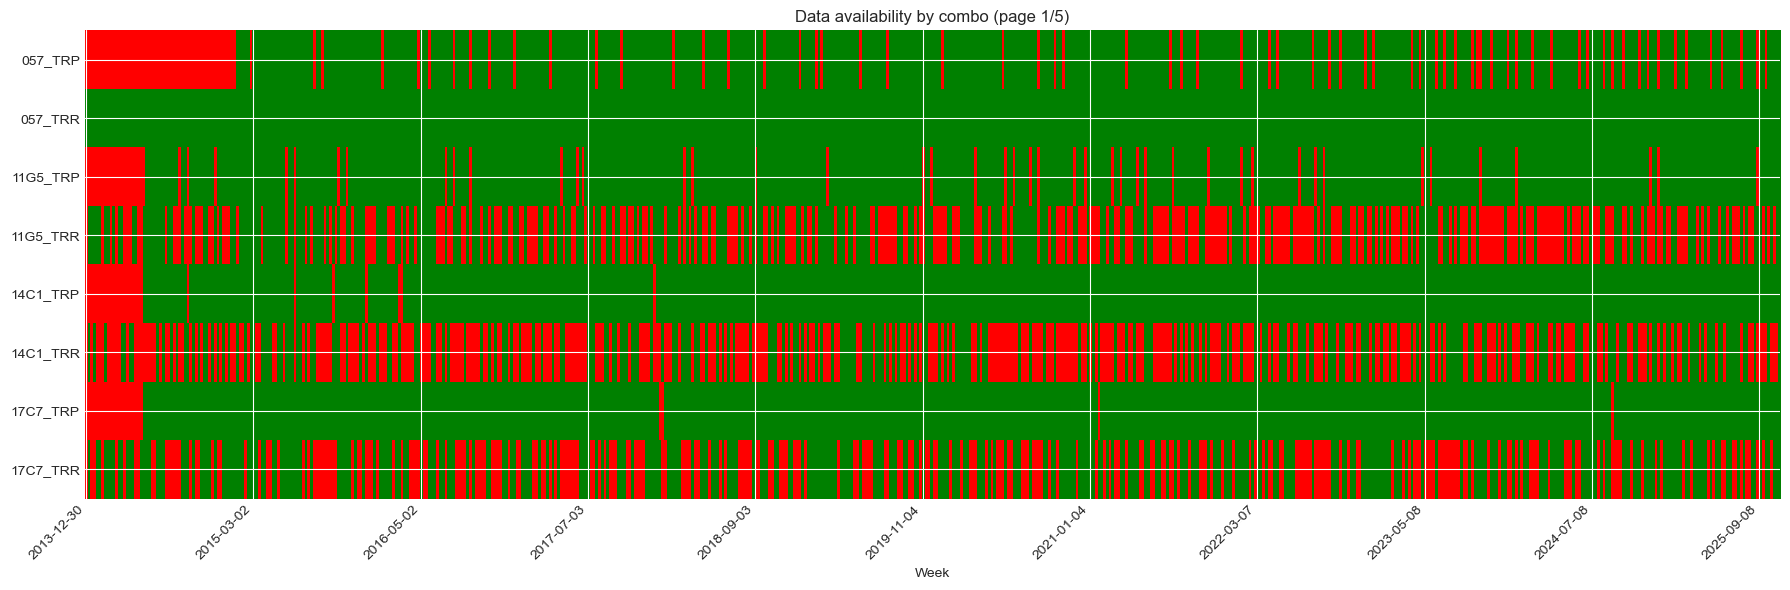

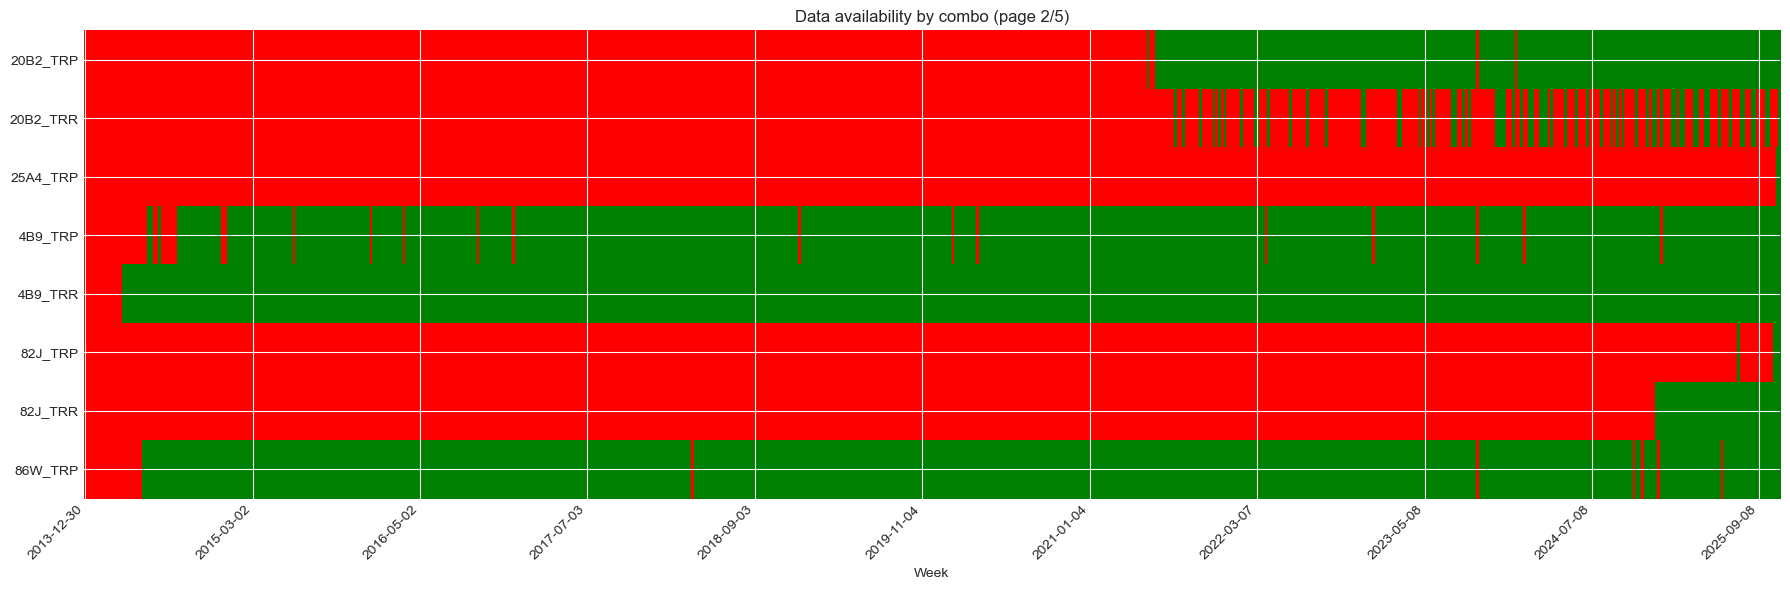

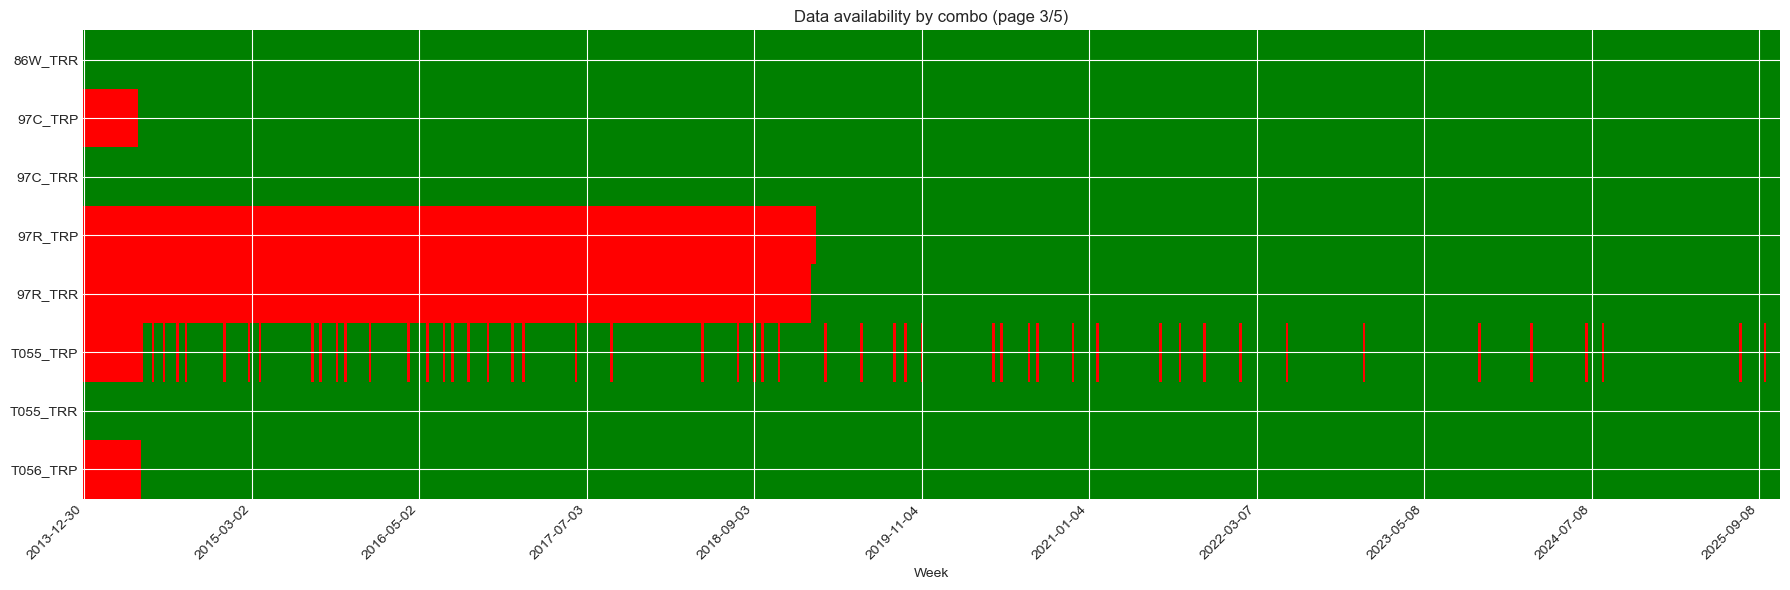

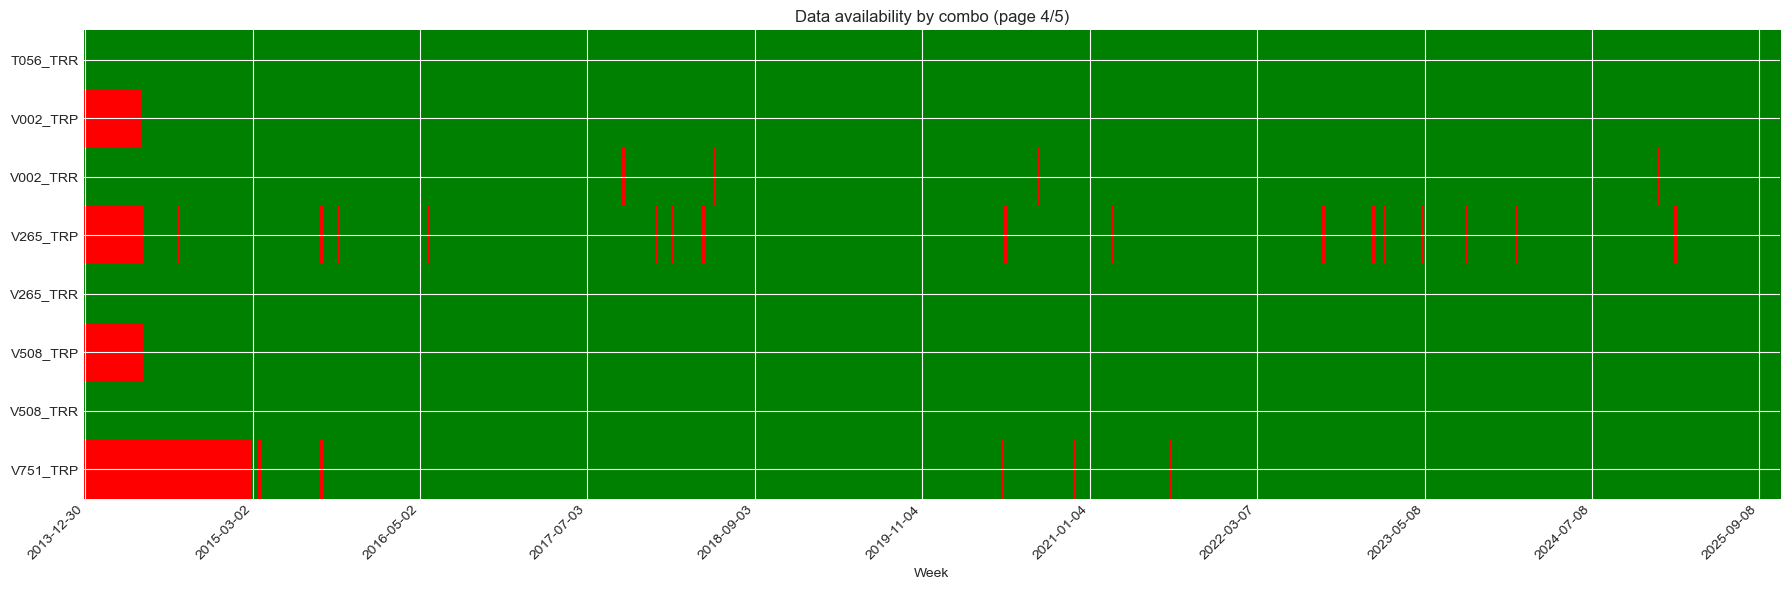

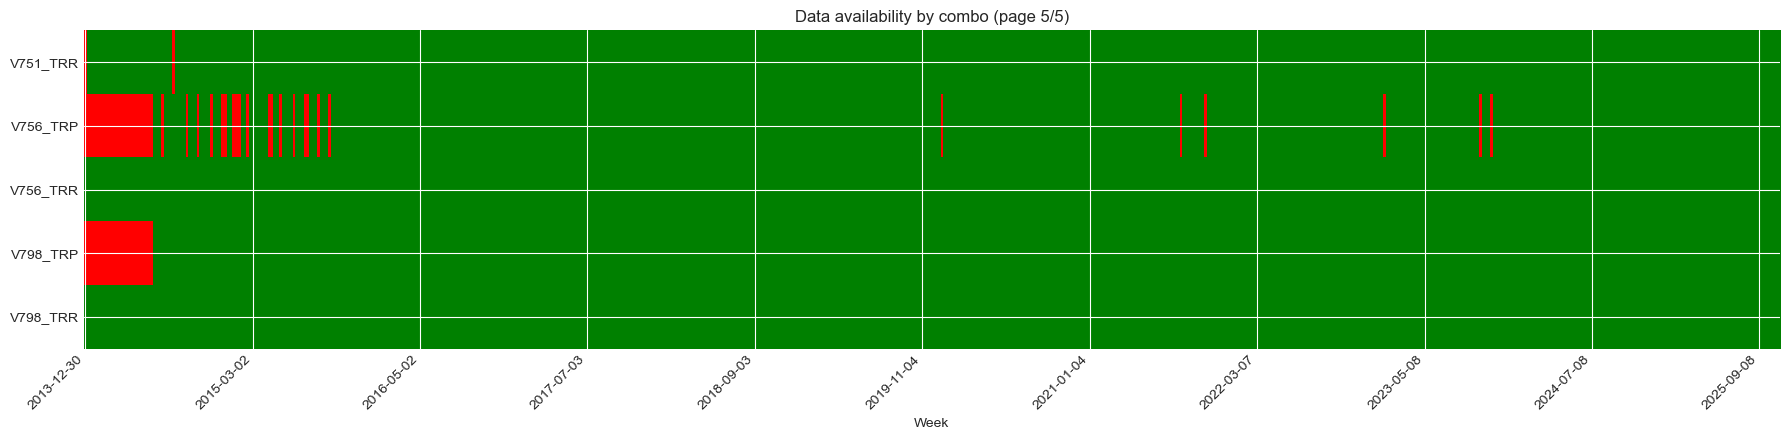

In [69]:
plot_missingness_paginated(matrix, combos_per_page=8)


In [70]:
entity_057 = actuals_filtered[
    actuals_filtered['Entity'].isin(['057'])
].copy()
entity_057.to_csv('Entity_057_analysis.csv', index=True)

In [71]:
merged_df_sorted.head(5)


entity liquidity_group week_start  total_amount_week  week_has_month_start  \
0    057             TRP 2015-01-19         -145254.53                     0   
1    057             TRP 2015-01-26          -44498.74                     0   
2    057             TRP 2015-02-02         -222840.38                     0   
3    057             TRP 2015-02-09          -19153.57                     0   
4    057             TRP 2015-02-16           -3623.18                     0   

   week_has_month_end  week_has_month_middle  week_has_10th  week_has_15th  \
0                   0                      0              0              0   
1                   0                      0              0              0   
2                   0                      0              0              0   
3                   0                      1              1              1   
4                   0                      0              0              0   

   week_has_20th  ...  lp_W2_mae_12w  lp_W3_error  lp_W3_abs_error  \
0              1  ...            NaN          NaN              NaN   
1              0  ...            NaN          NaN              NaN   
2              0  ...            NaN          NaN              NaN   
3              0  ...            NaN          NaN              NaN   
4              1  ...            NaN          NaN              NaN   

   lp_W3_bias_12w  lp_W3_mae_12w  lp_W4_error  lp_W4_abs_error lp_W4_bias_12w  \
0             NaN            NaN          NaN              NaN            NaN   
1             NaN            NaN          NaN              NaN            NaN   
2             NaN            NaN          NaN              NaN            NaN   
3             NaN            NaN          NaN              NaN            NaN   
4             NaN            NaN          NaN              NaN            NaN   

  lp_W4_mae_12w  history_weeks  
0           NaN              0  
1           NaN              1  
2           NaN              2  
3           NaN              3  
4           NaN              4  

[5 rows x 143 columns]

In [72]:

def annual_volume_for_excluded(
    df: pd.DataFrame,
    excluded_combos=None,
    date_col: str = "Value Date",
    entity_col: str = "Entity",
    liq_col: str = "Liquidity Group",
    amount_col: str = "Amount Functional Currency",
):
    """
    Compute annual volumes for a set of (Entity, Liquidity Group) combos
    and their share of the total portfolio per year.
    """

    if excluded_combos is None:
        excluded_combos = [
            ("20B2", "TRR"),
            ("25A4", "TRP"),
            ("25A4", "TRR"),
            ("82J",  "TRP"),
            ("82J",  "TRR"),
            ("11G5", "TRR"),
            ("14C1", "TRR"),
            ("17C7", "TRR"),
        ]

    # ensure datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # add year
    df["year"] = df[date_col].dt.year

    # total volume per year (all combos)
    total_per_year = (
        df.groupby("year")[amount_col]
          .sum()
          .rename("total_amount_all")
          .reset_index()
    )

    # filter to excluded combos
    excluded_df = df[
        df[[entity_col, liq_col]]
        .apply(tuple, axis=1)
        .isin(excluded_combos)
    ]

    # annual volume for excluded combos
    excluded_annual = (
        excluded_df
        .groupby([entity_col, liq_col, "year"])[amount_col]
        .sum()
        .reset_index()
        .rename(columns={amount_col: "excluded_amount"})
    )

    # add total per year and percentage share
    excluded_annual = excluded_annual.merge(total_per_year, on="year", how="left")
    excluded_annual["pct_of_total_year"] = (
        excluded_annual["excluded_amount"] / excluded_annual["total_amount_all"] * 100
    )

    return excluded_annual


In [73]:
excluded_annual = annual_volume_for_excluded(actuals_filtered)

# See per-combo/year volumes
print(excluded_annual.sort_values(["year", "pct_of_total_year"], ascending=[True, False]))


   Entity Liquidity Group  year  excluded_amount  total_amount_all  \
24   17C7             TRR  2014     1.219767e+07      1.218681e+09   
12   14C1             TRR  2014     1.204934e+07      1.218681e+09   
0    11G5             TRR  2014     3.537985e+06      1.218681e+09   
13   14C1             TRR  2015     3.357798e+07      5.432365e+08   
25   17C7             TRR  2015     8.890660e+06      5.432365e+08   
1    11G5             TRR  2015     2.983305e+06      5.432365e+08   
14   14C1             TRR  2016     1.165371e+07      5.267514e+08   
26   17C7             TRR  2016     8.945008e+06      5.267514e+08   
2    11G5             TRR  2016     2.253422e+06      5.267514e+08   
15   14C1             TRR  2017     1.971713e+07      4.876363e+08   
3    11G5             TRR  2017     3.207293e+06      4.876363e+08   
27   17C7             TRR  2017     1.714523e+06      4.876363e+08   
16   14C1             TRR  2018     5.157495e+07      4.653836e+08   
28   17C7           

In [74]:
def format_excluded_annual(df):
    df = df.copy()

    # Amounts in millions
    df["excluded_amount_M"] = df["excluded_amount"] / 1_000_000
    df["total_amount_all_M"] = df["total_amount_all"] / 1_000_000

    # Round them for readability
    df["excluded_amount_M"] = df["excluded_amount_M"].round(2)
    df["total_amount_all_M"] = df["total_amount_all_M"].round(2)

    # Percentage as XX.XX%
    df["pct_of_total_year_pct"] = (df["pct_of_total_year"]).round(4) * 100

    # Round % to 2 decimals
    df["pct_of_total_year_pct"] = df["pct_of_total_year_pct"].round(2)

    # Select a clean column order
    cols = [
        "Entity", "Liquidity Group", "year",
        "excluded_amount_M", "total_amount_all_M",
        "pct_of_total_year_pct"
    ]

    return df[cols].sort_values(["year", "pct_of_total_year_pct"], ascending=[True, False])


In [75]:
clean_table = format_excluded_annual(excluded_annual)
print(clean_table)


   Entity Liquidity Group  year  excluded_amount_M  total_amount_all_M  \
24   17C7             TRR  2014              12.20             1218.68   
12   14C1             TRR  2014              12.05             1218.68   
0    11G5             TRR  2014               3.54             1218.68   
13   14C1             TRR  2015              33.58              543.24   
25   17C7             TRR  2015               8.89              543.24   
1    11G5             TRR  2015               2.98              543.24   
14   14C1             TRR  2016              11.65              526.75   
26   17C7             TRR  2016               8.95              526.75   
2    11G5             TRR  2016               2.25              526.75   
15   14C1             TRR  2017              19.72              487.64   
3    11G5             TRR  2017               3.21              487.64   
27   17C7             TRR  2017               1.71              487.64   
16   14C1             TRR  2018       

In [76]:
clean_table

Entity Liquidity Group  year  excluded_amount_M  total_amount_all_M  \
24   17C7             TRR  2014              12.20             1218.68   
12   14C1             TRR  2014              12.05             1218.68   
0    11G5             TRR  2014               3.54             1218.68   
13   14C1             TRR  2015              33.58              543.24   
25   17C7             TRR  2015               8.89              543.24   
1    11G5             TRR  2015               2.98              543.24   
14   14C1             TRR  2016              11.65              526.75   
26   17C7             TRR  2016               8.95              526.75   
2    11G5             TRR  2016               2.25              526.75   
15   14C1             TRR  2017              19.72              487.64   
3    11G5             TRR  2017               3.21              487.64   
27   17C7             TRR  2017               1.71              487.64   
16   14C1             TRR  2018              51.57              465.38   
28   17C7             TRR  2018              17.51              465.38   
4    11G5             TRR  2018               3.61              465.38   
29   17C7             TRR  2019             200.02             1158.79   
17   14C1             TRR  2019              38.64             1158.79   
5    11G5             TRR  2019               1.67             1158.79   
30   17C7             TRR  2020              20.38             1048.69   
18   14C1             TRR  2020              15.40             1048.69   
6    11G5             TRR  2020               4.73             1048.69   
19   14C1             TRR  2021              11.60             1232.88   
31   17C7             TRR  2021               7.15             1232.88   
7    11G5             TRR  2021               1.40             1232.88   
36   20B2             TRR  2021               0.22             1232.88   
20   14C1             TRR  2022              42.51             1569.66   
32   17C7             TRR  2022               4.87             1569.66   
8    11G5             TRR  2022               1.39             1569.66   
37   20B2             TRR  2022               0.52             1569.66   
21   14C1             TRR  2023              87.87             1298.68   
33   17C7             TRR  2023               5.74             1298.68   
9    11G5             TRR  2023               0.74             1298.68   
38   20B2             TRR  2023               0.41             1298.68   
34   17C7             TRR  2024              53.20             1702.14   
22   14C1             TRR  2024              41.51             1702.14   
43    82J             TRR  2024              17.03             1702.14   
10   11G5             TRR  2024               1.77             1702.14   
39   20B2             TRR  2024               0.50             1702.14   
35   17C7             TRR  2025             357.41             1590.35   
44    82J             TRR  2025             178.07             1590.35   
23   14C1             TRR  2025               4.72             1590.35   
11   11G5             TRR  2025               3.08             1590.35   
40   20B2             TRR  2025               0.57             1590.35   
41   25A4             TRP  2025              -0.00             1590.35   
42    82J             TRP  2025              -0.95             1590.35   

    pct_of_total_year_pct  
24                 100.09  
12                  98.87  
0                   29.03  
13                 618.11  
25                 163.66  
1                   54.92  
14                 221.24  
26                 169.81  
2                   42.78  
15                 404.34  
3                   65.77  
27                  35.16  
16                1108.22  
28                 376.23  
4                   77.48  
29                1726.13  
17                 333.49  
5                   14.38  
30                 194.35  
18                 146.83  
6         

In [77]:
# amounts in millions for readability
excluded_annual["excluded_amount_M"] = np.round(excluded_annual["excluded_amount"] / 1_000_000, 2)

pivot_amount = (
    excluded_annual
    .pivot_table(
        index=["Entity", "Liquidity Group"],
        columns="year",
        values="excluded_amount_M",
        aggfunc="sum",
        fill_value=0.0,
    )
)

# Make year columns nice strings
pivot_amount.columns = [str(c) for c in pivot_amount.columns]

# Optional: sort columns chronologically, just in case
pivot_amount = pivot_amount[sorted(pivot_amount.columns)]

print(pivot_amount)


                         2014   2015   2016   2017   2018    2019   2020  \
Entity Liquidity Group                                                     
11G5   TRR               3.54   2.98   2.25   3.21   3.61    1.67   4.73   
14C1   TRR              12.05  33.58  11.65  19.72  51.57   38.64  15.40   
17C7   TRR              12.20   8.89   8.95   1.71  17.51  200.02  20.38   
20B2   TRR               0.00   0.00   0.00   0.00   0.00    0.00   0.00   
25A4   TRP               0.00   0.00   0.00   0.00   0.00    0.00   0.00   
82J    TRP               0.00   0.00   0.00   0.00   0.00    0.00   0.00   
       TRR               0.00   0.00   0.00   0.00   0.00    0.00   0.00   

                         2021   2022   2023   2024    2025  
Entity Liquidity Group                                      
11G5   TRR               1.40   1.39   0.74   1.77    3.08  
14C1   TRR              11.60  42.51  87.87  41.51    4.72  
17C7   TRR               7.15   4.87   5.74  53.20  357.41  
20B2   TRR

In [78]:
pivot_amount.style.background_gradient(cmap="YlOrRd", axis=None).format("{:.2f}")

In [79]:
entity_17C7 = actuals_filtered[
    actuals_filtered['Entity'].isin(['17C7'])
].copy()
entity_17C7.to_csv('Entity_17C7_analysis.csv', index=True)

In [80]:
# Tier-2 entities (also defined in hubbleAI.config.TIER2_LIST)
# These are excluded from ML forecasting; LP is passed through as forecast
tier2_list = [
    ('11G5', 'TRR'),
    ('14C1', 'TRR'),
    ('20B2', 'TRR'),   
    ('82J',  'TRR'),
    ('82J',  'TRP'),
    ('25A4', 'TRR'),
    ('25A4', 'TRP'),
    ('17C7', 'TRR'),
    ('17C7', 'TRP'),
]

merged_df_sorted['tier'] = merged_df_sorted.apply(
    lambda row: 'Tier2' if (row['entity'], row['liquidity_group']) in tier2_list else 'Tier1',
    axis=1
)


In [81]:
MIN_HISTORY = 52

tier1_df = merged_df_sorted[
    (merged_df_sorted['tier'] == 'Tier1') &
    (merged_df_sorted['history_weeks'] >= MIN_HISTORY)
].copy()


In [82]:
tier1_df.shape

(14847, 144)

In [83]:
merged_df_sorted.shape

(17987, 144)

In [84]:
tier1_summary = (
    tier1_df
    .groupby(['entity','liquidity_group'])
    .size()
    .reset_index(name='usable_weeks_after_52')
    .sort_values('usable_weeks_after_52', ascending=False)
)

tier1_summary


entity liquidity_group  usable_weeks_after_52
1     057             TRR                    566
31   V508             TRR                    566
35   V756             TRR                    566
37   V798             TRR                    566
17    86W             TRR                    566
19    97C             TRR                    566
25   T056             TRR                    566
29   V265             TRR                    566
23   T055             TRR                    566
33   V751             TRR                    564
27   V002             TRR                    562
13    4B9             TRR                    552
18    97C             TRP                    546
26   V002             TRP                    545
24   T056             TRP                    545
30   V508             TRP                    544
36   V798             TRP                    541
16    86W             TRP                    539
4    14C1             TRP                    538
28   V265             TRP                    528
12    4B9             TRP                    520
34   V756             TRP                    517
2    11G5             TRP                    500
32   V751             TRP                    499
22   T055             TRP                    494
0     057             TRP                    444
21    97R             TRR                    301
20    97R             TRP                    299
8    20B2             TRP                    175
3    11G5             TRR                      0
5    14C1             TRR                      0
15    82J             TRR                      0
11   25A4             TRR                      0
14    82J             TRP                      0
9    20B2             TRR                      0
7    17C7             TRR                      0
10   25A4             TRP                      0
6    17C7             TRP                      0

In [85]:
# create 8 target columns 

In [86]:
for h in range(1, 9):
    tier1_df[f'y_h{h}'] = (
        tier1_df
        .groupby(['entity', 'liquidity_group'])['total_amount_week']
        .shift(-h)
    )


In [87]:
# drop rows that dont have full 8-week future

target_cols = [f'y_h{h}' for h in range(1, 9)]
model_df = tier1_df.dropna(subset=target_cols).copy()


In [88]:
# identify the feature and target columns


In [89]:
for i, col in enumerate(model_df.columns):
    print(i, col)

0 entity
1 liquidity_group
2 week_start
3 total_amount_week
4 week_has_month_start
5 week_has_month_end
6 week_has_month_middle
7 week_has_10th
8 week_has_15th
9 week_has_20th
10 week_has_eom_cluster
11 week_has_bom_cluster
12 trp_vendor_count
13 trp_top_vendor_share
14 trp_country_count
15 trp_top_country_share
16 trp_reconciled_share
17 entity_name
18 Year_Title
19 W1_Forecast
20 W2_Forecast
21 W3_Forecast
22 W4_Forecast
23 W1_Forecast_Available
24 W2_Forecast_Available
25 W3_Forecast_Available
26 W4_Forecast_Available
27 available_forecast_count
28 lag_1w_total
29 lag_2w_total
30 lag_3w_total
31 lag_4w_total
32 lag_5w_total
33 lag_6w_total
34 lag_7w_total
35 lag_8w_total
36 lag_9w_total
37 lag_10w_total
38 lag_11w_total
39 lag_12w_total
40 lag_13w_total
41 lag_14w_total
42 lag_15w_total
43 lag_16w_total
44 lag_17w_total
45 lag_18w_total
46 lag_19w_total
47 lag_20w_total
48 lag_21w_total
49 lag_22w_total
50 lag_23w_total
51 lag_24w_total
52 lag_25w_total
53 lag_26w_total
54 lag_27w_t

In [170]:
HORIZONS = list(range(1, 9))
TARGET_COLS_BY_H = {h: f"y_h{h}" for h in HORIZONS}

# LP forecasts coming from lp_wide
LP_FORECAST_COLS = {
    1: "W1_Forecast",
    2: "W2_Forecast",
    3: "W3_Forecast",
    4: "W4_Forecast",
}

# 1. Identify target columns
target_cols = list(TARGET_COLS_BY_H.values())
#target_cols = [col for col in model_df.columns if col.startswith('y_h')]

# 2. Identify columns to drop
drop_cols = [
    'entity_name',
    'Year_Title',
    'W1_Forecast_Available',
    'W2_Forecast_Available',
    'W3_Forecast_Available',
    'W4_Forecast_Available',
    'available_forecast_count',
    'year',
    'month',
    'quarter',
    'iso_week_of_year',
    'history_weeks',
    'lp_W1_error',
    'lp_W1_abs_error',
    'lp_W1_bias_12w',
    'lp_W1_mae_12w',
    'lp_W2_error',
    'lp_W2_abs_error',
    'lp_W2_bias_12w',
    'lp_W2_mae_12w',
    'lp_W3_error',
    'lp_W3_abs_error',
    'lp_W3_bias_12w',
    'lp_W3_mae_12w',
    'lp_W4_error',
    'lp_W4_abs_error',
    'lp_W4_bias_12w',
    'lp_W4_mae_12w'

]

# 3. ID columns (not used as features)
id_cols = ['liquidity_group', 'week_start', 'tier', 'target_week_start']

# 4. TRP extra features
trp_extra_features = [
    'trp_vendor_count',
    'trp_top_vendor_share',
    'trp_country_count',
    'trp_top_country_share',
    'trp_reconciled_share' 
]

# 5. Make feature column list
feature_cols = [
    col for col in model_df.columns
    if col not in (drop_cols + id_cols + target_cols + trp_extra_features + list(LP_FORECAST_COLS.values()))
]

# Keep these for trp 
trp_extra_features = [f for f in trp_extra_features if f in model_df.columns]


In [172]:

print("Base feature count:", len(feature_cols))
print("Some base features:", feature_cols[20:])


Base feature count: 105
Some base features: ['lag_11w_total', 'lag_12w_total', 'lag_13w_total', 'lag_14w_total', 'lag_15w_total', 'lag_16w_total', 'lag_17w_total', 'lag_18w_total', 'lag_19w_total', 'lag_20w_total', 'lag_21w_total', 'lag_22w_total', 'lag_23w_total', 'lag_24w_total', 'lag_25w_total', 'lag_26w_total', 'lag_27w_total', 'lag_28w_total', 'lag_29w_total', 'lag_30w_total', 'lag_31w_total', 'lag_32w_total', 'lag_33w_total', 'lag_34w_total', 'lag_35w_total', 'lag_36w_total', 'lag_37w_total', 'lag_38w_total', 'lag_39w_total', 'lag_40w_total', 'lag_41w_total', 'lag_42w_total', 'lag_43w_total', 'lag_44w_total', 'lag_45w_total', 'lag_46w_total', 'lag_47w_total', 'lag_48w_total', 'lag_49w_total', 'lag_50w_total', 'lag_51w_total', 'lag_52w_total', 'roll_4w_mean', 'roll_4w_std', 'roll_4w_sum', 'roll_4w_min', 'roll_4w_max', 'roll_4w_median', 'roll_4w_cv', 'roll_8w_mean', 'roll_8w_std', 'roll_8w_sum', 'roll_8w_min', 'roll_8w_max', 'roll_8w_median', 'roll_8w_cv', 'roll_13w_mean', 'roll_13

## 10. Train / Validation / Test Split (Time-based)


In [95]:
# sort by time 
model_df = model_df.sort_values(['entity','liquidity_group','week_start']).reset_index(drop=True)


In [96]:
unique_weeks = model_df['week_start'].drop_duplicates().sort_values().tolist()
len(unique_weeks), unique_weeks[:3], unique_weeks[-3:]


(558,
 [Timestamp('2014-12-29 00:00:00'),
  Timestamp('2015-01-05 00:00:00'),
  Timestamp('2015-01-12 00:00:00')],
 [Timestamp('2025-08-18 00:00:00'),
  Timestamp('2025-08-25 00:00:00'),
  Timestamp('2025-09-01 00:00:00')])

In [97]:
# split boundaries

N = len(unique_weeks)

train_end   = unique_weeks[int(N*0.85)]
valid_end   = unique_weeks[int(N*0.95)]

train_end, valid_end


(Timestamp('2024-01-29 00:00:00'), Timestamp('2025-02-24 00:00:00'))

In [98]:
def assign_split(row):
    if row['week_start'] <= train_end:
        return 'train'
    elif row['week_start'] <= valid_end:
        return 'valid'
    else:
        return 'test'

model_df['split'] = model_df.apply(assign_split, axis=1)
model_df['split'].value_counts()


split
train    12240
valid     1602
test       773
Name: count, dtype: int64

In [99]:
#split_check = (
#    model_df.groupby(['entity','liquidity_group','split'])
#    .size()
#    .unstack(fill_value=0)
#)

#split_check


In [100]:
# Build & compare separate TRR-only and TRP-only H1 models
# Create TRR-only and TRP-only modelling datasets

In [101]:
# Filter by liquidity group
trr_df = model_df[model_df['liquidity_group'] == 'TRR'].copy()
trp_df = model_df[model_df['liquidity_group'] == 'TRP'].copy()

# add target week
trr_df['target_week_start'] = trr_df['week_start'] + pd.Timedelta(days=7)
trp_df['target_week_start'] = trp_df['week_start'] + pd.Timedelta(days=7)

print("TRR rows:", len(trr_df))
print("TRP rows:", len(trp_df))

# Sanity: check split distribution
print(trr_df['split'].value_counts())
print(trp_df['split'].value_counts())


TRR rows: 6969
TRP rows: 7646
split
train    5891
valid     727
test      351
Name: count, dtype: int64
split
train    6349
valid     875
test      422
Name: count, dtype: int64


## 11. Modeling Helpers (Metrics & LightGBM Utilities)


In [102]:
def wape(y_true, y_pred, eps=1e-6):
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + eps)

def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    wape_val = wape(y_true, y_pred)
    return mae, rmse, wape_val


In [177]:
# Note: This function is also available from hubbleAI.features.lp_features
# from hubbleAI.features import get_feature_cols_for_horizon
#
def get_feature_cols_for_horizon(horizon: int, base_feature_cols) -> list[str]:
    """
    Start from base_feature_cols and (optionally) add the
    LP forecast for this horizon:
      H1 -> W1_Forecast
      H2 -> W2_Forecast
      H3 -> W3_Forecast
      H4 -> W4_Forecast
      H5..H8 -> no LP forecast (LP doesn’t go that far)
    """
    cols = list(base_feature_cols)

    lp_col = LP_FORECAST_COLS.get(horizon)
    if lp_col is not None and lp_col in model_df.columns:
        cols.append(lp_col)

    cols = [x for x in cols if x != "split"]

    return cols

In [103]:

def train_lgb_once(
    df_lg,
    base_feature_cols,
    extra_feature_cols=None,
    params=None,
    target_col='y_h1',
    num_boost_round=2000,
    early_stopping_rounds=50
):
    """
    Train a single LightGBM model for one liquidity group (TRR or TRP),
    using the existing 'split' column (train/valid/test).
    target_col: which y_h* to learn (e.g. 'y_h1', 'y_h2', ...)
    Returns (model, val_metrics, best_iteration).
    """
    # Build feature list
    if extra_feature_cols is None:
        feature_cols = base_feature_cols
    else:
        feature_cols = base_feature_cols + [
            f for f in extra_feature_cols if f not in base_feature_cols
        ]

    # Split
    train_df = df_lg[df_lg['split'] == 'train']
    valid_df = df_lg[df_lg['split'] == 'valid']

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]

    X_valid = valid_df[feature_cols]
    y_valid = valid_df[target_col]

    # Default params baseline if none provided
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_data_in_leaf': 50,
            'lambda_l2': 1.0,
            'verbosity': -1,
        }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        num_boost_round=num_boost_round,
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)],
    )

    # Validation predictions & metrics
    val_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    mae, rmse, wape_val = eval_metrics(y_valid, val_pred)

    val_metrics = {
        'mae': mae,
        'rmse': rmse,
        'wape': wape_val,
    }

    return model, val_metrics, model.best_iteration


In [104]:
def sample_params(base=None, overrides=None):
    """
    Utility: start from a base param dict and update with overrides.
    """
    p = {} if base is None else base.copy()
    if overrides:
        p.update(overrides)
    return p


def random_search_lgb(
    df_lg,
    base_feature_cols,
    extra_feature_cols=None,
    target_col='y_h1',
    n_iter=25,
    seed=42,
    lg_name="TRR"
):
    """
    Random search over a small hyperparameter space for a given target_col.
    Returns (best_model, best_params, history) where history is a list
    of dicts with params + validation metrics.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Search space
    learning_rates     = [0.01, 0.03, 0.05, 0.08, 0.1]
    num_leaves_list    = [15, 31, 63, 127]
    feature_fracs      = [0.7, 0.8, 0.9, 1.0]
    bagging_fracs      = [0.7, 0.8, 0.9, 1.0]
    bagging_freqs      = [1, 3, 5, 7]
    min_data_in_leafs  = [20, 50, 100, 200]
    lambda_l2_list     = [0.0, 0.1, 1.0, 5.0, 10.0]

    base_params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
    }

    history = []
    best_wape = float('inf')
    best_model = None
    best_params = None

    print(f"\n=== Random search for {lg_name} (n_iter={n_iter}) ===")

    for i in range(n_iter):
        # Sample one configuration
        params = sample_params(base_params, {
            'learning_rate':      random.choice(learning_rates),
            'num_leaves':         random.choice(num_leaves_list),
            'feature_fraction':   random.choice(feature_fracs),
            'bagging_fraction':   random.choice(bagging_fracs),
            'bagging_freq':       random.choice(bagging_freqs),
            'min_data_in_leaf':   random.choice(min_data_in_leafs),
            'lambda_l2':          random.choice(lambda_l2_list),
        })

        model, val_metrics, best_iter = train_lgb_once(
            df_lg=df_lg,
            base_feature_cols=base_feature_cols,
            extra_feature_cols=extra_feature_cols,
            params=params,
            target_col=target_col,
        )

        trial = {
            'iter': i + 1,
            'params': params,
            'val_mae': val_metrics['mae'],
            'val_rmse': val_metrics['rmse'],
            'val_wape': val_metrics['wape'],
            'best_iter': best_iter,
        }
        history.append(trial)

        print(
            f"Iter {i+1:02d} | "
            f"lr={params['learning_rate']}, "
            f"leaves={params['num_leaves']}, "
            f"ff={params['feature_fraction']}, "
            f"bf={params['bagging_fraction']}, "
            f"min_leaf={params['min_data_in_leaf']}, "
            f"lambda_l2={params['lambda_l2']} -> "
            f"val WAPE={val_metrics['wape']:.4f}"
        )

        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            best_model = model
            best_params = params

    print(f"\nBest validation WAPE for {lg_name}: {best_wape:.4f}")
    print("Best params:", best_params)

    return best_model, best_params, history


## 12. Horizon 1 Modeling – TRR


In [178]:
hor1_feature_cols = get_feature_cols_for_horizon(1, feature_cols)
# 1. Tune params
best_model_trr, best_params_trr, history_trr = random_search_lgb(
    trr_df,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=None,
    target_col="y_h1",
    n_iter=25,
    seed=42,
)




=== Random search for TRR (n_iter=25) ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	train's l1: 1.16278e+06	valid's l1: 1.6325e+06
Iter 01 | lr=0.01, leaves=15, ff=0.9, bf=0.8, min_leaf=50, lambda_l2=0.0 -> val WAPE=0.2289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l1: 1.00821e+06	valid's l1: 1.63528e+06
Iter 02 | lr=0.1, leaves=15, ff=1.0, bf=0.7, min_leaf=20, lambda_l2=0.1 -> val WAPE=0.2293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	train's l1: 1.39407e+06	valid's l1: 1.71285e+06
Iter 03 | lr=0.03, leaves=15, ff=0.8, bf=1.0, min_leaf=200, lambda_l2=10.0 -> val WAPE=0.2401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l1: 1.25459e+06	valid's l1: 1.61315e+06
Iter 04 | lr=0.05, leaves=15, ff=0.8, bf=1.0, min_leaf=100, lambda_l2=0.1 -> val WA

In [179]:
# Evaluate best TRR model on TEST set
def eval_on_test(df_lg, model, base_feature_cols, extra_feature_cols=None, target_col='y_h1'):
    if extra_feature_cols is None:
        feature_cols_eval = base_feature_cols
    else:
        feature_cols_eval = base_feature_cols + [
            f for f in extra_feature_cols if f not in base_feature_cols
        ]

    test_df = df_lg[df_lg['split'] == 'test'].copy()
    X_test  = test_df[feature_cols_eval]
    y_test  = test_df[target_col]

    preds = model.predict(X_test, num_iteration=model.best_iteration)
    mae, rmse, wape_val = eval_metrics(y_test, preds)

    return mae, rmse, wape_val, test_df, preds

trr_test_mae, trr_test_rmse, trr_test_wape, trr_test_df, trr_test_pred = eval_on_test(
    df_lg=trr_df,
    model=best_model_trr,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=None,
    target_col='y_h1'
)

print("\nTRR – BEST MODEL TEST METRICS")
print("MAE :", round(trr_test_mae, 2))
print("RMSE:", round(trr_test_rmse, 2))
print("WAPE:", round(trr_test_wape, 4))



TRR – BEST MODEL TEST METRICS
MAE : 1550286.73
RMSE: 3247827.28
WAPE: 0.2237


In [180]:
# 2. retrain once on train+valid using best_params_trr
final_model_trr, trr_metrics, trr_best_iter = train_lgb_once(
    df_lg=trr_df,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=None,
    target_col="y_h1",
    params=best_params_trr,
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l1: 759331	valid's l1: 1.57656e+06


## 13. Horizon 1 Modeling – TRP (with Extra TRP Features)


In [181]:
# === TRP – Hyperparameter tuning for H1 ===
best_model_trp, best_params_trp, history_trp = random_search_lgb(
    df_lg=trp_df,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=trp_extra_features,
    target_col='y_h1',
    n_iter=25,
    lg_name="TRP"
)



=== Random search for TRP (n_iter=25) ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[568]	train's l1: 1.30319e+06	valid's l1: 1.41682e+06
Iter 01 | lr=0.01, leaves=15, ff=0.9, bf=0.8, min_leaf=50, lambda_l2=0.0 -> val WAPE=0.3675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	train's l1: 860707	valid's l1: 1.54287e+06
Iter 02 | lr=0.1, leaves=15, ff=1.0, bf=0.7, min_leaf=20, lambda_l2=0.1 -> val WAPE=0.4002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[777]	train's l1: 1.27414e+06	valid's l1: 1.50201e+06
Iter 03 | lr=0.03, leaves=15, ff=0.8, bf=1.0, min_leaf=200, lambda_l2=10.0 -> val WAPE=0.3896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	train's l1: 1.34239e+06	valid's l1: 1.46952e+06
Iter 04 | lr=0.05, leaves=15, ff=0.8, bf=1.0, min_leaf=100, lambda_l2=0.1 -> val WAPE

In [182]:
hor1_feature_cols

['entity',
 'total_amount_week',
 'week_has_month_start',
 'week_has_month_end',
 'week_has_month_middle',
 'week_has_10th',
 'week_has_15th',
 'week_has_20th',
 'week_has_eom_cluster',
 'week_has_bom_cluster',
 'lag_1w_total',
 'lag_2w_total',
 'lag_3w_total',
 'lag_4w_total',
 'lag_5w_total',
 'lag_6w_total',
 'lag_7w_total',
 'lag_8w_total',
 'lag_9w_total',
 'lag_10w_total',
 'lag_11w_total',
 'lag_12w_total',
 'lag_13w_total',
 'lag_14w_total',
 'lag_15w_total',
 'lag_16w_total',
 'lag_17w_total',
 'lag_18w_total',
 'lag_19w_total',
 'lag_20w_total',
 'lag_21w_total',
 'lag_22w_total',
 'lag_23w_total',
 'lag_24w_total',
 'lag_25w_total',
 'lag_26w_total',
 'lag_27w_total',
 'lag_28w_total',
 'lag_29w_total',
 'lag_30w_total',
 'lag_31w_total',
 'lag_32w_total',
 'lag_33w_total',
 'lag_34w_total',
 'lag_35w_total',
 'lag_36w_total',
 'lag_37w_total',
 'lag_38w_total',
 'lag_39w_total',
 'lag_40w_total',
 'lag_41w_total',
 'lag_42w_total',
 'lag_43w_total',
 'lag_44w_total',
 'lag_

In [183]:
trp_test_mae, trp_test_rmse, trp_test_wape, trp_test_df, trp_test_pred = eval_on_test(
    df_lg=trp_df,
    model=best_model_trp,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=trp_extra_features,
    target_col='y_h1'
)

print("\nTRP – BEST MODEL TEST METRICS (pure ML, before hybrid)")
print("MAE :", round(trp_test_mae, 2))
print("RMSE:", round(trp_test_rmse, 2))
print("WAPE:", round(trp_test_wape, 4))

# Attach ML prediction column (will be used later for hybrid)
trp_test_df = trp_test_df.copy()
trp_test_df['ML_pred_h1'] = trp_test_pred



TRP – BEST MODEL TEST METRICS (pure ML, before hybrid)
MAE : 1192982.16
RMSE: 3687395.04
WAPE: 0.3296


In [184]:
# 2. retrain once on train+valid using best_params_trr
final_model_trp, trp_metrics, trp_best_iter = train_lgb_once(
    df_lg=trp_df,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=trp_extra_features,
    target_col="y_h1",
    params=best_params_trp,
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	train's l1: 880212	valid's l1: 1.38122e+06


## 14. Build Evaluation Views (train / valid / test)


In [111]:
def build_eval_dict(
    df_lg,
    model,
    base_feature_cols,
    extra_feature_cols=None,
    target_col="y_h1",
    horizon=1,
    ml_col_name=None,
):
    """
    Build eval dict { 'train': df, 'valid': df, 'test': df }
    for a given liquidity-group dataframe and a trained model.

    Each df will contain at least:
      - actual         (target_col)
      - LP column      W{h}_Forecast for h=1..4, else None
      - ml_col_name    ml_h*
      - target_week_start
      - entity, liquidity_group, etc. (whatever was in df_lg)
    """
    # Build feature list
    if extra_feature_cols is None:
        feature_cols = base_feature_cols
    else:
        feature_cols = base_feature_cols + [
            f for f in extra_feature_cols if f not in base_feature_cols
        ]

    if ml_col_name is None:
        ml_col_name = f"ml_h{horizon}"

    lp_col_name = f"lp_w{horizon}"

    # LP column to use for this horizon
    if horizon == 1:
        lp_col = "W1_Forecast"
    elif horizon == 2:
        lp_col = "W2_Forecast"
    elif horizon == 3:
        lp_col = "W3_Forecast"
    elif horizon == 4:
        lp_col = "W4_Forecast"
    else:
        lp_col = None  # no LP baseline for horizons 5–8

    eval_dict = {}

    for split_name in ["train", "valid", "test"]:
        split_df = df_lg[df_lg["split"] == split_name].copy()

        # Features / target
        X = split_df[feature_cols]
        y = split_df[target_col]

        # Actuals
        split_df["actual"] = y
        # LP for this horizon: normalized to lp_for_h
        if lp_col is not None and lp_col in split_df.columns:
            split_df[lp_col_name] = split_df[lp_col]
        else:
            split_df[lp_col_name] = np.nan

        
        # split_df["lp_w1"] = split_df["W1_Forecast"]

        # Model prediction
        split_df[ml_col_name] = model.predict(
            X,
            num_iteration=getattr(model, "best_iteration", None)
        )

        # target_week_start should already exist in df_lg
        split_df["target_week_start"] = (split_df["target_week_start"] + pd.Timedelta(days=7 * (horizon - 1)))
        split_df["week_start"] = pd.to_datetime(split_df["week_start"])
        split_df["iso_week"] = split_df["week_start"].dt.isocalendar().week.astype(int)


        eval_dict[split_name] = split_df

    return eval_dict


In [186]:
# After you have final_model_trr / final_model_trp

eval_trr_tuned = build_eval_dict(
    df_lg=trr_df,
    model=final_model_trr,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=None,
    target_col="y_h1",
)

eval_trp_tuned = build_eval_dict(
    df_lg=trp_df,
    model=final_model_trp,
    base_feature_cols=hor1_feature_cols,
    extra_feature_cols=trp_extra_features,  # TRP-specific features
    target_col="y_h1",
)


## 15. WAPE Reports – ConsoEurope & Weekly


In [113]:
def conso_weekly_report(df_h1: pd.DataFrame, horizon=1):
    """
    Consolidated report
    """
    ml_col_name = f"ml_h{horizon}"
    lp_col_name = f"lp_w{horizon}"
    
    weekly = df_h1.groupby('week_start', as_index=False).agg(
        actual_sum = ('actual', 'sum'),
        lp_sum     = (lp_col_name, 'sum'),
        ml_sum     = (ml_col_name, 'sum'),
    ).reset_index()

    weekly['lp_abs_err'] = (weekly['actual_sum'] - weekly['lp_sum']).abs()
    weekly['ml_abs_err'] = (weekly['actual_sum'] - weekly['ml_sum']).abs()

    # per-week "APE" (percentage error for that week)
    weekly['lp_ape'] = weekly['lp_abs_err'] / weekly['actual_sum'].abs().replace(0, np.nan)
    weekly['ml_ape'] = weekly['ml_abs_err'] / weekly['actual_sum'].abs().replace(0, np.nan)

    # overall ConsoEurope WAPE
    conso_lp_wape = wape(weekly['actual_sum'], weekly['lp_sum'])
    conso_ml_wape = wape(weekly['actual_sum'], weekly['ml_sum'])

    return weekly, conso_lp_wape, conso_ml_wape


In [114]:

def weekly_wape_report(df, lg=None, horizon=1):
    """
    df must contain:
    - target_week_start
    - actual
    - lp_w{horizon}
    - ml_h{horizon}
    """
    tmp = df.copy()

    # Add ISO week number
    tmp["week_start"] = pd.to_datetime(tmp["week_start"])
    tmp["iso_week"] = tmp["week_start"].dt.isocalendar().week.astype(int)

    ml_col_name = f"ml_h{horizon}"
    lp_col_name = f"lp_w{horizon}"
    ml_hyb_col_name = f"ml_h{horizon}_trp_hybrid"

    # Aggregate to weekly totals
    if ml_hyb_col_name in df.columns:
        weekly = tmp.groupby(['week_start', 'iso_week']).agg(
            actual_sum = ('actual', 'sum'),
            lp_sum     = (lp_col_name, 'sum'),
            ml_sum     = (ml_col_name, 'sum'),
            hyb_sum    = (ml_hyb_col_name, 'sum')
        ).reset_index()
    else:
        weekly = tmp.groupby(['week_start', 'iso_week']).agg(
            actual_sum = ('actual', 'sum'),
            lp_sum     = (lp_col_name, 'sum'),
            ml_sum     = (ml_col_name, 'sum')
        ).reset_index()

    weekly['liquidity_group'] = lg

    denom = np.abs(weekly["actual_sum"]) + 1e-6
    
    # LP WAPE
    weekly['lp_wape'] = np.abs(weekly['actual_sum'] - weekly['lp_sum']) / denom

    # ML WAPE
    weekly['ml_wape'] = np.abs(weekly['actual_sum'] - weekly['ml_sum']) / denom

    # Who is better?
    weekly['ml_better'] = weekly['ml_wape'] < weekly['lp_wape']

    # Percentage improvement
    weekly['improvement_pct'] = (
        (weekly['lp_wape'] - weekly['ml_wape']) / (weekly['lp_wape'] + 1e-6)
    ) * 100

    if "hyb_sum" in weekly.columns:
        weekly["hyb_wape"] = (weekly["actual_sum"] - weekly["hyb_sum"]).abs() / denom
        weekly["hyb_better_than_lp"] = weekly["hyb_wape"] < weekly["lp_wape"]
        weekly["hyb_improv_vs_lp_pct"] = (
            (weekly["lp_wape"] - weekly["hyb_wape"]) / (weekly["lp_wape"] + 1e-6) * 100
        )

    # Convert big numeric columns into millions
    for col in ["actual_sum", "lp_sum", "ml_sum"]:
        weekly[col + "_M"] = weekly[col] / 1_000_000

    if "hyb_sum" in weekly.columns:
        weekly["hyb_sum_M"] = weekly["hyb_sum"] / 1_000_000

    # Sort by date
    weekly = weekly.sort_values('week_start')

    return weekly


In [115]:
# TRR VALID / TEST ConsoEurope
trr_valid_conso_weekly, trr_valid_conso_lp_wape, trr_valid_conso_ml_wape = conso_weekly_report(eval_trr_tuned["valid"])
trr_test_conso_weekly,  trr_test_conso_lp_wape,  trr_test_conso_ml_wape  = conso_weekly_report(eval_trr_tuned["test"])

# TRP VALID / TEST ConsoEurope
trp_valid_conso_weekly, trp_valid_conso_lp_wape, trp_valid_conso_ml_wape = conso_weekly_report(eval_trp_tuned["valid"])
trp_test_conso_weekly,  trp_test_conso_lp_wape,  trp_test_conso_ml_wape  = conso_weekly_report(eval_trp_tuned["test"])

# Weekly LP vs ML reports
trr_valid_weekly = weekly_wape_report(eval_trr_tuned["valid"], "TRR")
trr_test_weekly  = weekly_wape_report(eval_trr_tuned["test"],  "TRR")
trp_valid_weekly = weekly_wape_report(eval_trp_tuned["valid"], "TRP")
trp_test_weekly  = weekly_wape_report(eval_trp_tuned["test"],  "TRP")


In [187]:
trr_test_conso_weekly

index week_start    actual_sum       lp_sum        ml_sum   lp_abs_err  \
0       0 2025-03-03  8.590634e+07   56190669.0  7.702092e+07  29715671.92   
1       1 2025-03-10  7.819292e+07   61163437.0  7.679900e+07  17029484.50   
2       2 2025-03-17  9.317217e+07  116914113.0  1.148937e+08  23741939.67   
3       3 2025-03-24  1.393406e+08   60083631.0  1.043575e+08  79257014.88   
4       4 2025-03-31  7.945666e+07   52994029.0  7.948363e+07  26462633.03   
5       5 2025-04-07  7.661307e+07   70310736.0  8.808298e+07   6302330.99   
6       6 2025-04-14  8.862123e+07   60871116.0  8.121851e+07  27750113.90   
7       7 2025-04-21  1.199041e+08  104262208.0  1.345956e+08  15641876.86   
8       8 2025-04-28  8.034910e+07   63420798.0  8.555289e+07  16928306.74   
9       9 2025-05-05  9.414092e+07   64835465.0  8.624157e+07  29305450.25   
10     10 2025-05-12  6.805125e+07   54366190.0  7.760803e+07  13685063.95   
11     11 2025-05-19  1.403264e+08  117654927.0  1.310799e+08  22671456.86   
12     12 2025-05-26  8.755910e+07   73304430.0  9.494400e+07  14254669.14   
13     13 2025-06-02  6.117696e+07   48397702.0  7.728123e+07  12779258.13   
14     14 2025-06-09  7.685476e+07   60726701.0  8.396255e+07  16128054.50   
15     15 2025-06-16  9.435301e+07  136192887.0  1.144482e+08  41839876.96   
16     16 2025-06-23  1.268391e+08   51413989.0  1.088080e+08  75425150.77   
17     17 2025-06-30  7.705612e+07   59915422.0  7.916573e+07  17140695.94   
18     18 2025-07-07  6.997831e+07   65635645.0  8.569613e+07   4342665.78   
19     19 2025-07-14  6.766552e+07   60884913.0  7.655427e+07   6780604.63   
20     20 2025-07-21  1.433810e+08  124998856.0  1.417014e+08  18382136.75   
21     21 2025-07-28  7.271708e+07   56606766.0  7.846818e+07  16110311.46   
22     22 2025-08-04  6.488723e+07   57314578.0  7.997542e+07   7572652.63   
23     23 2025-08-11  7.188524e+07   61827573.0  7.742801e+07  10057663.41   
24     24 2025-08-18  1.227202e+08  115085053.0  1.282454e+08   7635196.88   
25     25 2025-08-25  8.669613e+07   73177024.0  8.711115e+07  13519106.94   
26     26 2025-09-01  6.510496e+07   50493744.0  7.080541e+07  14611215.62   

      ml_abs_err    lp_ape    ml_ape  
0   8.885423e+06  0.345908  0.103432  
1   1.393919e+06  0.217788  0.017827  
2   2.172150e+07  0.254818  0.233133  
3   3.498319e+07  0.568800  0.251062  
4   2.696336e+04  0.333045  0.000339  
5   1.146991e+07  0.082262  0.149712  
6   7.402718e+06  0.313132  0.083532  
7   1.469152e+07  0.130453  0.122527  
8   5.203781e+06  0.210684  0.064765  
9   7.899344e+06  0.311293  0.083910  
10  9.556773e+06  0.201099  0.140435  
11  9.246470e+06  0.161562  0.065893  
12  7.384900e+06  0.162801  0.084342  
13  1.610427e+07  0.208890  0.263241  
14  7.107790e+06  0.209851  0.092483  
15  2.009519e+07  0.443440  0.212979  
16  1.803111e+07  0.594652  0.142157  
17  2.109612e+06  0.222444  0.027378  
18  1.571782e+07  0.062057  0.224610  
19  8.888754e+06  0.100208  0.131363  
20  1.679596e+06  0.128205  0.011714  
21  5.751105e+06  0.221548  0.079089  
22  1.508819e+07  0.116705  0.232529  
23  5.542774e+06  0.139913  0.077106  
24  5.525199e+06  0.062216  0.045023  
25  4.150208e+05  0.155937  0.004787  
26  5.700455e+06  0.224426  0.087558

In [116]:
trr_test_weekly

week_start  iso_week    actual_sum       lp_sum        ml_sum  \
0  2025-03-03        10  8.590634e+07   56190669.0  7.702092e+07   
1  2025-03-10        11  7.819292e+07   61163437.0  7.679900e+07   
2  2025-03-17        12  9.317217e+07  116914113.0  1.148937e+08   
3  2025-03-24        13  1.393406e+08   60083631.0  1.043575e+08   
4  2025-03-31        14  7.945666e+07   52994029.0  7.948363e+07   
5  2025-04-07        15  7.661307e+07   70310736.0  8.808298e+07   
6  2025-04-14        16  8.862123e+07   60871116.0  8.121851e+07   
7  2025-04-21        17  1.199041e+08  104262208.0  1.345956e+08   
8  2025-04-28        18  8.034910e+07   63420798.0  8.555289e+07   
9  2025-05-05        19  9.414092e+07   64835465.0  8.624157e+07   
10 2025-05-12        20  6.805125e+07   54366190.0  7.760803e+07   
11 2025-05-19        21  1.403264e+08  117654927.0  1.310799e+08   
12 2025-05-26        22  8.755910e+07   73304430.0  9.494400e+07   
13 2025-06-02        23  6.117696e+07   48397702.0  7.728123e+07   
14 2025-06-09        24  7.685476e+07   60726701.0  8.396255e+07   
15 2025-06-16        25  9.435301e+07  136192887.0  1.144482e+08   
16 2025-06-23        26  1.268391e+08   51413989.0  1.088080e+08   
17 2025-06-30        27  7.705612e+07   59915422.0  7.916573e+07   
18 2025-07-07        28  6.997831e+07   65635645.0  8.569613e+07   
19 2025-07-14        29  6.766552e+07   60884913.0  7.655427e+07   
20 2025-07-21        30  1.433810e+08  124998856.0  1.417014e+08   
21 2025-07-28        31  7.271708e+07   56606766.0  7.846818e+07   
22 2025-08-04        32  6.488723e+07   57314578.0  7.997542e+07   
23 2025-08-11        33  7.188524e+07   61827573.0  7.742801e+07   
24 2025-08-18        34  1.227202e+08  115085053.0  1.282454e+08   
25 2025-08-25        35  8.669613e+07   73177024.0  8.711115e+07   
26 2025-09-01        36  6.510496e+07   50493744.0  7.080541e+07   

   liquidity_group   lp_wape   ml_wape  ml_better  improvement_pct  \
0              TRR  0.345908  0.103432       True        70.098326   
1              TRR  0.217788  0.017827       True        91.814252   
2              TRR  0.254818  0.233133       True         8.509989   
3              TRR  0.568800  0.251062       True        55.860979   
4              TRR  0.333045  0.000339       True        99.897808   
5              TRR  0.082262  0.149712      False       -81.993704   
6              TRR  0.313132  0.083532       True        73.323415   
7              TRR  0.130453  0.122527       True         6.075693   
8              TRR  0.210684  0.064765       True        69.259556   
9              TRR  0.311293  0.083910       True        73.044562   
10             TRR  0.201099  0.140435       True        30.166248   
11             TRR  0.161562  0.065893       True        59.215002   
12             TRR  0.162801  0.084342       True        48.192816   
13             TRR  0.208890  0.263241      False       -26.018660   
14             TRR  0.209851  0.092483       True        55.928762   
15             TRR  0.443440  0.212979       True        51.971078   
16             TRR  0.594652  0.142157       True        76.093909   
17             TRR  0.222444  0.027378       True        87.691987   
18             TRR  0.062057  0.224610      False      -261.935214   
19             TRR  0.100208  0.131363      False       -31.090564   
20             TRR  0.128205  0.011714       True        90.862184   
21             TRR  0.221548  0.079089       True        64.301426   
22             TRR  0.116705  0.232529      False       -99.244977   
23             TRR  0.139913  0.077106       True        44.889721   
24             TRR  0.062216  0.045023       True        27.634702   
25             TRR  0.155937  0.004787       True        96.929495   
26             TRR  0.224426  0.087558       True        60.985485   

    actual_sum_M    lp_sum_M    ml_sum_M  
0      85.906341   56.190669   77.020918  
1      78.192921   61.163437   76.799003  
2      9

In [117]:
trr_valid_weekly.to_csv("TRR_validation_weekly_report.csv", index=False)
trr_test_weekly.to_csv("TRR_test_weekly_report.csv", index=False)

trp_valid_weekly.to_csv("TRP_validation_weekly_report.csv", index=False)
trp_test_weekly.to_csv("TRP_test_weekly_report.csv", index=False)


## 16. TRP Hybrid Model (LP + ML Blend)


In [118]:
def tune_alpha_for_trp_ts_cv(eval_trp_tuned, alphas=None,
                             n_folds=4,
                             min_train_weeks=20,
                             val_weeks=4,
                             horizon=1,
                            ):
    """
    Time-series CV tuning for alpha on TRP, using TRAIN + VALID splits
    from eval_trp_tuned (but NOT TEST).

    eval_trp_tuned: dict with keys 'train','valid','test', each a DataFrame
                    containing columns: actual, lp_col, ml_col, target_week_start

    Returns:
      best_alpha, details_dict
    """
    # 1) Combine TRAIN + VALID
    df_train = eval_trp_tuned.get('train')
    df_valid = eval_trp_tuned.get('valid')

    if df_train is None or df_valid is None:
        raise ValueError("eval_trp_tuned must contain 'train' and 'valid' splits.")

    df = pd.concat([df_train, df_valid], ignore_index=True)

    ml_col_name = f"ml_h{horizon}"
    lp_col_name = f"lp_w{horizon}"

    # Keep only rows with all three present
    mask = df[['actual', lp_col_name, ml_col_name]].notna().all(axis=1)
    df = df.loc[mask].copy()

    if df.empty:
        raise ValueError("No non-null rows for TRP alpha tuning in train+valid.")

    # 2) Make sure week_start is datetime
    df['week_start'] = pd.to_datetime(df['week_start'])

    # 3) Unique weeks sorted
    weeks = sorted(df['week_start'].unique())
    n_weeks = len(weeks)

    if alphas is None:
        # You can tune this grid – start conservative
        alphas = [i / 20.0 for i in range(0, 11)]  # 0.00, 0.05, ..., 0.5

    # 4) Build rolling folds
    # Folds: for k in range(n_folds):
    #   training weeks: from 0 .. train_end_idx
    #   validation weeks: next val_weeks weeks
    folds = []
    start_idx = 0
    while True:
        train_end_idx = start_idx + min_train_weeks - 1
        val_start_idx = train_end_idx + 1
        val_end_idx = val_start_idx + val_weeks - 1

        if val_end_idx >= n_weeks:
            break  # no more full folds possible

        train_weeks = weeks[0:train_end_idx + 1]
        val_weeks_range = weeks[val_start_idx:val_end_idx + 1]

        folds.append((train_weeks, val_weeks_range))

        # Move window forward by val_weeks
        start_idx += val_weeks

        if len(folds) >= n_folds:
            break

    if not folds:
        raise ValueError("Not enough weeks to create time-series folds for alpha tuning.")

    # 5) Evaluate each alpha across all folds
    alpha_results = {a: [] for a in alphas}

    for (train_weeks_fold, val_weeks_fold) in folds:
        # For alpha tuning, we only use validation portion in each fold
        df_val_fold = df[df['week_start'].isin(val_weeks_fold)]

        for a in alphas:
            blended = a * df_val_fold[ml_col_name] + (1 - a) * df_val_fold[lp_col_name]
            mae, rmse, wape_val = eval_metrics(df_val_fold['actual'], blended)
            alpha_results[a].append(wape_val)

    # 6) Aggregate WAPE across folds
    summary = []
    for a in alphas:
        fold_wapes = alpha_results[a]
        mean_wape = float(np.mean(fold_wapes))
        std_wape  = float(np.std(fold_wapes))
        summary.append({
            'alpha': a,
            'mean_wape': mean_wape,
            'std_wape': std_wape,
            'fold_wapes': fold_wapes,
        })

    # 7) Pick alpha with best (lowest) mean WAPE
    summary_sorted = sorted(summary, key=lambda x: x['mean_wape'])
    best = summary_sorted[0]

    best_alpha = best['alpha']
    details = {
        'best_alpha': best_alpha,
        'mean_wape': best['mean_wape'],
        'std_wape': best['std_wape'],
        'per_alpha': summary_sorted,
        'n_folds': len(folds),
        'n_weeks': n_weeks,
        'folds': folds,
    }

    return best_alpha, details


In [119]:
# Time-series CV alpha tuning for TRP, using TRAIN + VALID
best_alpha_trp, alpha_cv_metrics_trp = tune_alpha_for_trp_ts_cv(eval_trp_tuned)

print("Best alpha for TRP (TS-CV):", best_alpha_trp)
print("Mean WAPE across folds:", alpha_cv_metrics_trp['mean_wape'])
print("Std WAPE across folds:", alpha_cv_metrics_trp['std_wape'])
print("Folds used:", alpha_cv_metrics_trp['n_folds'])


Best alpha for TRP (TS-CV): 0.5
Mean WAPE across folds: 0.6012923881051193
Std WAPE across folds: 0.5190968573927522
Folds used: 4


In [120]:
def apply_hybrid_trp(eval_df, alpha, horizon=1):
    ml_col_name = f"ml_h{horizon}"
    lp_col_name = f"lp_w{horizon}"
    ml_hyb_col_name = f"ml_h{horizon}_trp_hybrid"
    eval_df = eval_df.copy()
    eval_df[ml_hyb_col_name] = alpha * eval_df[ml_col_name] + (1 - alpha) * eval_df[lp_col_name]
    return eval_df

trp_valid_hybrid = apply_hybrid_trp(eval_trp_tuned['valid'], best_alpha_trp)
trp_test_hybrid  = apply_hybrid_trp(eval_trp_tuned['test'],  best_alpha_trp)

#evals['TRP']['valid'] = trp_valid_hybrid
#evals['TRP']['test']  = trp_test_hybrid




In [188]:
trp_test_hybrid

entity liquidity_group week_start  total_amount_week  \
415      057             TRP 2025-03-10          -94451.42   
416      057             TRP 2025-03-17          -24678.80   
417      057             TRP 2025-03-24         -221160.27   
418      057             TRP 2025-03-31           -9602.79   
419      057             TRP 2025-04-07          -23734.24   
...      ...             ...        ...                ...   
14052   V798             TRP 2025-08-04        -1155521.23   
14053   V798             TRP 2025-08-11         -986367.04   
14054   V798             TRP 2025-08-18        -1281878.43   
14055   V798             TRP 2025-08-25         -754930.15   
14056   V798             TRP 2025-09-01         -724327.40   

       week_has_month_start  week_has_month_end  week_has_month_middle  \
415                       0                   0                      1   
416                       0                   0                      0   
417                       0                   0                      0   
418                       1                   0                      0   
419                       0                   0                      0   
...                     ...                 ...                    ...   
14052                     0                   0                      0   
14053                     0                   0                      1   
14054                     0                   0                      0   
14055                     0                   0                      0   
14056                     1                   0                      0   

       week_has_10th  week_has_15th  week_has_20th  ...        y_h6  \
415                1              1              0  ...   -14223.26   
416                0              0              1  ...  -208825.24   
417                0              0              0  ...  -175493.40   
418                0              0              0  ...    -6840.97   
419                1              0              0  ...  -265475.44   
...              ...            ...            ...  ...         ...   
14052              1              0              0  ...  -882398.77   
14053              0              1              0  ...  -922708.83   
14054              0              0              1  ...  -634329.10   
14055              0              0              0  ...  -941640.80   
14056              0              0              0  ... -1094016.74   

             y_h7        y_h8  split  target_week_start      actual  \
415    -208825.24  -175493.40   test         2025-03-17   -24678.80   
416    -175493.40    -6840.97   test         2025-03-24  -221160.27   
417      -6840.97  -265475.44   test         2025-03-31    -9602.79   
418    -265475.44   -12472.23   test         2025-04-07   -23734.24   
419     -12472.23   -28512.77   test         2025-04-14   -51863.28   
...           ...         ...    ...                ...         ...   
14052  -922708.83  -634329.10   test         2025-08-11  -986367.04   
14053  -634329.10  -941640.80   test         2025-08-18 -1281878.43   
14054  -941640.80 -1094016.74   test         2025-08-25  -754930.15   
14055 -1094016.74  -960012.91   test         2025-09-01  -724327.40   
14056  -960012.91 -1006531.58   test         2025-09-08  -933192.21   

           lp_w1         ml_h1 iso_week  ml_h1_trp_hybrid  
415     -32135.0 -6.775695e+04       11     -4.994598e+04  
416    -197429.0 -1.684533e+05       12     -1.829411e+05  
417     -30482.0 -1.273678e+05       13     -7.892491e+04  
418     -33001.0 -3.622941e+04       14     -3.461520e+04  
419     -63650.0 -7.173401e+04       15     -6.769200e+04  
...          ...           ...      ...               ...  
14052  -851130.0 -1.363346e+06       32     -1.107238e+06  
14053 -1174858.0 -1.557813e+06       33     -1.366336e+06  
14054  -791226.0 -8.740361e+05       34     -8.326310e+05  
14055  -766672.0 -1.074861e+06       35     -9.207665e+05  
14056 

In [121]:
# Evaluate hybrid vs LP vs ML for TRP (Conso weekly)
def conso_weekly_wape_from_eval(eval_df, type=None, horizon=1):
    tmp = eval_df.copy()
    tmp['amount_abs'] = tmp['actual'].abs()
    if type=='lp':
        pred_col = f"lp_w{horizon}"
    elif type=='ml':
        pred_col = f"ml_h{horizon}"
    elif type=='hyb':
        pred_col = f"ml_h{horizon}_trp_hybrid"
    agg = tmp.groupby('week_start').agg(
        actual_sum=('actual', 'sum'),
        pred_sum  =(pred_col, 'sum')
    ).reset_index()
    wape_val = np.sum(np.abs(agg['actual_sum'] - agg['pred_sum'])) / (np.sum(np.abs(agg['actual_sum'])) + 1e-6)
    return wape_val

# TRP VALID
wape_lp_valid   = conso_weekly_wape_from_eval(eval_trp_tuned['valid'],   type='lp')
wape_ml_valid   = conso_weekly_wape_from_eval(eval_trp_tuned['valid'],   type='ml')
wape_hyb_valid  = conso_weekly_wape_from_eval(trp_valid_hybrid,    type='hyb')

# TRP TEST
wape_lp_test    = conso_weekly_wape_from_eval(eval_trp_tuned['test'],    type='lp')
wape_ml_test    = conso_weekly_wape_from_eval(eval_trp_tuned['test'],    type='ml')
wape_hyb_test   = conso_weekly_wape_from_eval(trp_test_hybrid,     type='hyb')

print("TRP VALID WAPE  - LP:", wape_lp_valid,  "  ML:", wape_ml_valid,  "  HYB:", wape_hyb_valid)
print("TRP TEST  WAPE  - LP:", wape_lp_test,   "  ML:", wape_ml_test,   "  HYB:", wape_hyb_test)


TRP VALID WAPE  - LP: 0.2857783813573028   ML: 0.19287851394780112   HYB: 0.22513123061446047
TRP TEST  WAPE  - LP: 0.1589643339224853   ML: 0.17263755429850075   HYB: 0.1398529354698156


In [122]:
trp_valid_weekly_hyb = weekly_wape_report(
    trp_valid_hybrid,
    lg="TRP",
)

trp_test_weekly_hyb = weekly_wape_report(
    trp_test_hybrid,
    lg="TRP",
)

trp_valid_weekly_hyb.to_csv("TRP_validation_weekly_LP_ML_HYB.csv", index=False)
trp_test_weekly_hyb.to_csv("TRP_test_weekly_LP_ML_HYB.csv", index=False)


In [123]:
trp_test_weekly_hyb

week_start  iso_week    actual_sum       lp_sum        ml_sum  \
0  2025-03-03        10 -1.013717e+08  -98878411.0 -7.992854e+07   
1  2025-03-10        11 -5.160054e+07  -57436061.0 -4.410652e+07   
2  2025-03-17        12 -6.085523e+07  -72457739.0 -5.026918e+07   
3  2025-03-24        13 -5.509251e+07  -15720066.0 -4.930984e+07   
4  2025-03-31        14 -5.722755e+07  -67816985.0 -6.545383e+07   
5  2025-04-07        15 -4.200784e+07  -62512728.0 -6.036050e+07   
6  2025-04-14        16 -6.900628e+07  -62889962.0 -5.524386e+07   
7  2025-04-21        17 -7.470831e+07  -78268430.0 -7.869359e+07   
8  2025-04-28        18 -4.323952e+07  -48044019.0 -5.008592e+07   
9  2025-05-05        19 -5.115619e+07  -43682388.0 -4.940034e+07   
10 2025-05-12        20 -5.083027e+07  -51256225.0 -4.742799e+07   
11 2025-05-19        21 -1.042026e+08 -101393501.0 -1.044710e+08   
12 2025-05-26        22 -2.194445e+07  -19732457.0 -2.839223e+07   
13 2025-06-02        23 -5.453039e+07  -55626386.0 -6.098863e+07   
14 2025-06-09        24 -4.031167e+07  -44740554.0 -4.581437e+07   
15 2025-06-16        25 -6.828072e+07  -74920281.0 -6.171132e+07   
16 2025-06-23        26 -7.719088e+07  -15598605.0 -3.510361e+07   
17 2025-06-30        27 -2.607171e+07  -25808457.0 -3.074087e+07   
18 2025-07-07        28 -1.034541e+08  -96893890.0 -7.289289e+07   
19 2025-07-14        29 -1.273906e+07   -6003740.0 -2.463928e+07   
20 2025-07-21        30 -7.559032e+07  -74082707.0 -7.798120e+07   
21 2025-07-28        31 -5.011306e+07  -52005271.0 -5.231796e+07   
22 2025-08-04        32 -3.957162e+07  -35954148.0 -4.697034e+07   
23 2025-08-11        33 -2.617194e+07  -32027104.0 -4.200923e+07   
24 2025-08-18        34 -1.142786e+08  -94726870.0 -1.011982e+08   
25 2025-08-25        35 -3.093263e+07  -26671869.0 -3.276348e+07   
26 2025-09-01        36 -2.480791e+07  -23823957.0 -2.963060e+07   

         hyb_sum liquidity_group   lp_wape   ml_wape  ml_better  \
0  -8.924508e+07             TRP  0.024596  0.211530      False   
1  -5.025400e+07             TRP  0.113090  0.145232      False   
2  -6.013452e+07             TRP  0.190658  0.173955       True   
3  -3.088696e+07             TRP  0.714661  0.104963       True   
4  -6.651204e+07             TRP  0.185041  0.143747       True   
5  -6.126216e+07             TRP  0.488120  0.436886       True   
6  -5.906691e+07             TRP  0.088634  0.199437      False   
7  -7.848101e+07             TRP  0.047654  0.053345      False   
8  -4.906497e+07             TRP  0.111114  0.158337      False   
9  -4.654136e+07             TRP  0.146098  0.034323       True   
10 -4.921497e+07             TRP  0.008380  0.066934      False   
11 -1.028484e+08             TRP  0.026958  0.002576       True   
12 -2.394828e+07             TRP  0.100800  0.293823      False   
13 -5.824526e+07             TRP  0.020099  0.118434      False   
14 -4.509870e+07             TRP  0.109866  0.136504      False   
15 -6.818482e+07             TRP  0.097239  0.096212       True   
16 -2.514645e+07             TRP  0.797922  0.545236       True   
17 -2.818163e+07             TRP  0.010097  0.179089      False   
18 -8.482248e+07             TRP  0.063412  0.295408      False   
19 -1.522578e+07             TRP  0.528714  0.934152      False   
20 -7.594014e+07             TRP  0.019945  0.031629      False   
21 -5.197576e+07             TRP  0.037759  0.043998      False   
22 -4.125128e+07             TRP  0.091416  0.186970      False   
23 -3.672173e+07             TRP  0.223719  0.605125      False   
24 -9.776153e+07             TRP  0.171088  0.114461       True   
25 -2.951147e+07             TRP  0.137743  0.059188       True   
26 -2.608896e+07             TRP  0.039663  0.194402      False   

    improvement_pct  hyb_wape  hyb_better_than_lp  hyb_improv_vs_lp_pct  \
0       -759.994476  0.119626               False           -386.349775   
1        -28.420675  0.026096                True             76.924349

## 17. Feature Importance & Sanity Checks


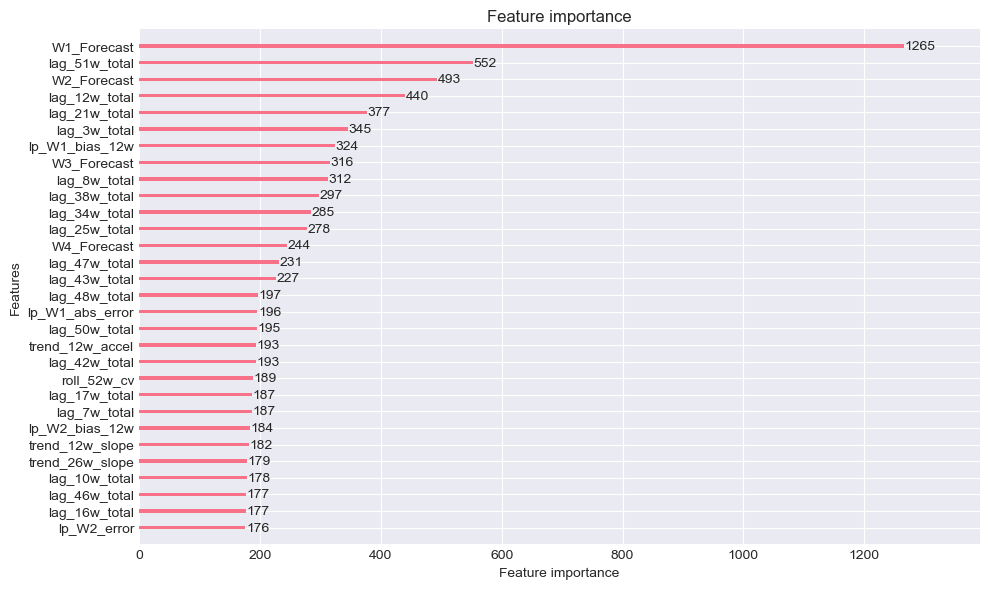

In [124]:
ax = lgb.plot_importance(best_model_trr, max_num_features=30, figsize=(10, 6))
plt.tight_layout()
plt.show()


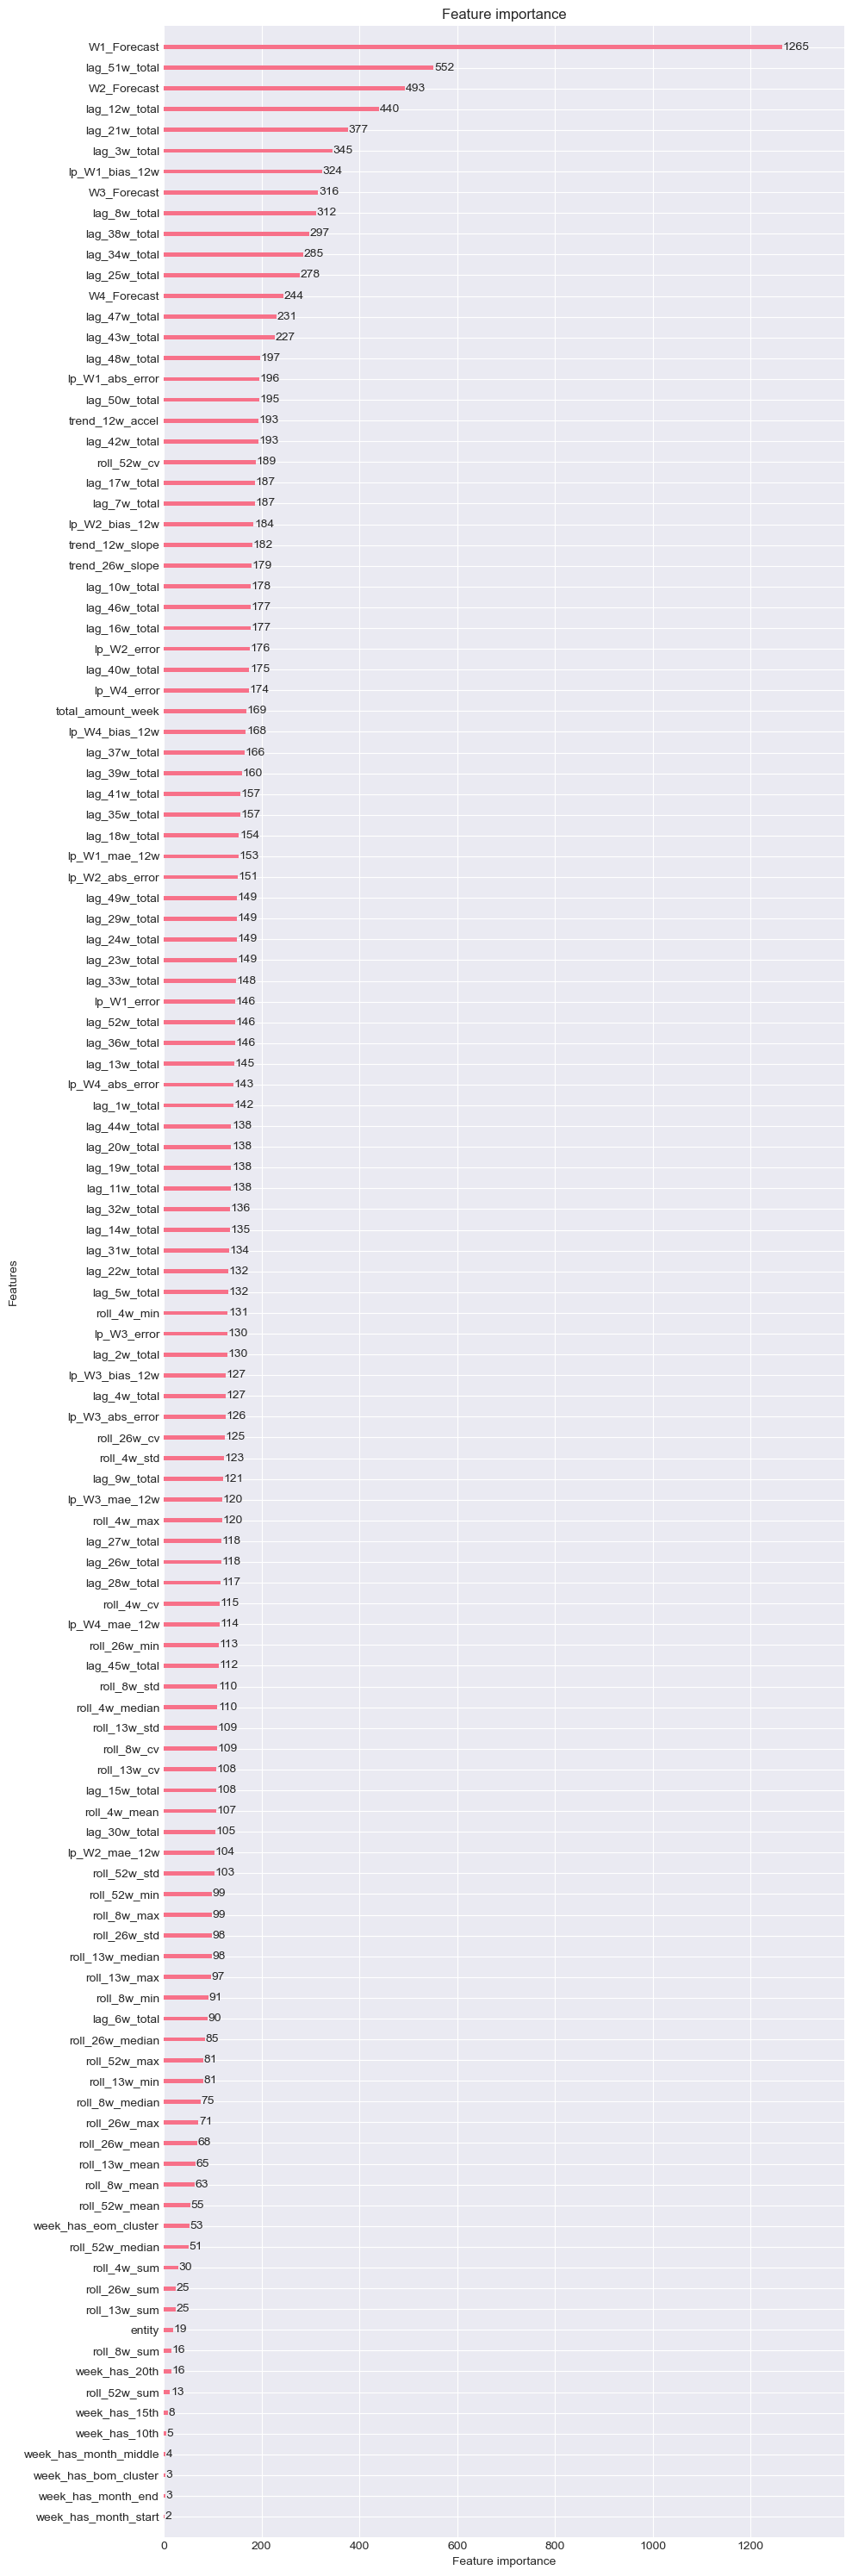

In [125]:
ax = lgb.plot_importance(best_model_trr, max_num_features=140, figsize=(10, 30))
plt.tight_layout()
plt.show()


In [126]:
ax = lgb.plot_importance(best_model_trp, max_num_features=30, figsize=(10, 6))
plt.tight_layout()
plt.show()


## 18. Multi-Horizon Modeling (y_h2 … y_h8)


### 18.1 Containers for models, evals, metrics

In [127]:
# Horizons and groups
HORIZONS = list(range(1, 9))
LIQ_GROUPS = ["TRR", "TRP"]

# Containers
models = { "TRR": {}, "TRP": {} }     # models["TRR"][h] = LightGBM model for horizon h
evals  = { "TRR": {}, "TRP": {} }     # evals["TRR"][h] = {"train": df, "valid": df, "test": df}
metrics = { "TRR": {}, "TRP": {} }    # metrics["TRR"][h] = {"train": {...}, "valid": {...}, "test": {...}}

# Hybrid containers (TRP only, horizons 1–4)
hybrid_alphas = {}          # hybrid_alphas[h] = (best_alpha, details_dict)
hybrid_weekly = {}          # hybrid_weekly[(h, "valid"/"test")] = weekly dataframe


### 18.2 Wrapper: train + eval for one LG and one horizon

In [128]:
def run_horizon_for_lg(
    df_lg: pd.DataFrame,
    lg: str,
    horizon: int,
    base_feature_cols,
    extra_feature_cols=None,
    best_params=None,
):
    """
    Trains a model for one liquidity group (TRR/TRP) and one horizon (1..8),
    builds eval dict (train/valid/test), and computes entity-level metrics.

    Returns:
      model        : LightGBM model
      eval_dict    : {"train": df, "valid": df, "test": df}
      split_metrics: {"train": {mae, rmse, wape}, "valid": {...}, "test": {...}}
    """
    target_col = f"y_h{horizon}"

    # 1) Train model
    model, val_metrics, best_iter = train_lgb_once(
        df_lg=df_lg,
        base_feature_cols=base_feature_cols,
        extra_feature_cols=extra_feature_cols,
        params=best_params,
        target_col=target_col,
    )

    # 2) Build eval dict (horizon-aware; uses lp_w{h} and ml_h{h})
    eval_dict = build_eval_dict(
        df_lg=df_lg,
        model=model,
        base_feature_cols=base_feature_cols,
        extra_feature_cols=extra_feature_cols,
        target_col=target_col,
        horizon=horizon,
        ml_col_name=f"ml_h{horizon}",
    )

    # 3) Compute entity-level metrics per split (based on row-level actual vs ml_h{h})
    split_metrics = {}
    for split_name in ["train", "valid", "test"]:
        df_split = eval_dict[split_name]
        mae, rmse, wape_val = eval_metrics(df_split["actual"], df_split[f"ml_h{horizon}"])
        split_metrics[split_name] = {
            "mae": mae,
            "rmse": rmse,
            "wape": wape_val,
        }

    print(f"[{lg}] Horizon {horizon} – done. VALID WAPE: {split_metrics['valid']['wape']:.4f}")

    return model, eval_dict, split_metrics


### 18.3 Train all 16 models (TRR & TRP, horizons 1–8)

In [129]:
# === TRAIN ALL HORIZONS FOR TRR & TRP ===

for h in HORIZONS:
    print(f"\n=== Training TRR – Horizon {h} ===")
    model_h, eval_h, metrics_h = run_horizon_for_lg(
        df_lg=trr_df,
        lg="TRR",
        horizon=h,
        base_feature_cols=feature_cols,
        extra_feature_cols=None,
        best_params=best_params_trr,   # tuned on H1, reused for all horizons
    )
    models["TRR"][h]  = model_h
    evals["TRR"][h]   = eval_h
    metrics["TRR"][h] = metrics_h

for h in HORIZONS:
    print(f"\n=== Training TRP – Horizon {h} ===")
    model_h, eval_h, metrics_h = run_horizon_for_lg(
        df_lg=trp_df,
        lg="TRP",
        horizon=h,
        base_feature_cols=feature_cols,
        extra_feature_cols=trp_extra_features,   # if you have TRP-specific features
        best_params=best_params_trp,
    )
    models["TRP"][h]  = model_h
    evals["TRP"][h]   = eval_h
    metrics["TRP"][h] = metrics_h



=== Training TRR – Horizon 1 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	train's l1: 552130	valid's l1: 1.54794e+06
[TRR] Horizon 1 – done. VALID WAPE: 0.2170

=== Training TRR – Horizon 2 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	train's l1: 614701	valid's l1: 1.67156e+06
[TRR] Horizon 2 – done. VALID WAPE: 0.2342

=== Training TRR – Horizon 3 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[168]	train's l1: 555404	valid's l1: 1.68451e+06
[TRR] Horizon 3 – done. VALID WAPE: 0.2356

=== Training TRR – Horizon 4 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	train's l1: 592652	valid's l1: 1.73486e+06
[TRR] Horizon 4 – done. VALID WAPE: 0.2449

=== Training TRR – Horizon 5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, b

### 18.4 ConsoEurope LP vs ML WAPE per horizon

In [130]:
def report_conso_wape_for_lg(evals_lg, lg: str, horizon: int):
    """
    Prints ConsoEurope WAPE for LP vs ML for a given LG and horizon.
    For horizons > 4, LP will be NaN (no LP baseline).
    """
    eval_h = evals_lg[horizon]   # dict with keys train/valid/test

    _, val_lp_wape, val_ml_wape = conso_weekly_report(
        eval_h["valid"],
        horizon=horizon,
    )
    _, test_lp_wape, test_ml_wape = conso_weekly_report(
        eval_h["test"],
        horizon=horizon,
    )

    print(
        f"{lg} – Horizon {horizon} | VALID WAPE – LP vs ML: "
        f"{val_lp_wape:.4f} vs {val_ml_wape:.4f}"
    )
    print(
        f"{lg} – Horizon {horizon} | TEST  WAPE – LP vs ML: "
        f"{test_lp_wape:.4f} vs {test_ml_wape:.4f}"
    )


print("\n=== ConsoEurope WAPE per horizon (TRR) ===")
for h in HORIZONS:
    report_conso_wape_for_lg(evals["TRR"], "TRR", horizon=h)

print("\n=== ConsoEurope WAPE per horizon (TRP) ===")
for h in HORIZONS:
    report_conso_wape_for_lg(evals["TRP"], "TRP", horizon=h)



=== ConsoEurope WAPE per horizon (TRR) ===
TRR – Horizon 1 | VALID WAPE – LP vs ML: 0.2663 vs 0.0963
TRR – Horizon 1 | TEST  WAPE – LP vs ML: 0.2405 vs 0.1100
TRR – Horizon 2 | VALID WAPE – LP vs ML: 0.3765 vs 0.1136
TRR – Horizon 2 | TEST  WAPE – LP vs ML: 0.3114 vs 0.1228
TRR – Horizon 3 | VALID WAPE – LP vs ML: 0.5061 vs 0.1040
TRR – Horizon 3 | TEST  WAPE – LP vs ML: 0.4492 vs 0.1039
TRR – Horizon 4 | VALID WAPE – LP vs ML: 0.5673 vs 0.1087
TRR – Horizon 4 | TEST  WAPE – LP vs ML: 0.5062 vs 0.1210
TRR – Horizon 5 | VALID WAPE – LP vs ML: 1.0000 vs 0.1165
TRR – Horizon 5 | TEST  WAPE – LP vs ML: 1.0000 vs 0.1109
TRR – Horizon 6 | VALID WAPE – LP vs ML: 1.0000 vs 0.1149
TRR – Horizon 6 | TEST  WAPE – LP vs ML: 1.0000 vs 0.1089
TRR – Horizon 7 | VALID WAPE – LP vs ML: 1.0000 vs 0.1177
TRR – Horizon 7 | TEST  WAPE – LP vs ML: 1.0000 vs 0.1203
TRR – Horizon 8 | VALID WAPE – LP vs ML: 1.0000 vs 0.1175
TRR – Horizon 8 | TEST  WAPE – LP vs ML: 1.0000 vs 0.1235

=== ConsoEurope WAPE per ho

### 18.5 Weekly WAPE reports (LP vs ML) per horizon

In [131]:
weekly_reports = { "TRR": {}, "TRP": {} }

for h in HORIZONS:
    print(f"\n=== Weekly LP vs ML – TRR, Horizon {h} ===")
    trr_valid_weekly_h = weekly_wape_report(evals["TRR"][h]["valid"], lg="TRR", horizon=h)
    trr_test_weekly_h  = weekly_wape_report(evals["TRR"][h]["test"],  lg="TRR", horizon=h)
    weekly_reports["TRR"][(h, "valid")] = trr_valid_weekly_h
    weekly_reports["TRR"][(h, "test")]  = trr_test_weekly_h
    #print(weekly_reports["TRR"][(h, "test")])

    print(f"\n=== Weekly LP vs ML – TRP, Horizon {h} ===")
    trp_valid_weekly_h = weekly_wape_report(evals["TRP"][h]["valid"], lg="TRP", horizon=h)
    trp_test_weekly_h  = weekly_wape_report(evals["TRP"][h]["test"],  lg="TRP", horizon=h)
    weekly_reports["TRP"][(h, "valid")] = trp_valid_weekly_h
    weekly_reports["TRP"][(h, "test")]  = trp_test_weekly_h
    #print(weekly_reports["TRP"][(h, "test")])



=== Weekly LP vs ML – TRR, Horizon 1 ===

=== Weekly LP vs ML – TRP, Horizon 1 ===

=== Weekly LP vs ML – TRR, Horizon 2 ===

=== Weekly LP vs ML – TRP, Horizon 2 ===

=== Weekly LP vs ML – TRR, Horizon 3 ===

=== Weekly LP vs ML – TRP, Horizon 3 ===

=== Weekly LP vs ML – TRR, Horizon 4 ===

=== Weekly LP vs ML – TRP, Horizon 4 ===

=== Weekly LP vs ML – TRR, Horizon 5 ===

=== Weekly LP vs ML – TRP, Horizon 5 ===

=== Weekly LP vs ML – TRR, Horizon 6 ===

=== Weekly LP vs ML – TRP, Horizon 6 ===

=== Weekly LP vs ML – TRR, Horizon 7 ===

=== Weekly LP vs ML – TRP, Horizon 7 ===

=== Weekly LP vs ML – TRR, Horizon 8 ===

=== Weekly LP vs ML – TRP, Horizon 8 ===


In [132]:
# save TRR/TRP horizon 1 weekly reports
# weekly_reports["TRR"][(1, "test")].to_csv("TRR_h1_test_weekly_LP_ML.csv", index=False)
# weekly_reports["TRP"][(1, "test")].to_csv("TRP_h1_test_weekly_LP_ML.csv", index=False)


### 18.6 TRP Hybrid (LP + ML) for horizons 1–4

In [133]:
# === HYBRID LP+ML FOR TRP (HORIZONS 1–4) ===

for h in range(1, 5):  # only where LP exists
    print(f"\n=== Tuning hybrid alpha for TRP – Horizon {h} ===")

    # 1) Tune alpha using TS-CV on TRAIN+VALID for this horizon
    best_alpha_h, details_h = tune_alpha_for_trp_ts_cv(
        eval_trp_tuned=evals["TRP"][h],
        horizon=h,
    )
    hybrid_alphas[h] = (best_alpha_h, details_h)

    print(f"Best alpha for TRP (H{h}, TS-CV): {best_alpha_h}")
    print(f"Mean WAPE across folds: {details_h['mean_wape']:.4f}")
    print(f"Std  WAPE across folds: {details_h['std_wape']:.4f}")

    # 2) Apply hybrid on VALID and TEST
    trp_valid_hybrid_h = apply_hybrid_trp(evals["TRP"][h]["valid"], best_alpha_h, horizon=h)
    trp_test_hybrid_h  = apply_hybrid_trp(evals["TRP"][h]["test"],  best_alpha_h, horizon=h)

    evals["TRP"][h]["valid"] = trp_valid_hybrid_h
    evals["TRP"][h]["test"]  = trp_test_hybrid_h

    # 3) ConsoEurope WAPE – LP vs ML vs HYB
    w_lp_val  = conso_weekly_wape_from_eval(evals["TRP"][h]["valid"],  type='lp',  horizon=h)
    w_ml_val  = conso_weekly_wape_from_eval(evals["TRP"][h]["valid"],  type='ml',  horizon=h)
    w_hyb_val = conso_weekly_wape_from_eval(trp_valid_hybrid_h,       type='hyb', horizon=h)

    w_lp_test  = conso_weekly_wape_from_eval(evals["TRP"][h]["test"], type='lp',  horizon=h)
    w_ml_test  = conso_weekly_wape_from_eval(evals["TRP"][h]["test"], type='ml',  horizon=h)
    w_hyb_test = conso_weekly_wape_from_eval(trp_test_hybrid_h,       type='hyb', horizon=h)

    print(
        f"TRP H{h} VALID WAPE  - LP:{w_lp_val:.3f}  ML:{w_ml_val:.3f}  HYB:{w_hyb_val:.3f}"
    )
    print(
        f"TRP H{h} TEST  WAPE  - LP:{w_lp_test:.3f} ML:{w_ml_test:.3f} HYB:{w_hyb_test:.3f}"
    )

    # 4) Weekly LP vs ML vs HYB report
    trp_valid_weekly_hyb_h = weekly_wape_report(trp_valid_hybrid_h, lg="TRP", horizon=h)
    trp_test_weekly_hyb_h  = weekly_wape_report(trp_test_hybrid_h,  lg="TRP", horizon=h)

    hybrid_weekly[(h, "valid")] = trp_valid_weekly_hyb_h
    hybrid_weekly[(h, "test")]  = trp_test_weekly_hyb_h

    # Optional: save to CSV
    trp_valid_weekly_hyb_h.to_csv(f"TRP_h{h}_validation_LP_ML_HYB.csv", index=False)
    trp_test_weekly_hyb_h.to_csv(f"TRP_h{h}_test_LP_ML_HYB.csv", index=False)



=== Tuning hybrid alpha for TRP – Horizon 1 ===
Best alpha for TRP (H1, TS-CV): 0.5
Mean WAPE across folds: 0.6013
Std  WAPE across folds: 0.5191
TRP H1 VALID WAPE  - LP:0.286  ML:0.193  HYB:0.225
TRP H1 TEST  WAPE  - LP:0.159 ML:0.173 HYB:0.140

=== Tuning hybrid alpha for TRP – Horizon 2 ===
Best alpha for TRP (H2, TS-CV): 0.5
Mean WAPE across folds: 0.5256
Std  WAPE across folds: 0.0740
TRP H2 VALID WAPE  - LP:0.278  ML:0.208  HYB:0.219
TRP H2 TEST  WAPE  - LP:0.162 ML:0.224 HYB:0.141

=== Tuning hybrid alpha for TRP – Horizon 3 ===
Best alpha for TRP (H3, TS-CV): 0.5
Mean WAPE across folds: 0.6374
Std  WAPE across folds: 0.1798
TRP H3 VALID WAPE  - LP:0.303  ML:0.225  HYB:0.230
TRP H3 TEST  WAPE  - LP:0.210 ML:0.278 HYB:0.185

=== Tuning hybrid alpha for TRP – Horizon 4 ===
Best alpha for TRP (H4, TS-CV): 0.5
Mean WAPE across folds: 0.3184
Std  WAPE across folds: 0.1468
TRP H4 VALID WAPE  - LP:0.350  ML:0.233  HYB:0.253
TRP H4 TEST  WAPE  - LP:0.289 ML:0.316 HYB:0.235


## 19. Reporting

### 19.1 ConsoEurope LP/ML WAPE

In [134]:
def conso_lp_ml_wape_for_lg(
    evals_lg: dict,
    lg: str,
    horizon: int,
    split: str = "valid",
):
    """
    ConsoEurope WAPE for LP vs ML for one liquidity group and horizon.
    Returns (weekly_df, lp_wape, ml_wape).
    """
    df_split = evals_lg[horizon][split]
    weekly, lp_wape, ml_wape = conso_weekly_report(
        df_split,
        horizon=horizon
    )
    return weekly, float(lp_wape), float(ml_wape)


In [135]:
def conso_net_wape(
    evals_trr: dict,
    evals_trp: dict,
    hybrid_weekly: dict,
    horizon: int,
    split: str = "valid",
):
    """
    Compute ConsoEurope WAPE for NET = TRR + TRP.

    Returns:
      lp_net_wape, ml_net_wape, hyb_net_wape (hyb may be NaN for h>4 or if no hybrid).
    """
    # 1) TRR weekly aggregates
    weekly_trr, _, _ = conso_weekly_report(
        evals_trr[horizon][split],
        horizon=horizon
    )  # columns: target_week_start, actual_sum, lp_sum, ml_sum

    weekly_trr = weekly_trr.rename(
        columns={
            "actual_sum": "actual_trr",
            "lp_sum": "lp_trr",
            "ml_sum": "ml_trr",
        }
    )

    # 2) TRP weekly aggregates
    weekly_trp, _, _ = conso_weekly_report(
        evals_trp[horizon][split],
        horizon=horizon
    )
    weekly_trp = weekly_trp.rename(
        columns={
            "actual_sum": "actual_trp",
            "lp_sum": "lp_trp",
            "ml_sum": "ml_trp",
        }
    )

    # 3) Merge TRR + TRP per week (outer just in case)
    net = weekly_trr.merge(
        weekly_trp,
        on="week_start",
        how="outer",
    ).fillna(0.0)

    # 4) Net LP and ML
    net["actual_net"] = net["actual_trr"] + net["actual_trp"]
    net["lp_net"] = net["lp_trr"] + net["lp_trp"]
    net["ml_net"] = net["ml_trr"] + net["ml_trp"]

    # LP / ML NET WAPE
    denom = net["actual_net"].abs().sum() + 1e-6
    lp_net_wape = (net["actual_net"] - net["lp_net"]).abs().sum() / denom
    ml_net_wape = (net["actual_net"] - net["ml_net"]).abs().sum() / denom

    # 5) Hybrid NET: TRR = ML, TRP = HYB_TRP (if available)
    key = (horizon, split)
    if key in hybrid_weekly:
        # hybrid_weekly[(h, split)] is a TRP weekly report with hyb_sum
        weekly_hyb_trp = hybrid_weekly[key][["week_start", "hyb_sum"]].copy()

        net_hyb = net.merge(
            weekly_hyb_trp,
            on="week_start",
            how="left",
        ).fillna({"hyb_sum": 0.0})

        net_hyb["pred_net_hyb"] = net_hyb["ml_trr"] + net_hyb["hyb_sum"]

        denom_h = net_hyb["actual_net"].abs().sum() + 1e-6
        hyb_net_wape = (net_hyb["actual_net"] - net_hyb["pred_net_hyb"]).abs().sum() / denom_h
    else:
        hyb_net_wape = np.nan

    return float(lp_net_wape), float(ml_net_wape), float(hyb_net_wape)


In [136]:
def build_conso_summary_all(
    evals: dict,
    hybrid_weekly: dict,
    horizons=None,
    splits=("valid", "test"),
):
    """
    Builds a summary table with ConsoEurope WAPE per horizon, per split,
    for scopes: TRR, TRP, NET.

    Columns:
      - horizon
      - split
      - scope  (TRR / TRP / NET)
      - lp_wape
      - ml_wape
      - hyb_wape  (for TRR NaN, for TRP only if hybrid exists, for NET uses TRP hybrid)
    """
    if horizons is None:
        horizons = HORIZONS

    rows = []

    for h in horizons:
        for split in splits:
            # --- TRR ---
            _, trr_lp, trr_ml = conso_lp_ml_wape_for_lg(
                evals["TRR"],
                lg="TRR",
                horizon=h,
                split=split,
            )
            rows.append(
                dict(
                    horizon=h,
                    split=split,
                    scope="TRR",
                    lp_wape=trr_lp,
                    ml_wape=trr_ml,
                    hyb_wape=np.nan,  # no hybrid model for TRR
                )
            )

            # --- TRP ---
            _, trp_lp, trp_ml = conso_lp_ml_wape_for_lg(
                evals["TRP"],
                lg="TRP",
                horizon=h,
                split=split,
            )

            key = (h, split)
            if key in hybrid_weekly:
                weekly_trp_hyb = hybrid_weekly[key]
                # hyb WAPE at Conso level from weekly TRP hyb sums
                hyb_wape_trp = (
                    (weekly_trp_hyb["actual_sum"] - weekly_trp_hyb["hyb_sum"]).abs().sum()
                    / (weekly_trp_hyb["actual_sum"].abs().sum() + 1e-6)
                )
            else:
                hyb_wape_trp = np.nan

            rows.append(
                dict(
                    horizon=h,
                    split=split,
                    scope="TRP",
                    lp_wape=trp_lp,
                    ml_wape=trp_ml,
                    hyb_wape=float(hyb_wape_trp),
                )
            )

            # --- NET (TRR + TRP) ---
            lp_net, ml_net, hyb_net = conso_net_wape(
                evals_trr=evals["TRR"],
                evals_trp=evals["TRP"],
                hybrid_weekly=hybrid_weekly,
                horizon=h,
                split=split,
            )

            rows.append(
                dict(
                    horizon=h,
                    split=split,
                    scope="NET",
                    lp_wape=float(lp_net),
                    ml_wape=float(ml_net),
                    hyb_wape=float(hyb_net),
                )
            )

    summary_df = pd.DataFrame(rows).sort_values(["scope", "split", "horizon"])
    return summary_df


In [137]:
conso_summary = build_conso_summary_all(evals, hybrid_weekly)
conso_summary


horizon  split scope   lp_wape   ml_wape  hyb_wape
5         1   test   NET  0.486814  0.302760  0.256745
11        2   test   NET  0.599755  0.407293  0.332362
17        3   test   NET  0.830456  0.452980  0.355362
23        4   test   NET  0.870735  0.424522  0.361347
29        5   test   NET  1.000000  0.547730       NaN
35        6   test   NET  1.000000  0.487026       NaN
41        7   test   NET  1.000000  0.565758       NaN
47        8   test   NET  1.000000  0.501667       NaN
2         1  valid   NET  0.844786  0.404693  0.400564
8         2  valid   NET  0.656058  0.406218  0.413871
14        3  valid   NET  0.974329  0.387931  0.438968
20        4  valid   NET  1.027672  0.447467  0.521867
26        5  valid   NET  1.000000  0.584802       NaN
32        6  valid   NET  1.000000  0.505948       NaN
38        7  valid   NET  1.000000  0.530011       NaN
44        8  valid   NET  1.000000  0.547788       NaN
4         1   test   TRP  0.158964  0.172638  0.139853
10        2   test   TRP  0.161898  0.224469  0.141014
16        3   test   TRP  0.210265  0.277724  0.185255
22        4   test   TRP  0.289192  0.315806  0.235197
28        5   test   TRP  1.000000  0.424373       NaN
34        6   test   TRP  1.000000  0.394629       NaN
40        7   test   TRP  1.000000  0.419852       NaN
46        8   test   TRP  1.000000  0.393740       NaN
1         1  valid   TRP  0.285778  0.192879  0.225131
7         2  valid   TRP  0.278274  0.208050  0.219407
13        3  valid   TRP  0.303291  0.224570  0.230279
19        4  valid   TRP  0.349836  0.233047  0.253450
25        5  valid   TRP  1.000000  0.292656       NaN
31        6  valid   TRP  1.000000  0.270836       NaN
37        7  valid   TRP  1.000000  0.290754       NaN
43        8  valid   TRP  1.000000  0.271185       NaN
3         1   test   TRR  0.240478  0.110000       NaN
9         2   test   TRR  0.311438  0.122765       NaN
15        3   test   TRR  0.449164  0.103930       NaN
21        4   test   TRR  0.506174  0.121040       NaN
27        5   test   TRR  1.000000  0.110938       NaN
33        6   test   TRR  1.000000  0.108867       NaN
39        7   test   TRR  1.000000  0.120326       NaN
45        8   test   TRR  1.000000  0.123474       NaN
0         1  valid   TRR  0.266349  0.096340       NaN
6         2  valid   TRR  0.376467  0.113554       NaN
12        3  valid   TRR  0.506085  0.103980       NaN
18        4  valid   TRR  0.567312  0.108749       NaN
24        5  valid   TRR  1.000000  0.116535       NaN
30        6  valid   TRR  1.000000  0.114877       NaN
36        7  valid   TRR  1.000000  0.117730       NaN
42        8  valid   TRR  1.000000  0.117516       NaN

In [138]:
conso_summary.to_excel("TCF_conso_summary_by_horizon.xlsx", index=False)


### 19.2 Weekly × LG × Horizon report

In [139]:
def build_full_weekly_horizon_report(
    evals: dict,
    hybrid_weekly: dict,
    horizons=None,
    splits=("valid", "test"),
):
    """
    Builds a single dataframe with weekly-level metrics across:
      - liquidity group (TRR, TRP)
      - split (valid, test)
      - horizon (1..8)
    Columns:
      target_week_start, iso_week, liquidity_group, split, horizon,
      actual_sum, lp_sum, ml_sum, hyb_sum (where available),
      lp_wape, ml_wape, hyb_wape, ml_better, hyb_better_than_lp,
      ml_improv_vs_lp_pct, hyb_improv_vs_lp_pct,
      *_M versions of sums.
    """
    if horizons is None:
        horizons = HORIZONS

    all_rows = []

    for lg in ["TRR", "TRP"]:
        for h in horizons:
            for split in splits:
                df_split = evals[lg][h][split]

                # If TRP + hybrid exists for this horizon/split, we must ensure
                # ml_h{h}_trp_hybrid column is present in df_split.
                # That was done in apply_hybrid_trp and stored in eval_trp_tuned;
                # here we assume evals["TRP"][h][split] already includes that column
                # for horizons 1..4 where hybrid was applied.

                weekly = weekly_wape_report(df_split, lg=lg, horizon=h)
                weekly["split"] = split
                weekly["horizon"] = h

                all_rows.append(weekly)

    full_weekly = pd.concat(all_rows, ignore_index=True)
    return full_weekly


In [140]:
full_weekly_report = build_full_weekly_horizon_report(evals, hybrid_weekly)
full_weekly_report.tail()


week_start  iso_week    actual_sum  lp_sum        ml_sum liquidity_group  \
1323 2025-08-04        32 -1.177288e+08     0.0 -8.478852e+07             TRP   
1324 2025-08-11        33 -2.640712e+07     0.0 -4.261940e+07             TRP   
1325 2025-08-18        34 -2.995144e+07     0.0 -6.126582e+07             TRP   
1326 2025-08-25        35 -4.895574e+07     0.0 -4.995614e+07             TRP   
1327 2025-09-01        36 -6.993912e+07     0.0 -7.660212e+07             TRP   

      lp_wape   ml_wape  ml_better  improvement_pct  actual_sum_M  lp_sum_M  \
1323      1.0  0.279798       True        72.020137   -117.728789       0.0   
1324      1.0  0.613936       True        38.606340    -26.407116       0.0   
1325      1.0  1.045505      False        -4.550489    -29.951441       0.0   
1326      1.0  0.020435       True        97.956413    -48.955737       0.0   
1327      1.0  0.095269       True        90.473047    -69.939118       0.0   

       ml_sum_M split  horizon  hyb_sum  hyb_wape hyb_better_than_lp  \
1323 -84.788520  test        8      NaN       NaN                NaN   
1324 -42.619402  test        8      NaN       NaN                NaN   
1325 -61.265819  test        8      NaN       NaN                NaN   
1326 -49.956142  test        8      NaN       NaN                NaN   
1327 -76.602122  test        8      NaN       NaN                NaN   

      hyb_improv_vs_lp_pct  hyb_sum_M  
1323                   NaN        NaN  
1324                   NaN        NaN  
1325                   NaN        NaN  
1326                   NaN        NaN  
1327                   NaN        NaN

In [141]:
full_weekly_report.to_excel(
    "TCF_weekly_by_horizon_LP_ML_HYB.xlsx",
    index=False,
)


### 19.3. Conso Pivot Table

In [142]:
def build_pivot_report(conso_summary: pd.DataFrame):
    """
    Takes the long-format conso_summary and returns:
    A pivot table per split (VALID, TEST):
      index = (scope, metric: LP/ML/HYB)
      columns = horizon 1..8
    """
    pivots = {}

    for split in conso_summary["split"].unique():
        df_s = conso_summary[conso_summary["split"] == split].copy()

        # Melt metrics into rows
        df_long = df_s.melt(
            id_vars=["scope", "split", "horizon"],
            value_vars=["lp_wape", "ml_wape", "hyb_wape"],
            var_name="metric",
            value_name="wape",
        )

        # Clean metric names: lp_wape → LP, ml_wape → ML, hyb_wape → HYB
        df_long["metric"] = df_long["metric"].str.replace("_wape", "").str.upper()

        # Build pivot
        slide_pivot = df_long.pivot_table(
            index=["scope", "metric"],
            columns="horizon",
            values="wape",
            aggfunc="first"
        ).sort_index()

        pivots[split] = slide_pivot

    return pivots


In [143]:
slide_tables = build_pivot_report(conso_summary)

slide_tables["valid"]    # VALID summary pivot
slide_tables["test"]     # TEST summary pivot


horizon              1         2         3         4         5         6  \
scope metric                                                               
NET   HYB     0.256745  0.332362  0.355362  0.361347       NaN       NaN   
      LP      0.486814  0.599755  0.830456  0.870735  1.000000  1.000000   
      ML      0.302760  0.407293  0.452980  0.424522  0.547730  0.487026   
TRP   HYB     0.139853  0.141014  0.185255  0.235197       NaN       NaN   
      LP      0.158964  0.161898  0.210265  0.289192  1.000000  1.000000   
      ML      0.172638  0.224469  0.277724  0.315806  0.424373  0.394629   
TRR   LP      0.240478  0.311438  0.449164  0.506174  1.000000  1.000000   
      ML      0.110000  0.122765  0.103930  0.121040  0.110938  0.108867   

horizon              7         8  
scope metric                      
NET   HYB          NaN       NaN  
      LP      1.000000  1.000000  
      ML      0.565758  0.501667  
TRP   HYB          NaN       NaN  
      LP      1.000000  1.000000  
      ML      0.419852  0.393740  
TRR   LP      1.000000  1.000000  
      ML      0.120326  0.123474

In [144]:
with pd.ExcelWriter("TCF_slide_ready_summary.xlsx") as writer:
    slide_tables["valid"].to_excel(writer, sheet_name="VALID")
    slide_tables["test"].to_excel(writer, sheet_name="TEST")


### 19.4 Top/Bottom Weeks Analysis

In [145]:
def build_top_bottom_weeks(full_weekly_report: pd.DataFrame, top_n=5):
    """
    Returns two DataFrames:
      best_weeks: per (horizon, liquidity_group, split)
      worst_weeks: per (horizon, liquidity_group, split)
    Based on ML improvement vs LP.
    If hybrid exists for TRP, hybrid is also included.
    """
    rows_best = []
    rows_worst = []

    for (lg, h, split), df_grp in full_weekly_report.groupby(
        ["liquidity_group", "horizon", "split"]
    ):
        df = df_grp.copy()

        # Metric for sorting
        df["ml_gain"] = df["lp_wape"] - df["ml_wape"]

        if "hyb_wape" in df.columns:
            df["hyb_gain"] = df["lp_wape"] - df["hyb_wape"]
        else:
            df["hyb_gain"] = np.nan

        # ----- TOP (best) -----
        best = df.sort_values("ml_gain", ascending=False).head(top_n)
        best["rank_type"] = "BEST"
        rows_best.append(best)

        # ----- BOTTOM (worst) -----
        worst = df.sort_values("ml_gain", ascending=True).head(top_n)
        worst["rank_type"] = "WORST"
        rows_worst.append(worst)

    best_weeks = pd.concat(rows_best, ignore_index=True)
    worst_weeks = pd.concat(rows_worst, ignore_index=True)

    return best_weeks, worst_weeks


In [146]:
best_weeks, worst_weeks = build_top_bottom_weeks(full_weekly_report)

best_weeks.head()
worst_weeks.head()


week_start  iso_week    actual_sum      lp_sum        ml_sum  \
0 2025-07-14        29 -1.273906e+07  -6003740.0 -2.463928e+07   
1 2025-08-11        33 -2.617194e+07 -32027104.0 -4.200923e+07   
2 2025-07-07        28 -1.034541e+08 -96893890.0 -7.289289e+07   
3 2025-05-26        22 -2.194445e+07 -19732457.0 -2.839223e+07   
4 2025-03-03        10 -1.013717e+08 -98878411.0 -7.992854e+07   

  liquidity_group   lp_wape   ml_wape  ml_better  improvement_pct  ...  split  \
0             TRP  0.528714  0.934152      False       -76.683639  ...   test   
1             TRP  0.223719  0.605125      False      -170.483359  ...   test   
2             TRP  0.063412  0.295408      False      -365.853030  ...   test   
3             TRP  0.100800  0.293823      False      -191.489802  ...   test   
4             TRP  0.024596  0.211530      False      -759.994476  ...   test   

   horizon       hyb_sum  hyb_wape  hyb_better_than_lp  hyb_improv_vs_lp_pct  \
0        1 -1.522578e+07  0.195204                True             63.079346   
1        1 -3.672173e+07  0.403096               False            -80.178918   
2        1 -8.482248e+07  0.180095               False           -184.007456   
3        1 -2.394828e+07  0.091314                True              9.410557   
4        1 -8.924508e+07  0.119626               False           -386.349775   

   hyb_sum_M   ml_gain  hyb_gain  rank_type  
0 -15.225776 -0.405438  0.333510      WORST  
1 -36.721734 -0.381406 -0.179376      WORST  
2 -84.822478 -0.231997 -0.116684      WORST  
3 -23.948281 -0.193023  0.009486      WORST  
4 -89.245082 -0.186934 -0.095030      WORST  

[5 rows x 23 columns]

In [147]:
best_weeks.head()

week_start  iso_week    actual_sum      lp_sum        ml_sum  \
0 2025-03-24        13 -5.509251e+07 -15720066.0 -4.930984e+07   
1 2025-06-23        26 -7.719088e+07 -15598605.0 -3.510361e+07   
2 2025-05-05        19 -5.115619e+07 -43682388.0 -4.940034e+07   
3 2025-08-25        35 -3.093263e+07 -26671869.0 -3.276348e+07   
4 2025-08-18        34 -1.142786e+08 -94726870.0 -1.011982e+08   

  liquidity_group   lp_wape   ml_wape  ml_better  improvement_pct  ...  split  \
0             TRP  0.714661  0.104963       True        85.312770  ...   test   
1             TRP  0.797922  0.545236       True        31.667907  ...   test   
2             TRP  0.146098  0.034323       True        76.506083  ...   test   
3             TRP  0.137743  0.059188       True        57.029668  ...   test   
4             TRP  0.171088  0.114461       True        33.098258  ...   test   

   horizon       hyb_sum  hyb_wape  hyb_better_than_lp  hyb_improv_vs_lp_pct  \
0        1 -3.088696e+07  0.439362                True             38.521535   
1        1 -2.514645e+07  0.674230                True             15.501666   
2        1 -4.654136e+07  0.090210                True             38.253042   
3        1 -2.951147e+07  0.045944                True             66.644836   
4        1 -9.776153e+07  0.144533                True             15.521075   

   hyb_sum_M   ml_gain  hyb_gain  rank_type  
0 -30.886958  0.609698  0.275299       BEST  
1 -25.146445  0.252685  0.123691       BEST  
2 -46.541363  0.111774  0.055887       BEST  
3 -29.511467  0.078555  0.091799       BEST  
4 -97.761527  0.056628  0.026555       BEST  

[5 rows x 23 columns]

In [148]:
with pd.ExcelWriter("TCF_top_bottom_weeks.xlsx") as writer:
    best_weeks.to_excel(writer, sheet_name="BEST", index=False)
    worst_weeks.to_excel(writer, sheet_name="WORST", index=False)


### 19.5 Weekly Pivot per LG 

In [149]:
def build_weekly_pivots_by_lg(full_weekly_report: pd.DataFrame):
    """
    For each liquidity_group (TRR / TRP) and split (train/valid/test),
    build a pivot:

      index  = target_week_start (and iso_week as extra column if you want)
      cols   = (horizon, metric) where metric in {LP, ML, HYB}
      values = WAPE

    Returns:
      weekly_pivots: dict[lg][split] -> DataFrame
    """
    weekly_pivots = {}

    # Make sure we don't mutate original
    df_all = full_weekly_report.copy()

    # Normalize metric columns (some horizons/LGs may not have HYB)
    metric_cols_all = [c for c in ["lp_wape", "ml_wape", "hyb_wape"] if c in df_all.columns]

    for lg in df_all["liquidity_group"].unique():
        df_lg = df_all[df_all["liquidity_group"] == lg].copy()
        weekly_pivots[lg] = {}

        for split in df_lg["split"].unique():
            df_s = df_lg[df_lg["split"] == split].copy()

            # Figure out which metrics actually exist in this slice
            metric_cols = [c for c in metric_cols_all if c in df_s.columns]

            if not metric_cols:
                continue  # nothing to pivot on

            # Melt WAPE metrics
            df_long = df_s.melt(
                id_vars=["week_start", "iso_week", "horizon"],
                value_vars=metric_cols,
                var_name="metric",
                value_name="wape",
            )

            # Clean metric names: lp_wape -> LP, ml_wape -> ML, hyb_wape -> HYB
            df_long["metric"] = df_long["metric"].str.replace("_wape", "").str.upper()

            # Pivot: rows = week, cols = (horizon, metric)
            pivot = df_long.pivot_table(
                index="week_start",
                columns=["horizon", "metric"],
                values="wape",
                aggfunc="first"
            )

            # Optional: bring iso_week as a column (taking first per week)
            iso_week_map = df_s.groupby("week_start")["iso_week"].first()
            pivot.insert(0, "iso_week", iso_week_map)

            # Sort columns nicely (horizon ascending, metrics LP/ML/HYB)
            pivot = pivot.sort_index(axis=1, level=[0, 1])

            weekly_pivots[lg][split] = pivot

    return weekly_pivots


In [150]:
weekly_pivots = build_weekly_pivots_by_lg(full_weekly_report)

# Example: TRR VALID
trr_test_week_pivot = weekly_pivots["TRR"]["test"]
trr_test_week_pivot.head()



horizon            1                   2                   3            \
metric            LP        ML        LP        ML        LP        ML   
week_start                                                               
2025-03-03  0.345908  0.103432  0.220100  0.065356  0.044682  0.120114   
2025-03-10  0.217788  0.017827  0.193752  0.245518  0.761096  0.246522   
2025-03-17  0.254818  0.233133  0.691734  0.284108  0.516093  0.010702   
2025-03-24  0.568800  0.251062  0.421902  0.019336  0.265245  0.102907   
2025-03-31  0.333045  0.000339  0.123549  0.207569  0.629541  0.102667   

horizon            4              5              6              7            \
metric            LP        ML   LP        ML   LP        ML   LP        ML   
week_start                                                                    
2025-03-03  0.774297  0.285294  1.0  0.006943  1.0  0.159978  1.0  0.070509   
2025-03-10  0.611465  0.056111  1.0  0.150397  1.0  0.070741  1.0  0.053011   
2025-03-17  0.455557  0.111301  1.0  0.096726  1.0  0.075368  1.0  0.111133   
2025-03-24  0.595407  0.107748  1.0  0.093119  1.0  0.031093  1.0  0.045886   
2025-03-31  0.167789  0.216608  1.0  0.117140  1.0  0.042749  1.0  0.163724   

horizon       8           iso_week  
metric       LP        ML           
week_start                          
2025-03-03  1.0  0.076512       10  
2025-03-10  1.0  0.173260       11  
2025-03-17  1.0  0.059687       12  
2025-03-24  1.0  0.120047       13  
2025-03-31  1.0  0.083838       14

In [151]:
# Example: TRP TEST
trp_test_week_pivot = weekly_pivots["TRP"]["test"]
trp_test_week_pivot.head()


horizon            1                             2                      \
metric           HYB        LP        ML       HYB        LP        ML   
week_start                                                               
2025-03-03  0.119626  0.024596  0.211530  0.020664  0.002239  0.025122   
2025-03-10  0.026096  0.113090  0.145232  0.078781  0.021509  0.116777   
2025-03-17  0.011843  0.190658  0.173955  0.038677  0.327531  0.436533   
2025-03-24  0.439362  0.714661  0.104963  0.068996  0.019397  0.137493   
2025-03-31  0.162238  0.185041  0.143747  0.336308  0.309530  0.374232   

horizon            3                             4  ...              5  \
metric           HYB        LP        ML       HYB  ...        ML   LP   
week_start                                          ...                  
2025-03-03  0.137719  0.165267  0.079967  0.015510  ...  0.410260  1.0   
2025-03-10  0.090924  0.362867  0.217070  0.034430  ...  0.182582  1.0   
2025-03-17  0.059843  0.014805  0.157072  0.481117  ...  0.725057  1.0   
2025-03-24  0.419982  0.310360  0.557039  0.437927  ...  0.315641  1.0   
2025-03-31  0.484706  0.561171  0.401930  0.067154  ...  0.051579  1.0   

horizon                 6              7              8           iso_week  
metric            ML   LP        ML   LP        ML   LP        ML           
week_start                                                                  
2025-03-03  0.135673  1.0  0.333767  1.0  0.267378  1.0  0.091345       10  
2025-03-10  0.506620  1.0  0.265347  1.0  0.259690  1.0  0.574171       11  
2025-03-17  0.305611  1.0  0.083167  1.0  0.309726  1.0  0.235692       12  
2025-03-24  0.147272  1.0  0.519057  1.0  0.203203  1.0  0.011166       13  
2025-03-31  0.606135  1.0  0.223759  1.0  0.077402  1.0  0.191611       14  

[5 rows x 21 columns]

In [152]:
trp_test_week_pivot.shape

(27, 21)

### Weekly Line Chart – WAPE over time (LP vs ML vs HYB)

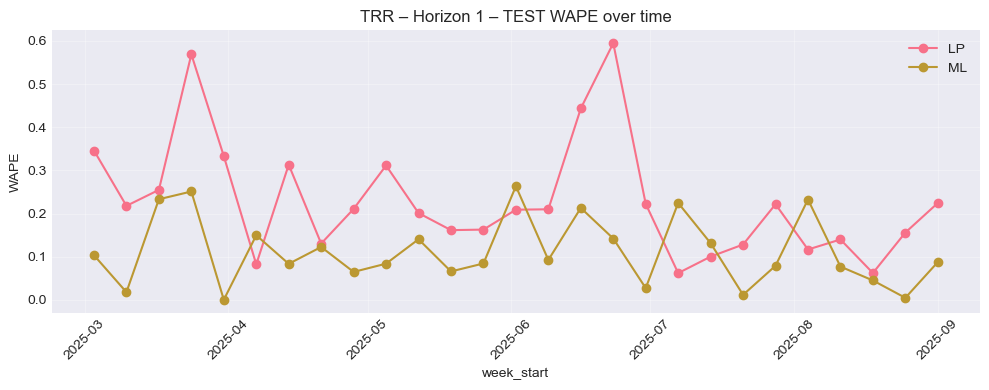

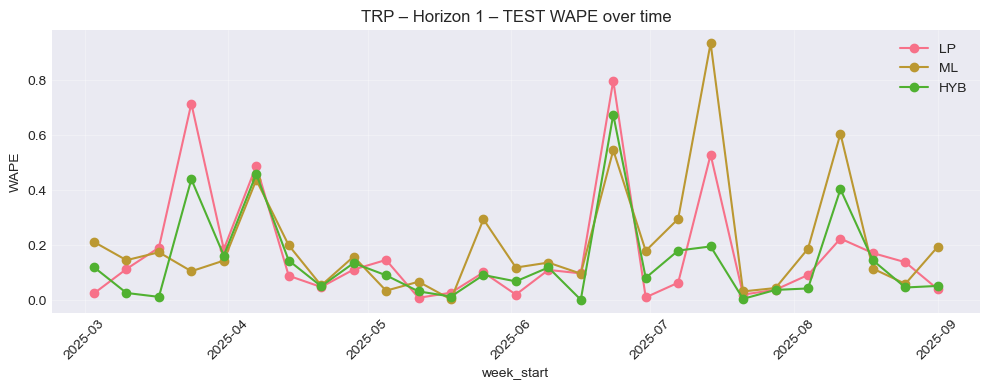

In [153]:
import matplotlib.pyplot as plt

def plot_weekly_wape_line(
    df_full,
    lg="TRR",
    horizon=1,
    split="test",
    use_hybrid=True
):
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["horizon"] == horizon)
        & (df_full["split"] == split)
    ].sort_values("week_start")

    plt.figure(figsize=(10, 4))
    plt.plot(df["week_start"], df["lp_wape"], label="LP", marker="o")
    plt.plot(df["week_start"], df["ml_wape"], label="ML", marker="o")

    if use_hybrid and "hyb_wape" in df.columns and df["hyb_wape"].notna().any():
        plt.plot(df["week_start"], df["hyb_wape"], label="HYB", marker="o")

    plt.xticks(rotation=45)
    plt.ylabel("WAPE")
    plt.xlabel("week_start")
    plt.title(f"{lg} – Horizon {horizon} – {split.upper()} WAPE over time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_weekly_wape_line(full_weekly_report, lg="TRR", horizon=1, split="test")
plot_weekly_wape_line(full_weekly_report, lg="TRP", horizon=1, split="test", use_hybrid=True)


In [154]:
import plotly.express as px

def plot_weekly_wape_line_interactive(
    df_full: pd.DataFrame,
    lg: str = "TRR",
    horizon: int = 1,
    split: str = "test",
    use_hybrid: bool = True,
):
    """
    Interactive Plotly line chart of WAPE over time:
      - one line for LP
      - one line for ML
      - optional line for HYB (for TRP)

    Expects df_full to contain columns:
      week_start, liquidity_group, split, horizon,
      lp_wape, ml_wape, (optionally) hyb_wape
    """
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["horizon"] == horizon)
        & (df_full["split"] == split)
    ].copy()

    df = df.sort_values("week_start")

    # Build a long-format frame for Plotly
    records = []

    for _, row in df.iterrows():
        # LP
        records.append({
            "week_start": row["week_start"],
            "WAPE": row["lp_wape"],
            "model": "LP",
        })
        # ML
        records.append({
            "week_start": row["week_start"],
            "WAPE": row["ml_wape"],
            "model": "ML",
        })
        # HYB (optional)
        if use_hybrid and "hyb_wape" in df.columns and not pd.isna(row.get("hyb_wape", np.nan)):
            records.append({
                "week_start": row["week_start"],
                "WAPE": row["hyb_wape"],
                "model": "HYB",
            })

    plot_df = pd.DataFrame(records)

    if plot_df.empty:
        print("No data available for this combination (lg, horizon, split).")
        return

    fig = px.line(
        plot_df,
        x="week_start",
        y="WAPE",
        color="model",
        markers=True,
        title=f"{lg} – Horizon {horizon} – {split.upper()} WAPE over time",
        hover_data={"model": True, "week_start": True, "WAPE": ":.3f"},
    )

    fig.update_layout(
        xaxis_title="week_start",
        yaxis_title="WAPE",
        hovermode="x unified",
    )

    fig.show()


In [155]:
# TRR, horizon 1, test split
plot_weekly_wape_line_interactive(full_weekly_report, lg="TRR", horizon=1, split="test")


In [156]:
# TRP, horizon 1, test split, with hybrid
plot_weekly_wape_line_interactive(full_weekly_report, lg="TRP", horizon=1, split="test", use_hybrid=True)


In [157]:
import plotly.graph_objects as go


def plot_weekly_wape_interactive_with_horizon(
    df_full: pd.DataFrame,
    lg: str = "TRR",             # "TRR" or "TRP"
    split: str = "test",         # "train" / "valid" / "test"
    horizons=range(1, 9),        # 1..8
    use_hybrid: bool = True,     # Hybrid line only meaningful for TRP H1–H4
):
    """
    Interactive weekly WAPE line chart with a dropdown to switch horizon.

    Expects df_full (full_weekly_report) to contain:
      - week_start (datetime)
      - liquidity_group ("TRR"/"TRP")
      - split ("train"/"valid"/"test")
      - horizon (1..8)
      - lp_wape, ml_wape
      - optionally hyb_wape (for TRP + horizons with hybrid)
    """

    # Color mapping for the three series
    color_map = {
        "LP":  "#7f7f7f",  # grey  - existing LP baseline
        "ML":  "#1f77b4",  # blue  - new ML model
        "HYB": "#69bd66",  # green - advanced hybrid
    }

    # Target WAPE per horizon
    target_lines = {
        1: 0.05,
        2: 0.075,
        3: 0.10,
        4: 0.125,
        5: 0.15,
        6: 0.175,
        7: 0.20,
        8: 0.225,
    }

    # Filter for liquidity group & split
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["split"] == split)
    ].copy()

    if df.empty:
        print(f"No data for lg={lg}, split={split}.")
        return

    df = df.sort_values(["horizon", "week_start"])

    traces = []
    horizons = list(horizons)
    metric_labels = [("lp_wape", "LP"), ("ml_wape", "ML"), ("hyb_wape", "HYB")]
    horizon_subtitles = {}

    # 1) Create LP / ML / HYB traces for each horizon
    for h in horizons:
        subtitle = ""
        df_h = df[df["horizon"] == h].copy()
        df_h = df_h.sort_values("week_start")

        if df_h.empty:
            x_vals = []
        else:
            x_vals = df_h["week_start"]
            
        # Compute variance (actually std dev) of WAPE for the visible slice
        lp_std  = float(df_h["lp_wape"].std(skipna=True)) if "lp_wape" in df_h.columns else None
        ml_std  = float(df_h["ml_wape"].std(skipna=True)) if "ml_wape" in df_h.columns else None
        hyb_std = float(df_h["hyb_wape"].std(skipna=True)) if "hyb_wape" in df_h.columns else None
        
        # Build a subtitle with only the series that exist
        parts = []
        if lp_std is not None:
            parts.append(f"LP σ={lp_std:.3f}")
        if ml_std is not None:
            parts.append(f"ML σ={ml_std:.3f}")
        if hyb_std is not None:
            parts.append(f"HYB σ={hyb_std:.3f}")
        
        subtitle = "  |  ".join(parts)   
        horizon_subtitles[h] = subtitle

        for metric_col, metric_label in metric_labels:
            # HYB handling: only show if requested + column exists
            if metric_col == "hyb_wape":
                if (not use_hybrid) or ("hyb_wape" not in df_h.columns):
                    y_vals = [np.nan] * len(x_vals)
                else:
                    y_vals = df_h[metric_col].values
            else:
                if metric_col in df_h.columns:
                    y_vals = df_h[metric_col].values
                else:
                    y_vals = [np.nan] * len(x_vals)

            traces.append(
                go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode="lines+markers",
                    name=metric_label,
                    line=dict(color=color_map.get(metric_label, "#000000")),
                    marker=dict(color=color_map.get(metric_label, "#000000")),
                    hovertemplate=(
                        "Week: %{x|%Y-%m-%d}"
                        "<br>WAPE: %{y:.3f}"
                        f"<br>Model: {metric_label}"
                        f"<br>Horizon: H{h}"
                        "<extra></extra>"
                    ),
                    visible=(h == horizons[0]),  # only the first horizon visible at start
                )
            )

    n_traces_main = len(traces)
    traces_per_h = 3  # LP, ML, HYB (HYB may be nan but still a trace)

    # 2) Add one target line trace per horizon (constant WAPE)
    target_trace_idx = {}  # horizon -> index in fig.data

    for h in horizons:
        df_h = df[df["horizon"] == h].copy().sort_values("week_start")

        if df_h.empty:
            x_vals = []
        else:
            x_vals = df_h["week_start"].values

        target_val = target_lines.get(h, None)

        if (target_val is not None) and (len(x_vals) > 0):
            t_idx = len(traces)  # next trace index
            target_trace_idx[h] = t_idx
            traces.append(
                go.Scatter(
                    x=x_vals,
                    y=[target_val] * len(x_vals),
                    mode="lines",
                    name="Target WAPE",
                    line=dict(color="#000000", width=2, dash="dash"),
                    hoverinfo="skip",
                    visible=(h == horizons[0]),  # visible only for the first horizon initially
                )
            )

    fig = go.Figure(data=traces)

    # 3) Build dropdown for horizon selection
    buttons = []
    total_traces = len(traces)

    for idx_h, h in enumerate(horizons):
        visible = [False] * total_traces

        # Turn on LP/ML/HYB for this horizon
        start = idx_h * traces_per_h
        end = start + traces_per_h
        for i in range(start, end):
            if i < n_traces_main:
                visible[i] = True

        # Turn on target line for this horizon if it exists
        if h in target_trace_idx:
            visible[target_trace_idx[h]] = True

        sub = horizon_subtitles.get(h)
        buttons.append(
            dict(
                label=f"H{h}",
                method="update",
                args=[
                    {"visible": visible},
                    {
                        "title": f"{lg} – {split.upper()} – Weekly WAPE over time (H{h})"
                        + (f"<br><sup>{sub}</sup>" if {sub} else ""),
                    },
                ],
            )
        )

    # 4) Layout tweaks: bigger height, nice legend, etc.
    initial_h = horizons[0]
    fig.update_layout(
        title={
            "text": f"{lg} – {split.upper()} – Weekly WAPE over time (H{horizons[0]})"
                    + (f"<br><sup>{horizon_subtitles[initial_h]}</sup>" if {horizon_subtitles[initial_h]} else ""),
            "x": 0.5,              # Center horizontally
            "xanchor": "center",
            "y": 0.95,             # Lower the title slightly so it doesn't hit dropdown
            "yanchor": "top",
        },
        xaxis_title="week_start",
        yaxis_title="WAPE",
        hovermode="x unified",
        height=700,  # Increased height
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=0.0,
                y=1.15,
                showactive=True,
                buttons=buttons,
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1.0
        ),
    )

    fig.show()


In [158]:
# TRR – test set – horizons 1..8
plot_weekly_wape_interactive_with_horizon(
    full_weekly_report,
    lg="TRR",
    split="test",
    horizons=range(1, 9), # LP only exist for H1-H4; No Hyb
    use_hybrid=False,   
)



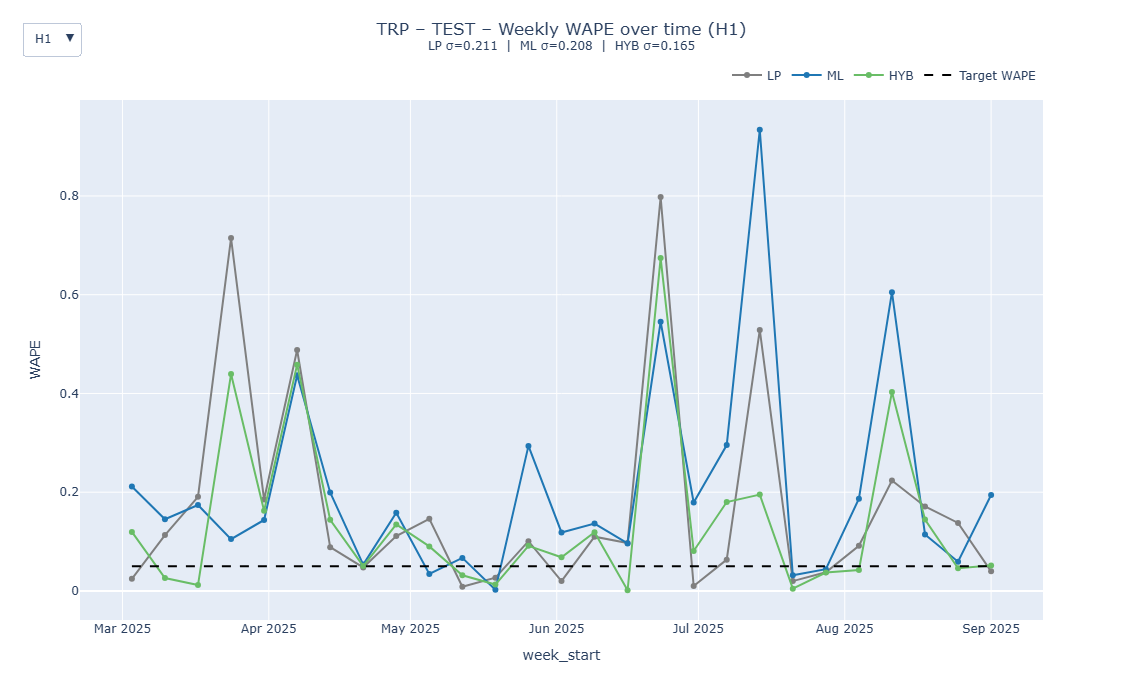

In [159]:
# TRP – test set – horizons 1..4 with HYB 5..8 only ML
plot_weekly_wape_interactive_with_horizon(
    full_weekly_report,
    lg="TRP",
    split="test",
    horizons=range(1, 9),  # LP/HYB only exist for H1-H4
    use_hybrid=True,
)


In [160]:

import plotly.graph_objects as go

def plot_weekly_wape_interactive_multi(
    df_full: pd.DataFrame,
    splits=("test",),          # which splits to allow; usually ("test",) or ("valid","test")
    default_split="test",
    horizons=range(1, 9),      # 1..8
):
    """
    Interactive weekly WAPE line chart with:
      - dropdown to choose Liquidity Group (TRR / TRP)
      - dropdown to choose Horizon (H1..H8)
    HYB can be toggled via the legend (click "HYB").

    Expects df_full to contain:
      - week_start (datetime)
      - liquidity_group ("TRR"/"TRP")
      - split ("train"/"valid"/"test")
      - horizon (1..8)
      - lp_wape, ml_wape
      - optionally hyb_wape (for TRP horizons with hybrid)
    """

    # Ensure we have the requested split(s)
    df = df_full[df_full["split"].isin(splits)].copy()
    if df.empty:
        print("No data for given splits:", splits)
        return

    # Clean basic stuff
    df = df.sort_values(["liquidity_group", "horizon", "week_start"])

    # Unique LGs and horizons present
    lgs = sorted(df["liquidity_group"].unique())
    horizons = list(horizons)

    # We’ll build traces for each (lg, horizon, metric)
    metric_labels = [("lp_wape", "LP"), ("ml_wape", "ML"), ("hyb_wape", "HYB")]

    # Metadata for each trace so we can control visibility
    trace_meta = []
    traces = []

    default_lg = lgs[0]
    default_h  = horizons[0]

    # Build all traces
    for lg in lgs:
        for h in horizons:
            df_lg_h = df[
                (df["liquidity_group"] == lg)
                & (df["horizon"] == h)
                & (df["split"] == default_split)
            ].copy()

            df_lg_h = df_lg_h.sort_values("week_start")

            x_vals = df_lg_h["week_start"].values if not df_lg_h.empty else []

            for metric_col, metric_label in metric_labels:
                # HYB only if column exists for this LG & horizon
                if metric_col == "hyb_wape" and metric_col not in df_lg_h.columns:
                    y_vals = [np.nan] * len(x_vals)
                else:
                    if metric_col in df_lg_h.columns:
                        y_vals = df_lg_h[metric_col].values
                    else:
                        y_vals = [np.nan] * len(x_vals)

                is_visible = (lg == default_lg) and (h == default_h)

                traces.append(
                    go.Scatter(
                        x=x_vals,
                        y=y_vals,
                        mode="lines+markers",
                        name=f"{metric_label}",
                        legendgroup=metric_label,  # so LP/ML/HYB group across horizons
                        hovertemplate=(
                            "Week: %{x|%Y-%m-%d}"
                            "<br>WAPE: %{y:.3f}"
                            f"<br>Model: {metric_label}"
                            f"<br>LG: {lg}"
                            f"<br>Horizon: H{h}"
                            "<extra></extra>"
                        ),
                        visible=is_visible,
                    )
                )

                trace_meta.append({
                    "lg": lg,
                    "horizon": h,
                    "metric": metric_label,
                })

    fig = go.Figure(data=traces)

    n_traces = len(traces)

    # --- Dropdown 1: Horizon (assumes current LG = default_lg) ---
    horizon_buttons = []
    for h_val in horizons:
        visible = []
        for meta in trace_meta:
            if meta["lg"] == default_lg and meta["horizon"] == h_val:
                visible.append(True)
            else:
                visible.append(False)

        horizon_buttons.append(
            dict(
                label=f"H{h_val}",
                method="update",
                args=[
                    {"visible": visible},
                    {
                        "title": f"{default_lg} – {default_split.upper()} – WAPE over time (Horizon H{h_val})",
                        "xaxis": {"title": "week_start"},
                        "yaxis": {"title": "WAPE"},
                    },
                ],
            )
        )

    # --- Dropdown 2: Liquidity Group (assumes current horizon = default_h) ---
    lg_buttons = []
    for lg_val in lgs:
        visible = []
        for meta in trace_meta:
            if meta["lg"] == lg_val and meta["horizon"] == default_h:
                visible.append(True)
            else:
                visible.append(False)

        lg_buttons.append(
            dict(
                label=lg_val,
                method="update",
                args=[
                    {"visible": visible},
                    {
                        "title": f"{lg_val} – {default_split.upper()} – WAPE over time (Horizon H{default_h})",
                        "xaxis": {"title": "week_start"},
                        "yaxis": {"title": "WAPE"},
                    },
                ],
            )
        )

    fig.update_layout(
        title=f"{default_lg} – {default_split.upper()} – WAPE over time (Horizon H{default_h})",
        xaxis_title="week_start",
        yaxis_title="WAPE",
        hovermode="x unified",
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=0.0,
                y=1.15,
                showactive=True,
                buttons=horizon_buttons,
                xanchor="left",
                yanchor="top",
                pad={"r": 10, "t": 10},
                name="horizon_menu",
            ),
            dict(
                type="dropdown",
                direction="down",
                x=0.23,
                y=1.15,
                showactive=True,
                buttons=lg_buttons,
                xanchor="left",
                yanchor="top",
                pad={"r": 10, "t": 10},
                name="lg_menu",
            ),
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1.0
        ),
    )

    fig.show()


In [161]:
# Typical usage – just test split, all horizons
plot_weekly_wape_interactive_multi(
    full_weekly_report,
    splits=("test",),
    default_split="test",
    horizons=range(1, 9)
)


### Horizon-wise Bar Chart – ConsoEurope WAPE (LP vs ML vs HYB)

In [162]:
import numpy as np

def plot_conso_wape_by_horizon(df_full, lg="TRR", split="test"):
    """
    Aggregates to ConsoEurope (sum actuals, sum errors) per horizon.
    """
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["split"] == split)
    ]

    horizons = sorted(df["horizon"].unique())
    lp_vals, ml_vals, hyb_vals = [], [], []

    for h in horizons:
        sub = df[df["horizon"] == h]
        # Conso WAPE for each prediction type
        def _wape(pred_col):
            if pred_col not in sub.columns or sub[pred_col].isna().all():
                return np.nan
            return (
                np.abs(sub["actual_sum"] - sub[pred_col]).sum()
                / (np.abs(sub["actual_sum"]).sum() + 1e-6)
            )

        lp_vals.append(_wape("lp_sum"))
        ml_vals.append(_wape("ml_sum"))
        hyb_vals.append(_wape("hyb_sum"))

    x = np.arange(len(horizons))
    width = 0.25

    plt.figure(figsize=(10, 4))
    plt.bar(x - width, lp_vals, width, label="LP")
    plt.bar(x,         ml_vals, width, label="ML")
    plt.bar(x + width, hyb_vals, width, label="HYB")

    plt.xticks(x, horizons)
    plt.xlabel("Horizon (weeks ahead)")
    plt.ylabel("ConsoEurope WAPE")
    plt.title(f"{lg} – {split.upper()} ConsoEurope WAPE by horizon")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
plot_conso_wape_by_horizon(full_weekly_report, lg="TRR", split="test")
plot_conso_wape_by_horizon(full_weekly_report, lg="TRP", split="test")


### Win/Loss Heatmap – ML / HYB better than LP per week & horizon

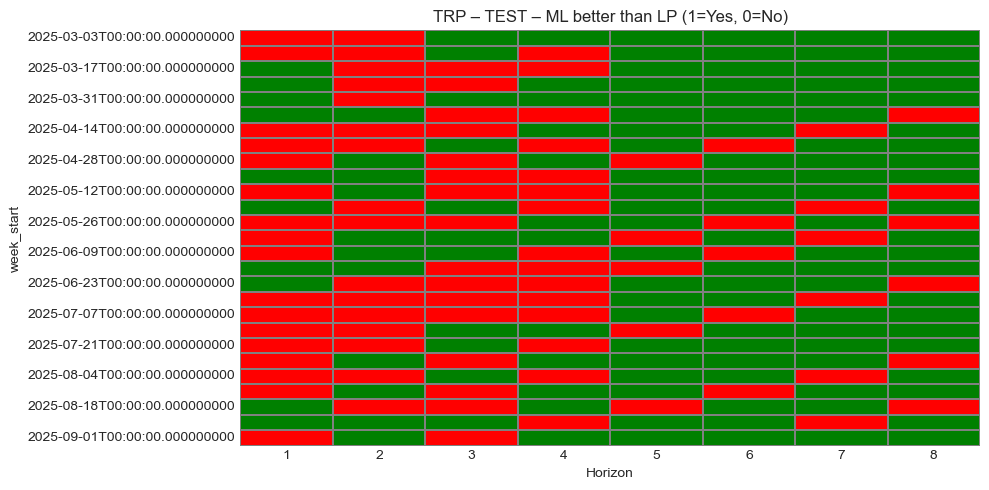

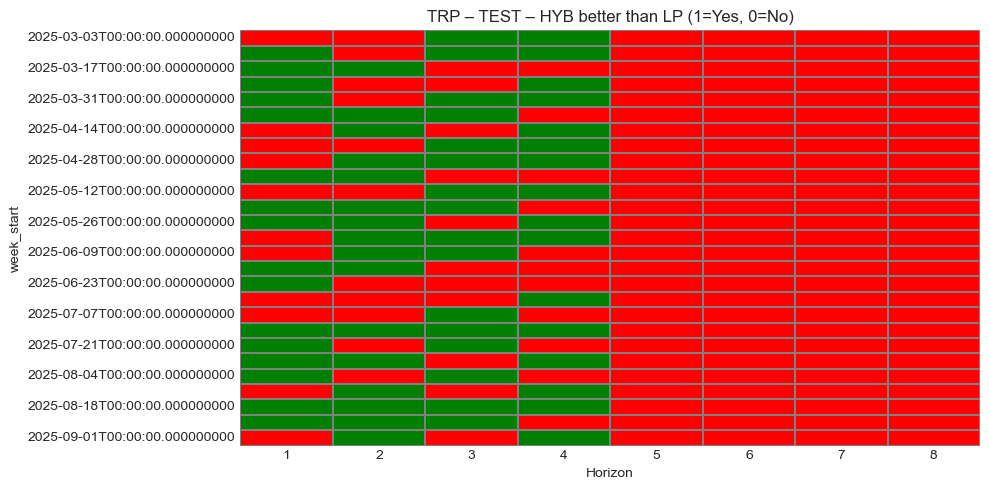

In [163]:
import seaborn as sns

def plot_win_loss_heatmap(df_full, lg="TRR", split="test", use_hybrid=False):
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["split"] == split)
    ].copy()

    # For each (week, horizon), compute which is better
    df["ml_better_flag"] = (df["ml_wape"] < df["lp_wape"]).astype(int)
    # Optional hybrid flag
    if use_hybrid and "hyb_wape" in df.columns:
        df["hyb_better_flag"] = (df["hyb_wape"] < df["lp_wape"]).astype(int)

    # Pivot: weeks vs horizon
    pivot_ml = df.pivot(index="week_start", columns="horizon", values="ml_better_flag")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        pivot_ml,
        cmap=sns.color_palette(["red", "green"]),
        cbar=False,
        linewidths=0.3,
        linecolor="grey"
    )
    plt.title(f"{lg} – {split.upper()} – ML better than LP (1=Yes, 0=No)")
    plt.xlabel("Horizon")
    plt.ylabel("week_start")
    plt.tight_layout()
    plt.show()

    if use_hybrid and "hyb_better_flag" in df.columns:
        pivot_hyb = df.pivot(index="week_start", columns="horizon", values="hyb_better_flag")
        plt.figure(figsize=(10, 5))
        sns.heatmap(
            pivot_hyb,
            cmap=sns.color_palette(["red", "green"]),
            cbar=False,
            linewidths=0.3,
            linecolor="grey"
        )
        plt.title(f"{lg} – {split.upper()} – HYB better than LP (1=Yes, 0=No)")
        plt.xlabel("Horizon")
        plt.ylabel("week_start")
        plt.tight_layout()
        plt.show()

# Example:
plot_win_loss_heatmap(full_weekly_report, lg="TRR", split="test", use_hybrid=False)
plot_win_loss_heatmap(full_weekly_report, lg="TRP", split="test", use_hybrid=True)


### Entity-level WAPE Boxplots

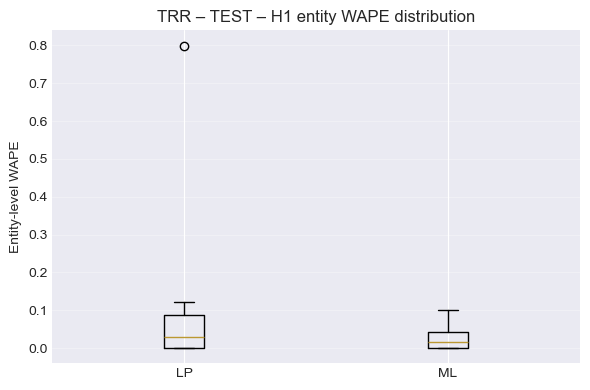

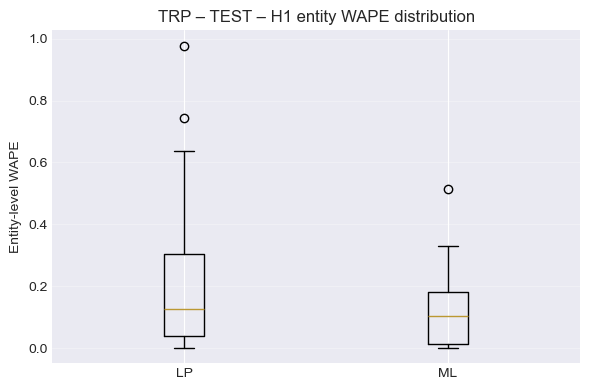

In [164]:
def boxplot_entity_wape(eval_dict_lg, lg_name="TRR", horizon=1, split="test"):
    """
    eval_dict_lg: eval_trr_tuned or eval_trp_tuned (dict with 'train','valid','test')
    """
    df = eval_dict_lg[split].copy()
    ml_col = f"ml_h{horizon}"
    lp_col = f"lp_w{horizon}"

    df = df[["entity", "actual", lp_col, ml_col]].dropna()

    # Aggregate to entity-level sums
    agg = df.groupby("entity").agg(
        actual_sum=("actual", "sum"),
        lp_sum=(lp_col, "sum"),
        ml_sum=(ml_col, "sum"),
    ).reset_index()

    agg["lp_wape"] = np.abs(agg["actual_sum"] - agg["lp_sum"]) / (np.abs(agg["actual_sum"]) + 1e-6)
    agg["ml_wape"] = np.abs(agg["actual_sum"] - agg["ml_sum"]) / (np.abs(agg["actual_sum"]) + 1e-6)

    plt.figure(figsize=(6, 4))
    plt.boxplot(
        [agg["lp_wape"], agg["ml_wape"]],
        labels=["LP", "ML"],
        showfliers=True
    )
    plt.ylabel("Entity-level WAPE")
    plt.title(f"{lg_name} – {split.upper()} – H{horizon} entity WAPE distribution")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
boxplot_entity_wape(eval_trr_tuned, lg_name="TRR", horizon=1, split="test")
boxplot_entity_wape(eval_trp_tuned, lg_name="TRP", horizon=1, split="test")


### Scatter Plot – LP error vs ML error

In [ ]:
# =============================================================================
# USING THE HUBBLEAI PIPELINE
# =============================================================================
# 
# The following shows how to use the refactored pipeline.
# Uncomment and run to execute the full forecast pipeline.
#
# from hubbleAI.pipeline import run_forecast
#
# # Run forecast
# status = run_forecast(trigger_source='manual')
#
# print(f"Run ID: {status.run_id}")
# print(f"Status: {status.status}")
# print(f"Message: {status.message}")
#
# # Load and inspect forecasts
# if status.status == 'success':
#     forecasts_path = status.output_paths.get('forecasts')
#     if forecasts_path:
#         forecasts_df = pd.read_parquet(forecasts_path)
#         print(f"\nLoaded {len(forecasts_df)} forecasts")
#         print(forecasts_df.head())


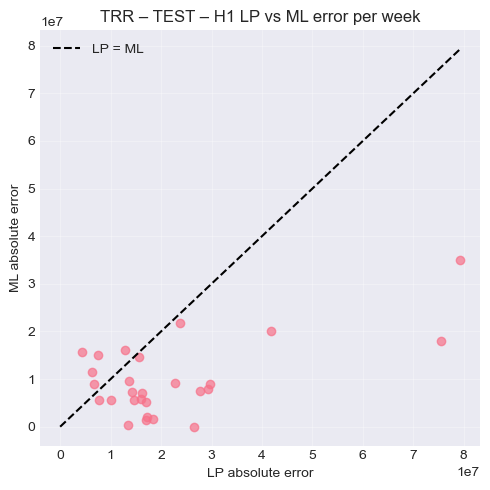

In [165]:
def scatter_lp_vs_ml_error(df_full, lg="TRR", horizon=1, split="test"):
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["horizon"] == horizon)
        & (df_full["split"] == split)
    ].copy()

    df["lp_abs_error"] = np.abs(df["actual_sum"] - df["lp_sum"])
    df["ml_abs_error"] = np.abs(df["actual_sum"] - df["ml_sum"])

    plt.figure(figsize=(5, 5))
    plt.scatter(df["lp_abs_error"], df["ml_abs_error"], alpha=0.7)
    max_val = max(df["lp_abs_error"].max(), df["ml_abs_error"].max())
    plt.plot([0, max_val], [0, max_val], "k--", label="LP = ML")
    plt.xlabel("LP absolute error")
    plt.ylabel("ML absolute error")
    plt.title(f"{lg} – {split.upper()} – H{horizon} LP vs ML error per week")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
scatter_lp_vs_ml_error(full_weekly_report, lg="TRR", horizon=1, split="test")


### Horizon–Week Heatmap – Improvement vs LP

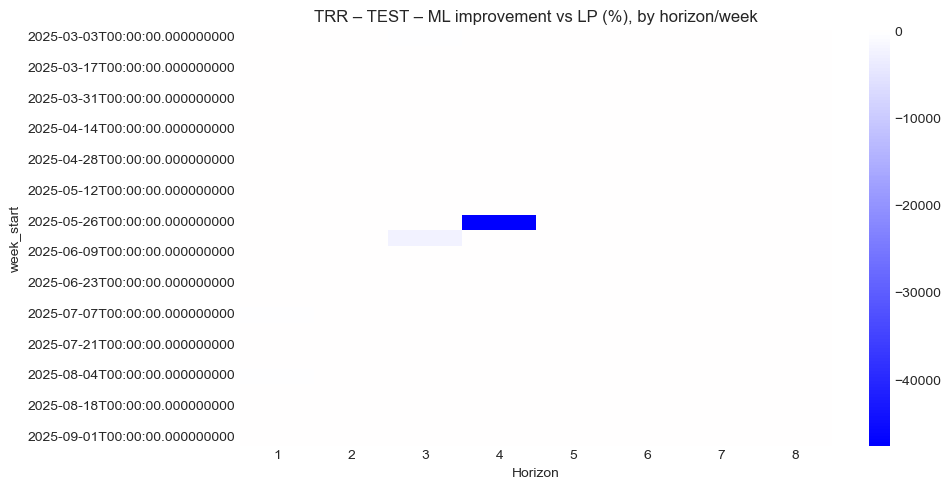

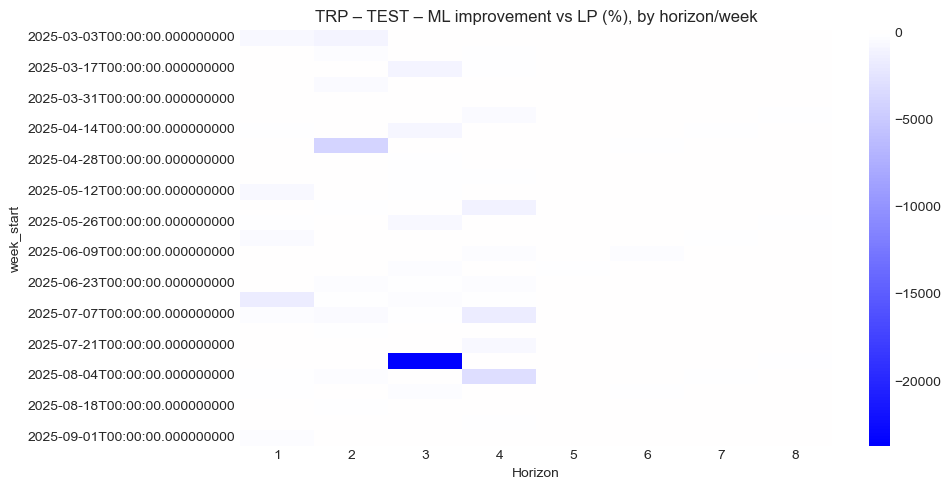

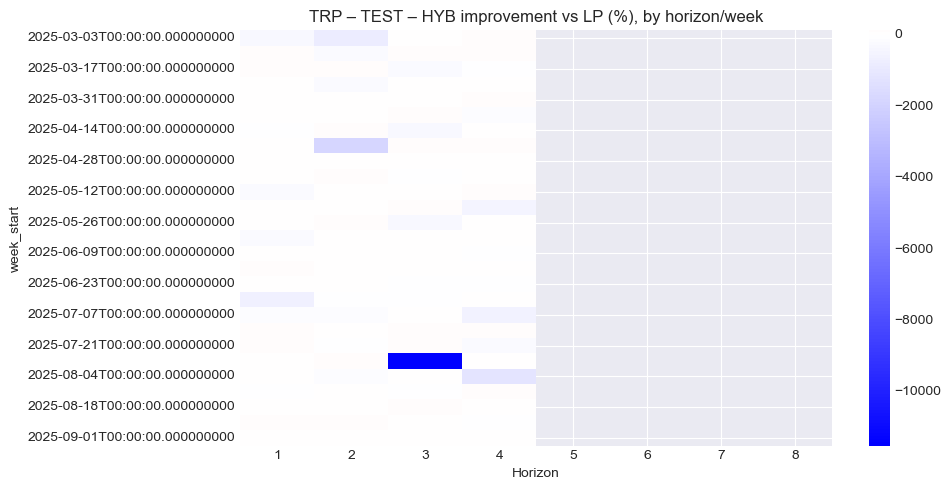

In [166]:
def heatmap_horizon_week_improvement(df_full, lg="TRR", split="test", use_hybrid=False):
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["split"] == split)
    ].copy()

    df["ml_improv_vs_lp"] = (df["lp_wape"] - df["ml_wape"]) / (df["lp_wape"] + 1e-6) * 100

    pivot_ml = df.pivot(index="week_start", columns="horizon", values="ml_improv_vs_lp")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        pivot_ml,
        center=0,
        cmap="bwr",
        annot=False,
        fmt=".1f"
    )
    plt.title(f"{lg} – {split.upper()} – ML improvement vs LP (%), by horizon/week")
    plt.xlabel("Horizon")
    plt.ylabel("week_start")
    plt.tight_layout()
    plt.show()

    if use_hybrid and "hyb_wape" in df.columns:
        df["hyb_improv_vs_lp"] = (df["lp_wape"] - df["hyb_wape"]) / (df["lp_wape"] + 1e-6) * 100
        pivot_hyb = df.pivot(index="week_start", columns="horizon", values="hyb_improv_vs_lp")

        plt.figure(figsize=(10, 5))
        sns.heatmap(
            pivot_hyb,
            center=0,
            cmap="bwr",
            annot=False,
            fmt=".1f"
        )
        plt.title(f"{lg} – {split.upper()} – HYB improvement vs LP (%), by horizon/week")
        plt.xlabel("Horizon")
        plt.ylabel("week_start")
        plt.tight_layout()
        plt.show()

# Example:
heatmap_horizon_week_improvement(full_weekly_report, lg="TRR", split="test")
heatmap_horizon_week_improvement(full_weekly_report, lg="TRP", split="test", use_hybrid=True)


### Weekly Summary “Cards”

In [167]:
def weekly_summary_cards(df_full, lg="TRP", horizon=1, split="test", n_weeks=10):
    df = df_full[
        (df_full["liquidity_group"] == lg)
        & (df_full["horizon"] == horizon)
        & (df_full["split"] == split)
    ].copy().sort_values("week_start")

    df["ml_better"] = df["ml_wape"] < df["lp_wape"]
    if "hyb_wape" in df.columns:
        df["hyb_better"] = df["hyb_wape"] < df["lp_wape"]

    cols = [
        "week_start", "actual_sum_M", "lp_sum_M", "ml_sum_M",
        "lp_wape", "ml_wape", "ml_better"
    ]
    if "hyb_wape" in df.columns:
        cols += ["hyb_sum_M", "hyb_wape", "hyb_better"]

    # Show last n_weeks
    display(df[cols].tail(n_weeks))

# Example:
weekly_summary_cards(full_weekly_report, lg="TRP", horizon=1, split="test", n_weeks=8)


week_start  actual_sum_M   lp_sum_M    ml_sum_M   lp_wape   ml_wape  \
739 2025-07-14    -12.739060  -6.003740  -24.639278  0.528714  0.934152   
740 2025-07-21    -75.590323 -74.082707  -77.981196  0.019945  0.031629   
741 2025-07-28    -50.113065 -52.005271  -52.317957  0.037759  0.043998   
742 2025-08-04    -39.571624 -35.954148  -46.970336  0.091416  0.186970   
743 2025-08-11    -26.171938 -32.027104  -42.009232  0.223719  0.605125   
744 2025-08-18   -114.278603 -94.726870 -101.198191  0.171088  0.114461   
745 2025-08-25    -30.932631 -26.671869  -32.763477  0.137743  0.059188   
746 2025-09-01    -24.807906 -23.823957  -29.630600  0.039663  0.194402   

     ml_better  hyb_sum_M  hyb_wape  hyb_better  
739      False -15.225776  0.195204        True  
740      False -75.940143  0.004628        True  
741      False -51.975761  0.037170        True  
742      False -41.251275  0.042446        True  
743      False -36.721734  0.403096       False  
744       True -97.761527  0.144533        True  
745       True -29.511467  0.045944        True  
746      False -26.088964  0.051639       False